# This program is to calculate metallicities and their spread for control stars

## Notes for this program

My parameter list is different from Steffani's. My param list is shown below:\\\\
param_list = ['# APOGEE_ID_', 'GAIAEDR3_SOURCE_ID', 'GAIAEDR3_PARALLAX', 'GAIAEDR3_PARALLAX_ERROR', 'RA', 'DEC', 'GAIAEDR3_PMRA', 'GAIAEDR3_PMRA_ERROR', 'GAIAEDR3_PMDEC', 'GAIAEDR3_PMDEC_ERROR', 'GAIAEDR3_DR2_RADIAL_VELOCITY', 'GAIAEDR3_DR2_RADIAL_VELOCITY_ERROR', 'SNR', 'FE_H', 'FE_H_ERR', 'C_FE', 'C_FE_ERR', 'CI_FE', 'CI_FE_ERR', 'N_FE', 'N_FE_ERR', 'O_FE', 'O_FE_ERR', 'MG_FE', 'MG_FE_ERR', 'AL_FE', 'AL_FE_ERR', 'SI_FE', 'SI_FE_ERR', 'P_FE', 'P_FE_ERR', 'S_FE', 'S_FE_ERR', 'K_FE', 'K_FE_ERR', 'CA_FE', 'CA_FE_ERR', 'TI_FE', 'TI_FE_ERR', 'TIII_FE', 'TIII_FE_ERR', 'V_FE', 'V_FE_ERR', 'CR_FE', 'CR_FE_ERR', 'MN_FE', 'MN_FE_ERR', 'CO_FE', 'CO_FE_ERR', 'NI_FE', 'NI_FE_ERR']\\\\

So basically the RA index is 4, DEC index is 5, RV index is 10, and the first chemical abundance is at 13. The chemical abundances follow Steffani's form (e.g. abundance1, abundance1_error, abundance2, abundance2_error, etc.). What I did was make the standardizing step for both tSNE and UMAP take in the index of the first chemical abundance and from there it automatically adds 2 for each chem abundance going up.\\\\

Basically if you use my param_list it'll work. The param_list variable is just a list of strings of the index titles, I have a function somewhere that grabs the data for those indices.\\\\

For each GC, we just need the ra, dec, rhm_deg (rhm depends on dist I think).\\
There are global parameters for all GCs as well, so the parameter list, fov, and chemical abundance starting index.\\\\

LMK if shit dont work and there's probably something I forgot to explain.

#### STEP 0: Import the necessary packages/algorithms.

In [62]:
# General analysis/plotting packages:
import matplotlib.pyplot as plt
import numpy as np
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib import rc
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
from collections import Counter

# Specific t-SNE/visualization packages:
from sklearn.manifold import TSNE
from shapely.geometry import Point, Polygon

# UMAP shit
# Import UMAP
import umap.umap_ as umap

# Try using SKLEARN's StandardScaler to standardize the data
from sklearn.preprocessing import StandardScaler

# I/O
import sys

# OS
import os

# dbscan
from sklearn.cluster import DBSCAN

# tqdm
from tqdm.notebook import tqdm

# KDTree
from scipy.spatial import cKDTree

# mode
from scipy import stats as st

# music
import simpleaudio as sa

# time
import time

# save and load
import pickle

# optimization
from scipy.optimize import minimize

### Step 1: Load in the clusters

#### Load in selected star cluster
Input RA and DEC and the program will load in all the stars within a $10^o$ by $10^o$ FOV.

In [63]:
'''Read in APOGEE CSV file'''

apogee_filt = pd.read_csv('data/APOGEEDR17_GAIAEDR3_filter.csv', delimiter=',')
apogee_nofilt2 = pd.read_csv('data/APOGEEDR17_GAIAEDR3_noflagfilter.csv', delimiter=',')


### drop all NaN kinematic and chemistry values
apogee_nofilt = apogee_nofilt2.dropna(subset=['FE_H', 'FE_H_ERR', 'C_FE', 'C_FE_ERR', 'CI_FE', 'CI_FE_ERR', 'N_FE', 'N_FE_ERR',
              'O_FE', 'O_FE_ERR', 'MG_FE', 'MG_FE_ERR', 'AL_FE', 'AL_FE_ERR', 'SI_FE', 'SI_FE_ERR',
              'P_FE', 'P_FE_ERR', 'S_FE', 'S_FE_ERR', 'K_FE', 'K_FE_ERR', 'CA_FE', 'CA_FE_ERR',
              'TI_FE', 'TI_FE_ERR', 'TIII_FE', 'TIII_FE_ERR', 'V_FE', 'V_FE_ERR', 'CR_FE', 'CR_FE_ERR',
              'MN_FE', 'MN_FE_ERR', 'CO_FE', 'CO_FE_ERR', 'NI_FE', 'NI_FE_ERR', 'GAIAEDR3_PMRA', 'GAIAEDR3_PMRA_ERROR', 'GAIAEDR3_PMDEC', 'GAIAEDR3_PMDEC_ERROR', 'VHELIO_AVG', 'VERR'])
apogee_nofilt = apogee_nofilt.reset_index(drop=True)
GC_db = pd.read_csv('data/GCs_20RHMRT.csv', delimiter=',')

#### Initial star selection

In [64]:
### Finding stars within a set FOV of the GC centre
def find_cluster_stars(ra, dec, fov, df, name, rhm_deg, rt_deg):
    
    fov_new = 5 * rt_deg
    
    stars = []
    for count, i in enumerate(df['RA'].values):
        if i >= ra - fov_new and i <= ra + fov_new and df['DEC'].values[count] >= dec - fov_new and df['DEC'].values[count] <= dec + fov_new:
            stars.append(df.loc[count])
            
    print(len(stars), 'stars in a ' + str(fov_new) + 'x' + str(fov_new) + ' fov of the GC')
    
    '''if len(stars) != 0:
        # create a folder with name of GC only if there are stars in the field
        try: 
            os.makedirs('GCs_10RHM/' + name)
        except OSError as error:
            print('Directory ' + name+ ' already exists')

    ra_arr = np.empty(len(stars), dtype=float)
    dec_arr = np.empty(len(stars), dtype=float)
    for count, i in enumerate(stars):
        ra_arr[count] = i['RA']
        dec_arr[count] = i['DEC']
    
    rhm_circ = plt.Circle((ra, dec), rhm_deg, color='r', fill=False, label='rhm')
    rhm_rt_circ = plt.Circle((ra, dec), (rhm_deg + rt_deg)/2, color='g', fill=False, label='1/2 rhm, rt')
    rt_circ = plt.Circle((ra, dec), rt_deg, color='b', fill=False, label='rt')
    
    #plt.figure(figsize=(10,10))
    fig, ax = plt.subplots(1, figsize=(10,10))
    plt.plot(ra_arr, dec_arr, 'ok', linestyle='none', markersize=1, label='Stars')
    plt.plot(ra, dec, 'or', linestyle='none', markersize=5, label='GC centre')
    ax.add_patch(rhm_circ)
    ax.add_patch(rhm_rt_circ)
    ax.add_patch(rt_circ)
    plt.xlabel('RA', fontsize=20)
    plt.ylabel('DEC', fontsize=20)
    plt.title(name, fontsize=20)
    plt.xlim(ra - fov - 1, ra + fov + 1)
    plt.ylim(dec - fov - 1, dec + fov + 1)
    plt.legend(loc='best', fontsize=20)
    try:
        plt.savefig('GCs_10RHM/'+name+'/radec.png')
    except:
        print('No stars yo')
    plt.close('all')'''
    
    return stars
            

#### Separating list of stars into lists by parameter

In [65]:
def split_star_list(stars, parameters):
    param_dict = {}
    for i in parameters:
        if str(i) == '# APOGEE_ID_':
            param_dict[str(i)] = np.empty(len(stars), dtype=object)
        else:
            param_dict[str(i)] = np.empty(len(stars))
    for count,i in enumerate(stars):
        for j in parameters:
            param_dict[str(j)][count] = i[str(j)]
            
    return param_dict
        

#### Separating the dictionary values into a columns list

In [66]:
def split_cols(GC_param, parameters):
    cols = []
    for i in range(len(GC_param)):
        cols.append(GC_param[str(parameters[i])])
    
    return cols

#### Master GC load function

In [67]:
def master_load(ra, dec, fov, dataset, params, name, rhm_deg, rt_deg):
    stars_found = find_cluster_stars(ra, dec, fov, dataset, name, rhm_deg, rt_deg)
    GC_dict = split_star_list(stars_found, params)
    GC_cols = split_cols(GC_dict, param_list)
    
    return [GC_dict, GC_cols]
    

### Step 2: Filter the data

#### Filter 1 for data: Removing all stars without PM

In [68]:
def pm_filter(GC_dict, GC_cols):
    ### Filter 1: Remove stars that do not have proper motion values. ###
    pm_filter_nan = np.isnan(GC_dict['GAIAEDR3_PMRA'])
    pm_filter = np.where(pm_filter_nan==False)
    data_pmfilter = []
    for i in GC_cols:
        x = np.array(i)[pm_filter]
        data_pmfilter.append(x)
    #print("There are {} stars in our sample after the proper motion filtering.".format(len(data_pmfilter[0])))
    
    return data_pmfilter

#### Filter 2 for data: Removing all stars that do not have chemical abundances

In [69]:
def chem_filter(data_pmfilter, init_abundance_index):
    ### Filter 2: Remove stars that do not have data for all 19 abundances. ###
    abundance_filter = np.where((data_pmfilter[init_abundance_index] > -9999) & (data_pmfilter[init_abundance_index + 2] > -9999) & (data_pmfilter[init_abundance_index + 4]  > -9999)
                                & (data_pmfilter[init_abundance_index + 6]  > -9999) & (data_pmfilter[ init_abundance_index + 8]  > -9999) & (data_pmfilter[init_abundance_index + 10]  > -9999)
                                & (data_pmfilter[init_abundance_index + 12]  > -9999) & (data_pmfilter[init_abundance_index + 14]  > -9999) & (data_pmfilter[init_abundance_index + 16]  > -9999)
                                & (data_pmfilter[init_abundance_index + 18]  > -9999) & (data_pmfilter[init_abundance_index + 20]  > -9999) & (data_pmfilter[init_abundance_index + 22]  > -9999)
                                & (data_pmfilter[init_abundance_index + 24]  > -9999) & (data_pmfilter[init_abundance_index + 26]  > -9999) & (data_pmfilter[init_abundance_index + 28]  > -9999)
                                & (data_pmfilter[init_abundance_index + 30]  > -9999) & (data_pmfilter[init_abundance_index + 32]  > -9999) & (data_pmfilter[init_abundance_index + 34]  > -9999)
                                & (data_pmfilter[init_abundance_index + 36]  > -9999))

    data_abundancefilter = []
    for i in data_pmfilter:
        y = np.array(i)[abundance_filter]
        data_abundancefilter.append(y)
    #print("There are {} stars in our sample after the abundance filtering.".format(len(data_abundancefilter[0])))
    
    return data_abundancefilter

#### Filter 3 for data: Removing all duplicate spectra

In [70]:
# changed all indices of 0 to 4 (RA) and 23 to 12 (SNR)
def dup_filter(data_abundancefilter):
    d =  Counter(data_abundancefilter[4])
    #print(d)
    duplicates = [k for k, v in d.items() if v > 1]
    a_list = np.array(range(0, len(duplicates)))
    max_SNR_array = []

    for i in a_list:
        indices = np.where(data_abundancefilter[4] == duplicates[i])
        snr_val = data_abundancefilter[12][indices]
        maximum = max(snr_val)
        # 4 is RA, 12 is SNR
        index_maximum = np.where((data_abundancefilter[4] == duplicates[i]) & (data_abundancefilter[12] == maximum))
        #print(index_maximum[4])
        index_maximum = int(index_maximum[4])
        max_SNR_array.append(index_maximum)

    idx_sort = np.argsort(data_abundancefilter[4])
    sorted_ra_array = data_abundancefilter[4][idx_sort]
    vals, idx_start, count = np.unique(sorted_ra_array, return_counts=True, return_index=True)
    res = np.split(idx_sort, idx_start[1:])
    vals = vals[count == 1]
    listtest =  np.array(range(0, len(vals)))

    unique_array = []
    for i in listtest:
        unique_val = np.where(vals[i] == data_abundancefilter[4])
        unique_val = int(unique_val[0])
        unique_array.append(unique_val)

    #print("There are {} stars that do not have duplicate spectra.".format(len(unique_array)))
    #print("There are {} stars that have multiple spectra, in which we select highest SNR.".format(len(max_SNR_array)))
    
    if len(max_SNR_array) != 0:
        duplicates_filter = np.concatenate((unique_array, max_SNR_array))
        sortedarray = np.sort(duplicates_filter)

        data_duplicatesfilter = []
        for i in data_abundancefilter:
            z = np.array(i)[duplicates_filter]
            data_duplicatesfilter.append(z)

        #print("There are {} stars in our sample after removing sources with duplicate spectra.".format(len(data_duplicatesfilter[0])))
    
    else:
        #print('There were no duplicate spectra.')
        data_duplicatesfilter = data_abundancefilter
    
    return data_duplicatesfilter

#### Filter 4 for data: Removing all low SNR

In [71]:
def SNR_filter(data_duplicatesfilter):
    SNR_filter = np.where(data_duplicatesfilter[12] > 50)
    data_snrfilter = []
    for i in data_duplicatesfilter:
        a = np.array(i)[SNR_filter]
        data_snrfilter.append(a)

    #print("There are {} stars in our sample after removing sources with low SNR.".format(len(data_snrfilter[0])))

    return data_snrfilter

#### Master filter function

In [72]:
def master_filter(GC_dict, GC_cols):
    M3_pm_filter = pm_filter(GC_dict, GC_cols)
    M3_abundance_filter = chem_filter(M3_pm_filter, 15)
    M3_duplicates_filter = dup_filter(M3_abundance_filter)
    M3_SNR_filter = SNR_filter(M3_duplicates_filter)
    
    #print('\nThe final amount of stars in our sample is:', len(M3_SNR_filter[0]))
    return M3_SNR_filter

#### STEP 3: Define parameters for your GC of interest. 

These parameters are taken from the Baumgardt & Hilker (2018) catalogue: https://people.smp.uq.edu.au/HolgerBaumgardt/globular/.

#### STEP 4: Define a control group of cluster members.

We must define a control group of likely cluster members of M3 so we can see where these stars end up in the t-SNE projection. 

In [73]:
def control_group(data_filter, ra, dec, rhm_deg, rt_deg, name):
# Select all the stars within some radius of the cluster:
    def in_circle(center_x, center_y, radius, x, y):
        square_dist = (center_x - x) ** 2 + (center_y - y) ** 2
        return square_dist <= (radius) ** 2

    print('rhm: {:.2f}\trhmrt2: {:.2f}\trt: {:.2f}'.format(rhm_deg, (rhm_deg + rt_deg) / 2, rt_deg))
    
    ra_filtered = data_filter[4]
    dec_filtered = data_filter[5]

    control_size = min((rhm_deg + rt_deg) / 2, rt_deg)
    
    # Select stars within halfway between r,hm and rt (useful for large enough sample of probable cluster members):
    in_halfmass = in_circle(ra, dec, control_size, ra_filtered, dec_filtered)  
    indices_control = np.where(in_halfmass==True)
    
    ### TEST: rhm stars
    in_halfmass2 = in_circle(ra, dec, rhm_deg, ra_filtered, dec_filtered)  
    indices_control2 = np.where(in_halfmass2==True)
    
    # check for stars within rt
    in_rt = in_circle(ra, dec, rt_deg, ra_filtered, dec_filtered)
    indices_control_rt = np.where(in_rt == True)
    
    controlgroup = []
    for i in data_filter:
        b = np.array(i)[indices_control]
        controlgroup.append(b)


    # Example control group parameters: 
    ra_control = controlgroup[0]
    dec_control = controlgroup[1]

    print("There are {} stars within rhm".format(len(indices_control2[0])) + " and {} stars within (rhm+rt)/2".format(len(ra_control)) + ' and {} stars within the rt'.format(len(indices_control_rt[0])))
    
    # checking for any control stars within rhm
    if len(indices_control[0]) >= 20:
        # create a folder with name of GC only if there are stars in the rhm
        try: 
            os.makedirs('GCs_20RHMRT_N_ctrl_sigma_cluster/' + name)
        except OSError as error:
            print('Directory ' + name + ' already exists')
    
    rhm_circ = plt.Circle((ra, dec), rhm_deg, color='r', fill=False, label='rhm', zorder=2)
    rhm_rt_circ = plt.Circle((ra, dec), (rhm_deg + rt_deg)/2, color='g', fill=False, label='1/2 rhm, rt', zorder=2)
    rt_circ = plt.Circle((ra, dec), rt_deg, color='b', fill=False, label='rt', zorder=2)
    
    fov = 5
    
    #plt.figure(figsize=(10,10))
    fig, ax = plt.subplots(1, figsize=(10,10))
    plt.plot(ra_filtered, dec_filtered, 'ok', linestyle='none', markersize=1, label='Stars', zorder=0.5)
    plt.plot(ra, dec, 'or', linestyle='none', markersize=5, label='GC centre', zorder=0.7)
    ax.add_patch(rhm_circ)
    ax.add_patch(rhm_rt_circ)
    ax.add_patch(rt_circ)
    plt.xlabel('RA', fontsize=20)
    plt.ylabel('DEC', fontsize=20)
    plt.title('Filtered RA DEC for ' + name, fontsize=20)
    plt.xlim(ra - fov - 1, ra + fov + 1)
    plt.ylim(dec - fov - 1, dec + fov + 1)
    plt.legend(loc='best', fontsize=20)
    if len(indices_control[0]) >= 20:
        plt.savefig('GCs_20RHMRT_N_ctrl_sigma_cluster/'+name+'/radec.png')
    plt.close('all')
    
    
    # no control stars within rt
    if len(indices_control[0]) < 20:
        print('Less than 20 control stars within (rhm+rt)/2')
        return [None]
    
    else:
        return indices_control

#### STEP 5: Run t-SNE on the control group and full filtered sample of APOGEE DR17 stars.

First, we standardize the data to ensure that no elements dominate or skew the t-SNE run. We want to include 19 chemical abundances and radial velocities in our run.


In [74]:
def standardize_data(data_filter, param_dict):
    '''
    Takes in a dictionary of parameters with the parameter name as the key and the index in the APOGEE file as the key value.
    '''
    
    pre_nonerr_array = []
    params_arr = []
    
    pre_err_array = []
    
    print(data_filter)
    
    for key in param_dict:
        if 'err' not in str(key):
            pre_nonerr_array.append(data_filter[param_dict[key]])
            params_arr.append(key)
        else:
            pre_err_array.append(data_filter[param_dict[key]])
    
    pre_nonerr_array = np.array(pre_nonerr_array)
    pre_err_array = np.array(pre_err_array)
    
    standardized = []
    standardized_err = []
    
    for i in pre_nonerr_array:
        mean, sigma = np.nanmean(i), np.nanstd(i)
        #norm = (i - mean) / sigma
        standardized.append(i)
        
    for i in pre_err_array:
        mean, sigma = np.nanmean(i), np.nanstd(i)
        #norm = (i - mean) / sigma
        standardized_err.append(i)
        
    return [standardized, standardized_err]

#### Taking in datasheet and name and automatically getting the parameters

In [79]:
def GC_params(GC_name, db):
    GC = db.loc[db['Cluster'] == GC_name].iloc[0]
    name = GC['Cluster']
    ra = GC['RA']
    dec = GC['DEC']
    mass = GC['Mass']
    rhm = GC['rhm'] # will steff fix this, nobody knows # edit she did
    rt = GC['rt']
    rho_c = GC['rho_c']
    sig0 = GC['sig0']
    vesc = GC['vesc']
    c = GC['c']
    d_Sun = GC['R_Sun'] * 1e3
    rhm_deg = math.degrees(math.atan(rhm / d_Sun))
    rt_deg = math.degrees(math.atan(rt / d_Sun))
    
    return ra, dec, rhm_deg, rt_deg

In [80]:
def input_GC_name(db):
    GC_name = input("Please enter the GC name according to Steff's catalogue:")
    if db.loc[db['Cluster'] == GC_name].empty:
        print('Not a valid name, double check and try again')
        return input_GC_name(db)
    else:
        return GC_name

#### Global GC params

In [81]:
param_list = ['# APOGEE_ID_', 'GAIAEDR3_SOURCE_ID', 'GAIAEDR3_PARALLAX', 'GAIAEDR3_PARALLAX_ERROR',
              'RA', 'DEC', 'GAIAEDR3_PMRA', 'GAIAEDR3_PMRA_ERROR', 'GAIAEDR3_PMDEC', 'GAIAEDR3_PMDEC_ERROR', 
              'VHELIO_AVG', 'VERR', 'SNR', 'ASPCAPFLAG', 'STARFLAG',
              'FE_H', 'FE_H_ERR', 'C_FE', 'C_FE_ERR', 'CI_FE', 'CI_FE_ERR', 'N_FE', 'N_FE_ERR',
              'O_FE', 'O_FE_ERR', 'MG_FE', 'MG_FE_ERR', 'AL_FE', 'AL_FE_ERR', 'SI_FE', 'SI_FE_ERR',
              'P_FE', 'P_FE_ERR', 'S_FE', 'S_FE_ERR', 'K_FE', 'K_FE_ERR', 'CA_FE', 'CA_FE_ERR',
              'TI_FE', 'TI_FE_ERR', 'TIII_FE', 'TIII_FE_ERR', 'V_FE', 'V_FE_ERR', 'CR_FE', 'CR_FE_ERR',
              'MN_FE', 'MN_FE_ERR', 'CO_FE', 'CO_FE_ERR', 'NI_FE', 'NI_FE_ERR']
abundance_index = 15 # index where the first chemical abundance starts
RV_index = 10 # where the radial velocity index is (NOTE: USE VHELIO_AVG NOT THE STUPID GAIA ONE)
PMRA_index = 6 # PMRA index
PMDEC_index = 8 # PMDEC index

# dictionary of all relevant parameters we could ever want for tSNE and UMAP
# the abundances should skip every other one due to it being [chem1, chem1_err, chem2, chem2_err, etc.]
all_param_dict = {'FE_H': abundance_index,
                  'FE_H_err': abundance_index + 1,
                  'C_FE': abundance_index + 2,
                  'C_FE_err': abundance_index + 3,
                  'CI_FE': abundance_index + 4,
                  'CI_FE_err': abundance_index + 5,
                  'N_FE': abundance_index + 6,
                  'N_FE_err': abundance_index + 7,
                  'O_FE': abundance_index + 8,
                  'O_FE_err': abundance_index + 9,
                  'MG_FE': abundance_index + 10,
                  'MG_FE_err': abundance_index + 11,
                  'AL_FE': abundance_index + 12,
                  'AL_FE_err': abundance_index + 13,
                  'SI_FE': abundance_index + 14,
                  'SI_FE_err': abundance_index + 15,
                  'P_FE': abundance_index + 16,
                  'P_FE_err': abundance_index + 17,
                  'S_FE': abundance_index + 18,
                  'S_FE_err': abundance_index + 19,
                  'K_FE': abundance_index + 20,
                  'K_FE_err': abundance_index + 21,
                  'CA_FE': abundance_index + 22,
                  'CA_FE_err': abundance_index + 23,
                  'TI_FE': abundance_index + 24,
                  'TI_FE_err': abundance_index + 25,
                  'TIII_FE': abundance_index + 26,
                  'TIII_FE_err': abundance_index + 27,
                  'V_FE': abundance_index + 28,
                  'V_FE_err': abundance_index + 29,
                  'CR_FE': abundance_index + 30,
                  'CR_FE_err': abundance_index + 31,
                  'MN_FE': abundance_index + 32,
                  'MN_FE_err': abundance_index + 33,
                  'CO_FE': abundance_index + 34,
                  'CO_FE_err': abundance_index + 35,
                  'NI_FE': abundance_index + 36,
                  'NI_FE_err': abundance_index + 37,
                  'RV': RV_index, 'RV_err': RV_index + 1,
                  'PMRA': PMRA_index, 'PMRA_err': PMRA_index + 1,
                  'PMDEC': PMDEC_index, 'PMDEC_err': PMDEC_index + 1}

fov = 5 # field of view (note: for x by x, use fov = x/2)
ML_index = 0 # 0 for both tSNE and UMAP, 1 for only tSNE, 2 for only UMAP, any other value will raise an error

# dim reduction kin

In [82]:
GC_name_list = GC_db.loc[:, 'Cluster']
GC_ra_list = GC_db.loc[:, 'RA']
GC_dec_list = GC_db.loc[:, 'DEC']

In [83]:
### reading dim reduction w/ kin results

with open('saved_runs_5_RT/GC_stars_dict_kin.pkl', 'rb') as f:
    GC_stars_dict = pickle.load(f)

In [84]:
control_stars_list = [] # list of # of control stars
total_stars_list = [] # list of # of total stars

sum = 0
for key in GC_stars_dict: # going through and cutting out the ones that have None (i.e. no control stars)
    if GC_stars_dict[key][2] is None: # if there is no controls, we set the number of control and all stars to 0
        control_stars_list.append(0)
        total_stars_list.append(0)
    else:
        sum += 1
        control_stars_list.append(len(GC_stars_dict[key][2]))
        total_stars_list.append(len(GC_stars_dict[key][0]))

In [85]:
new_control_stars_list = [] # control stars we want to keep
new_total_stars_list = [] # total stars we want to keep
new_stars_index_list = [] # indices of total stars

for i in range(len(control_stars_list)):
    if control_stars_list[i] != 0: # if the number of the control stars were not 0, keep the GC
        new_control_stars_list.append(control_stars_list[i])
        new_total_stars_list.append(total_stars_list[i])
        new_stars_index_list.append(i)

In [86]:
GC_name_arr = np.empty(len(new_stars_index_list), dtype=np.ndarray) # names of the final GCs

# tsne x,y coords
tsne_control_X = np.empty(len(new_stars_index_list), dtype=np.ndarray)
tsne_control_Y = np.empty(len(new_stars_index_list), dtype=np.ndarray)
tsne_all_X = np.empty(len(new_stars_index_list), dtype=np.ndarray)
tsne_all_Y = np.empty(len(new_stars_index_list), dtype=np.ndarray)

# umap x,y coords
umap_control_X = np.empty(len(new_stars_index_list), dtype=np.ndarray)
umap_control_Y = np.empty(len(new_stars_index_list), dtype=np.ndarray)
umap_all_X = np.empty(len(new_stars_index_list), dtype=np.ndarray)
umap_all_Y = np.empty(len(new_stars_index_list), dtype=np.ndarray)

# control star indices
control_indices_rad = np.empty(len(new_stars_index_list), dtype=np.ndarray)

# going through the GCs that had control stars and breaking up the dictionary into the star lists above
for i in range(len(new_stars_index_list)):
    ind = new_stars_index_list[i]
    GC_name_arr[i] = GC_name_list[ind]
    
    tsne_control_X[i] = GC_stars_dict[GC_name_arr[i]][2]
    tsne_control_Y[i] = GC_stars_dict[GC_name_arr[i]][3]
    tsne_all_X[i] = GC_stars_dict[GC_name_arr[i]][0]
    tsne_all_Y[i] = GC_stars_dict[GC_name_arr[i]][1]
    
    umap_control_X[i] = GC_stars_dict[GC_name_arr[i]][6]
    umap_control_Y[i] = GC_stars_dict[GC_name_arr[i]][7]
    umap_all_X[i] = GC_stars_dict[GC_name_arr[i]][4]
    umap_all_Y[i] = GC_stars_dict[GC_name_arr[i]][5]
    
    control_indices_rad[i] = GC_stars_dict[GC_name_arr[i]][8]

In [87]:
### reading dbscan for ctrls

with open('saved_runs_5_RT/tsne_ctrl_inds.pkl', 'rb') as f:
    tsne_ctrl_inds = pickle.load(f)
    
with open('saved_runs_5_RT/umap_ctrl_inds.pkl', 'rb') as f:
    umap_ctrl_inds = pickle.load(f)

In [41]:
start = time.time()


for i in tqdm(range(0, 34)):
    try: 
        os.makedirs('GCs_20RHMRT_N_ctrl_sigma_cluster/' + GC_name_arr[i])
        print('\nMaking directory ' + GC_name_arr[i])
    except OSError as error:
        print('\nDirectory ' + GC_name_arr[i] + ' already exists')
        
    ### plotting original data
    tsne_pack = [tsne_control_X[i], tsne_control_Y[i], tsne_all_X[i], tsne_all_Y[i]]
    umap_pack = [umap_control_X[i], umap_control_Y[i], umap_all_X[i], umap_all_Y[i]]
    
    plot_ML(GC_name_arr[i], tsne_pack, 'tsne')
    plot_ML(GC_name_arr[i], umap_pack, 'umap')
    
    ### final control stars
    final_control_group_plot(tsne_ctrl_inds[i], GC_name_arr[i], 'tsne', tsne_pack)
    final_control_group_plot(umap_ctrl_inds[i], GC_name_arr[i], 'umap', umap_pack)


Directory NGC_104 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)



Directory NGC_288 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)



Directory NGC_362 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)



Directory NGC_1851 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)



Directory NGC_1904 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)



Directory NGC_2808 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)



Directory NGC_3201 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)



Directory NGC_4590 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)



Directory NGC_5024 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)



Directory NGC_5139 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)



Directory NGC_5272 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)



Directory NGC_5904 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)



Directory NGC_6121 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)



Directory NGC_6171 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)



Directory NGC_6205 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)



Directory NGC_6218 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)



Directory NGC_6254 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)



Directory NGC_6273 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)



Directory NGC_6341 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)



Directory NGC_6380 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)



Directory NGC_6388 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)



Directory NGC_6397 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)



Directory NGC_6441 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)



Directory Ter_9 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)



Directory NGC_6522 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)



Directory NGC_6544 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)



Directory NGC_6553 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)



Directory NGC_6656 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)



Directory NGC_6715 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)



Directory NGC_6752 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)



Directory NGC_6809 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)



Directory NGC_6838 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)



Directory NGC_7078 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)



Directory NGC_7089 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


## metallicity calc of control stars

In [88]:
def standardize_data(data_filter, param_dict):
    '''
    Takes in a dictionary of parameters with the parameter name as the key and the index in the APOGEE file as the key value.
    '''
    
    pre_nonerr_array = []
    params_arr = []
    
    pre_err_array = []
    
    for key in param_dict:
        if 'err' not in str(key):
            pre_nonerr_array.append(data_filter[param_dict[key]])
            params_arr.append(key)
        else:
            pre_err_array.append(data_filter[param_dict[key]])
    
    pre_nonerr_array = np.array(pre_nonerr_array)
    pre_err_array = np.array(pre_err_array)
    
    standardized = []
    standardized_err = []
    
    for i in pre_nonerr_array:
        mean, sigma = np.nanmean(i), np.nanstd(i)
        #norm = (i - mean) / sigma
        standardized.append(i)
        
    for i in pre_err_array:
        mean, sigma = np.nanmean(i), np.nanstd(i)
        #norm = (i - mean) / sigma
        standardized_err.append(i)
        
    return [standardized, standardized_err]

In [89]:
def find_and_filter_stars(GC_name, master_param_dict, fov, db, dataset, params):
    print('\nProcessing:', GC_name)
    
    # getting GC parameteters
    ra, dec, rhm_deg, rt_deg = GC_params(GC_name, db)
    
    # loading
    GC_dict, GC_cols = master_load(ra, dec, fov, dataset, params, GC_name, rhm_deg, rt_deg)
    
    # filtering
    GC_filter_data = master_filter(GC_dict, GC_cols)
    
    standardized_array, standardized_err_array = standardize_data(GC_filter_data, master_param_dict)
    #print(len(standardized_array[0]))
    #print(len(standardized_err_array))
    
    return [standardized_array, standardized_err_array]

In [90]:
GC_stars = {}
GC_stars_err = {}
GC_stars_Fe = {}
GC_stars_Fe_err = {}

In [91]:
for count, i in tqdm(enumerate(GC_name_list)):
    GC_stars[i] = find_and_filter_stars(i, all_param_dict, fov, GC_db, apogee_nofilt, param_list)[0]
    GC_stars_err[i] = find_and_filter_stars(i, all_param_dict, fov, GC_db, apogee_nofilt, param_list)[1]
    
for key in GC_stars:
    GC_stars_Fe[key] = GC_stars[key][0] # 0 is the index for Fe abundance, its standardized
    
for key in GC_stars_err:
    GC_stars_Fe_err[key] = GC_stars_err[key][1] # 0 is the index for Fe_err abundance, its standardized


Processing: NGC_104
977 stars in a 8.034513185785698x8.034513185785698 fov of the GC

Processing: NGC_104
977 stars in a 8.034513185785698x8.034513185785698 fov of the GC

Processing: NGC_288
193 stars in a 3.022734119166619x3.022734119166619 fov of the GC

Processing: NGC_288
193 stars in a 3.022734119166619x3.022734119166619 fov of the GC

Processing: NGC_362
743 stars in a 2.983425483786819x2.983425483786819 fov of the GC

Processing: NGC_362
743 stars in a 2.983425483786819x2.983425483786819 fov of the GC

Processing: NGC_1851
239 stars in a 3.0466301676533436x3.0466301676533436 fov of the GC

Processing: NGC_1851
239 stars in a 3.0466301676533436x3.0466301676533436 fov of the GC

Processing: NGC_1904
246 stars in a 1.438514973206377x1.438514973206377 fov of the GC

Processing: NGC_1904
246 stars in a 1.438514973206377x1.438514973206377 fov of the GC

Processing: NGC_2808
499 stars in a 4.724195371102934x4.724195371102934 fov of the GC

Processing: NGC_2808
499 stars in a 4.724195

In [92]:
GC_ctrl_stars_Fe_tsne = {}
GC_ctrl_stars_Fe_err_tsne = {}
GC_ctrl_stars_Fe_umap = {}
GC_ctrl_stars_Fe_err_umap = {}
GC_ctrl_stars_Fe_both = {}
GC_ctrl_stars_Fe_err_both = {}

both_ctrl_inds = np.empty(len(tsne_ctrl_inds), dtype=object)

In [93]:
for i, tsne in enumerate(tsne_ctrl_inds):
    both = []
    for j in tsne:
        if j in umap_ctrl_inds[i]:
            both.append(j)
            
    both_ctrl_inds[i] = both

In [330]:
for i, k in enumerate(GC_stars_Fe):
    #print(i, k)
    GC_ctrl_stars_Fe_tsne[k] = GC_stars_Fe[k][tsne_ctrl_inds[i]]
    GC_ctrl_stars_Fe_umap[k] = GC_stars_Fe[k][umap_ctrl_inds[i]]
    GC_ctrl_stars_Fe_both[k] = GC_stars_Fe[k][both_ctrl_inds[i]]
    
for i, k in enumerate(GC_stars_Fe_err):
    GC_ctrl_stars_Fe_err_tsne[k] = GC_stars_Fe_err[k][tsne_ctrl_inds[i]]
    GC_ctrl_stars_Fe_err_umap[k] = GC_stars_Fe_err[k][umap_ctrl_inds[i]]
    GC_ctrl_stars_Fe_err_both[k] = GC_stars_Fe_err[k][both_ctrl_inds[i]]

In [34]:
def plt_fe(data, bin_size, name, ML):
    fig = plt.figure(figsize=(10, 10))
    plt.hist(data, bins=bin_size)
    plt.title(name + ' ' + ML, fontsize=40)
    plt.xticks(fontsize=40)
    plt.savefig('GCs_metallicity/' + name + '_' + ML + '.png')

In [35]:
def plt_bg(data, bin_size, name):
    fig = plt.figure(figsize=(10, 10))
    plt.hist(data, bins=bin_size)
    plt.title(name + 'Background', fontsize=40)
    plt.xticks(fontsize=40)
    plt.savefig('GCs_metallicity/' + name + '_bg.jpg')

In [335]:
def plot_overlay(name, bg, tsne, umap, bin_size): 
    fig = plt.figure(figsize=(10,10))
    plt.hist(bg, bins=np.arange(min(bg), max(bg), bin_size), color='white', edgecolor='black', label='Background')
    plt.hist(tsne, bins=np.arange(min(bg), max(bg), bin_size), color='red', alpha=.3, label='t-SNE controls')
    plt.hist(umap, bins=np.arange(min(bg), max(bg), bin_size), color='blue', alpha=.3, label='UMAP controls')
    plt.xticks(fontsize=20)
    plt.legend(loc='best')
    plt.title(name, fontsize=40)
    plt.savefig('GCs_metallicity/' + name + '_overlay.png')
    plt.close()

<ipython-input-128-8963018d72ca>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10, 10))


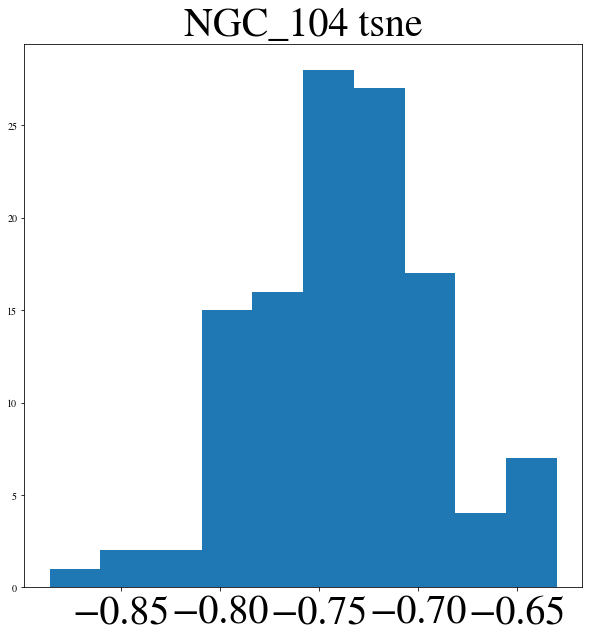

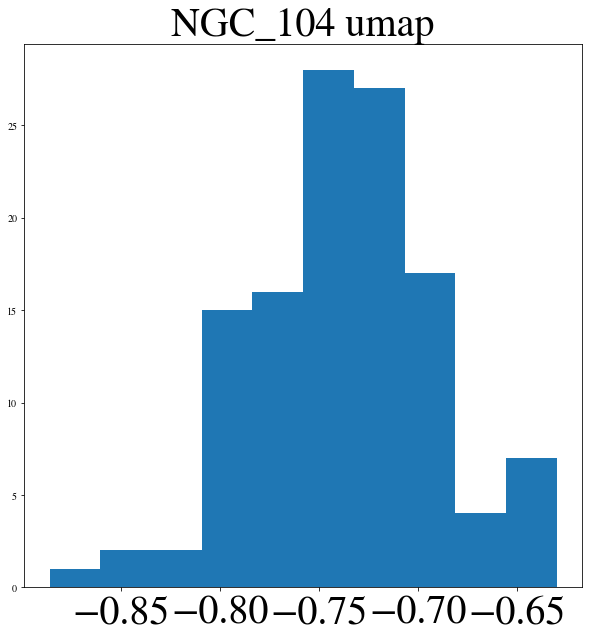

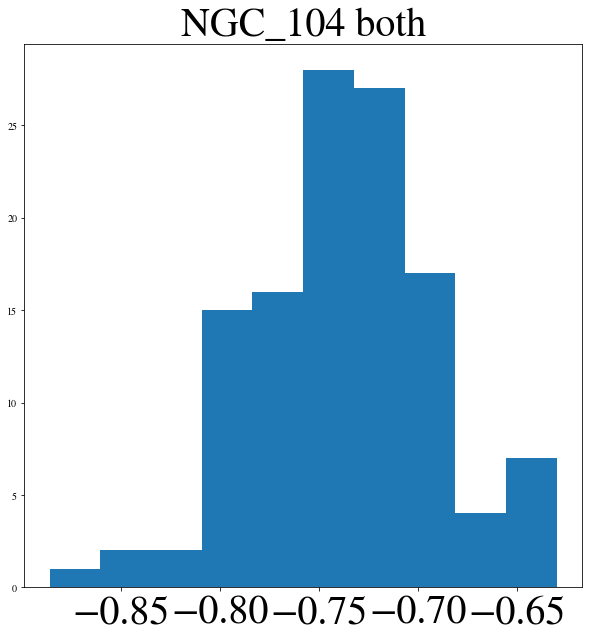

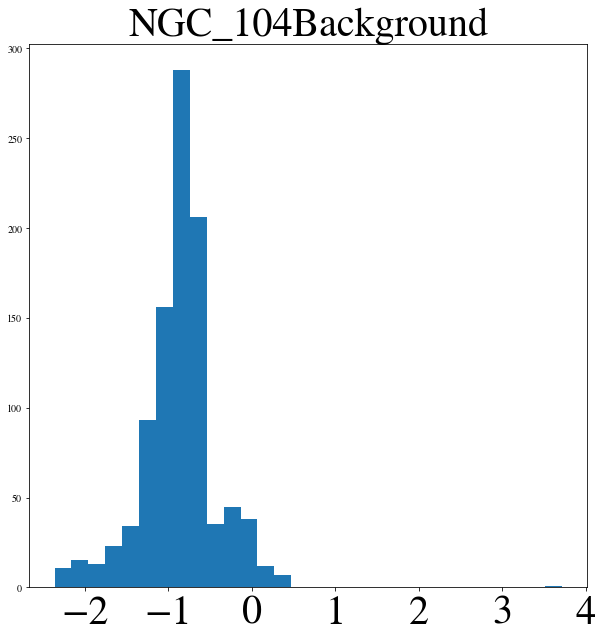

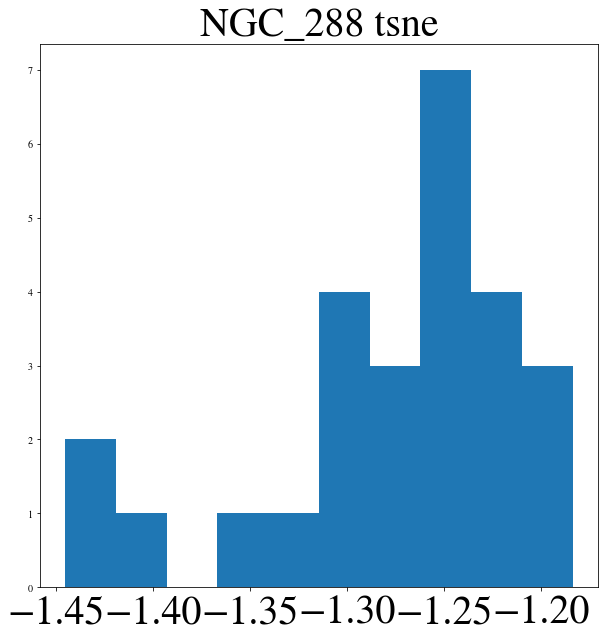

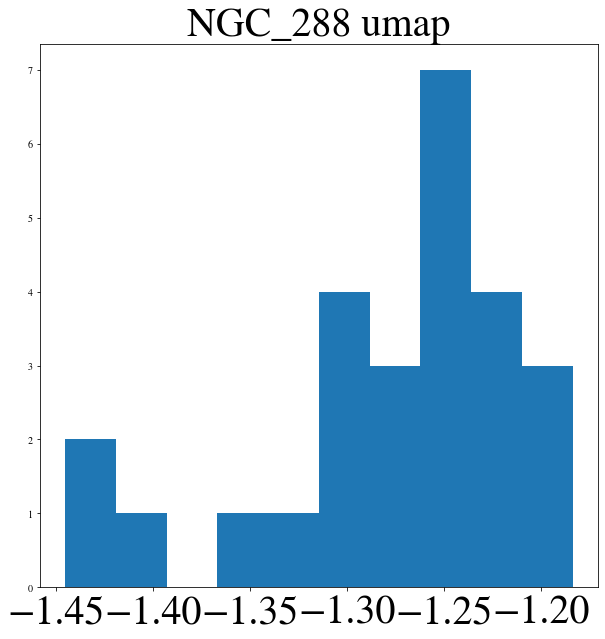

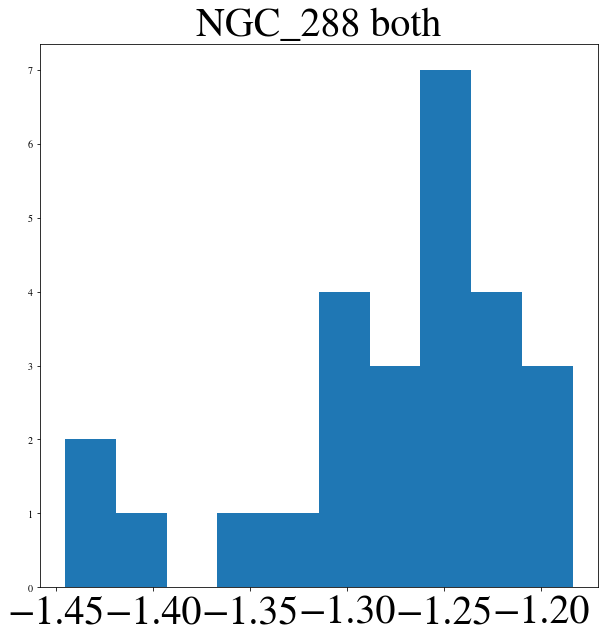

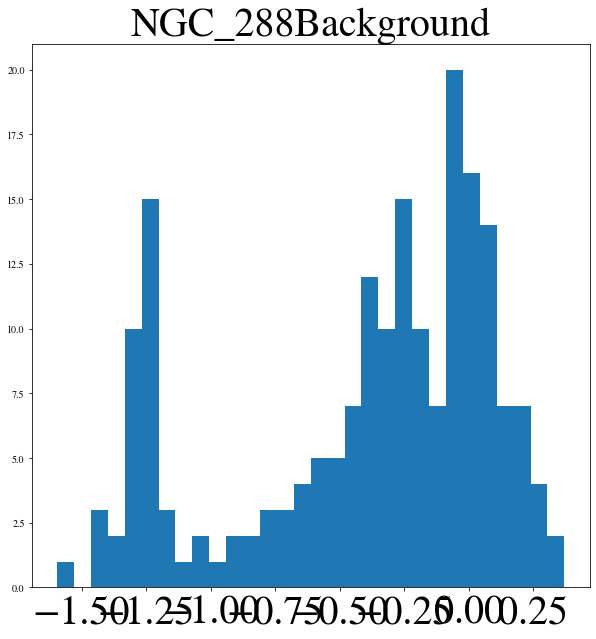

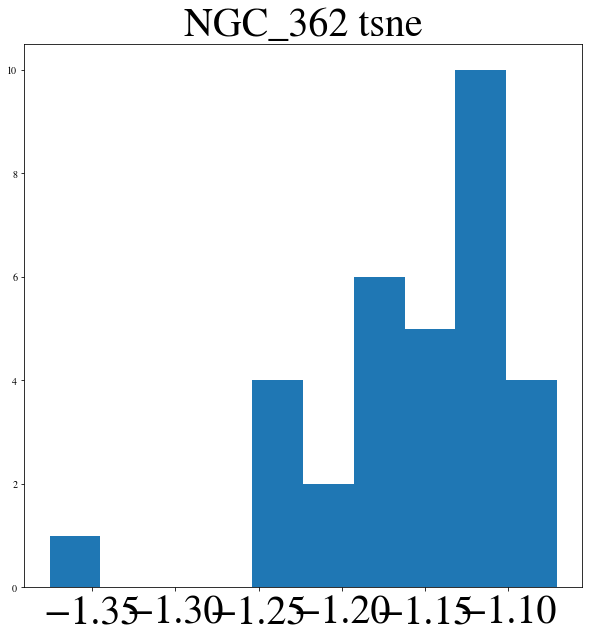

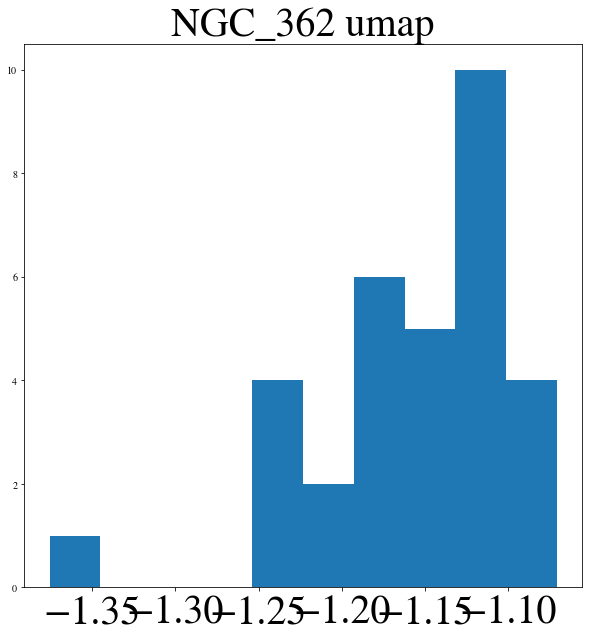

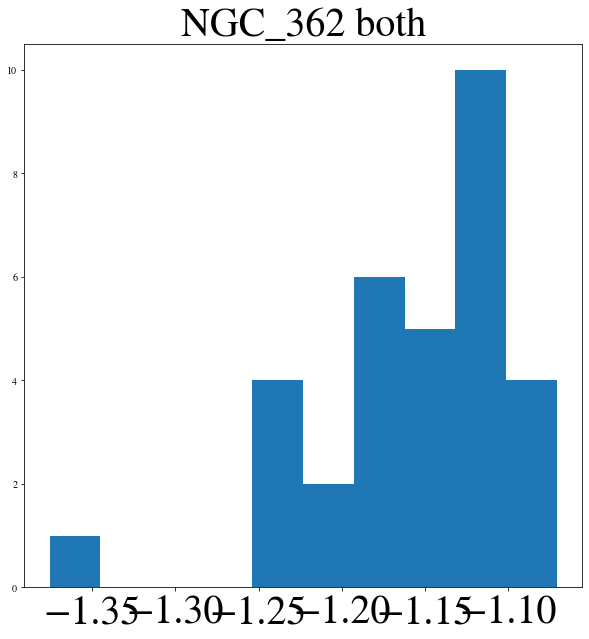

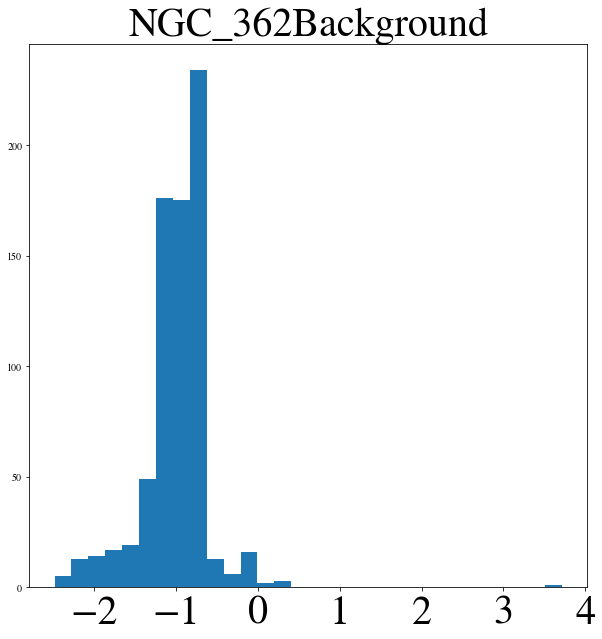

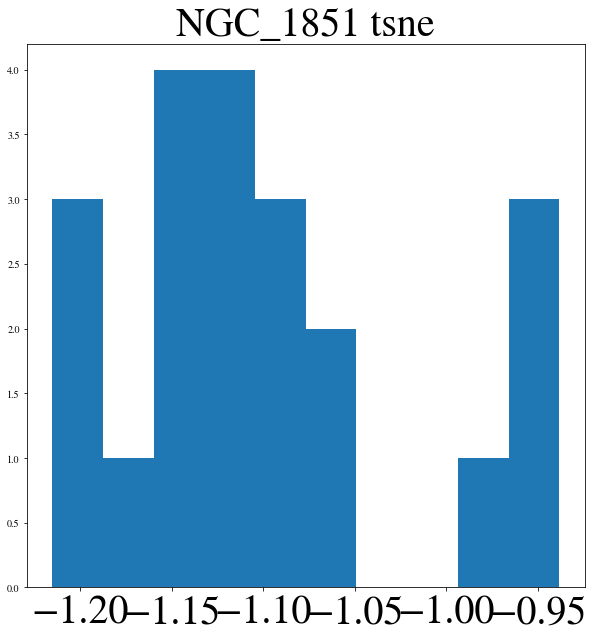

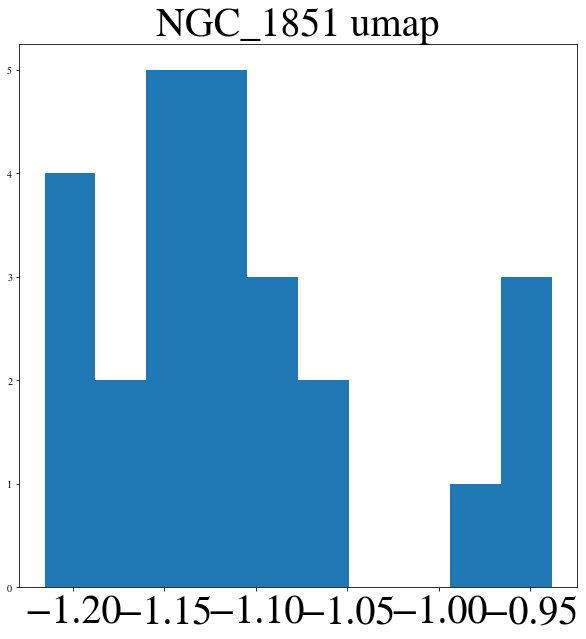

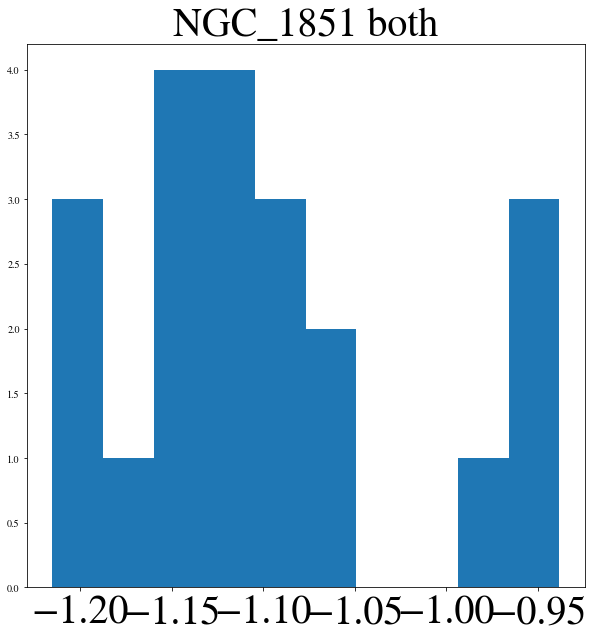

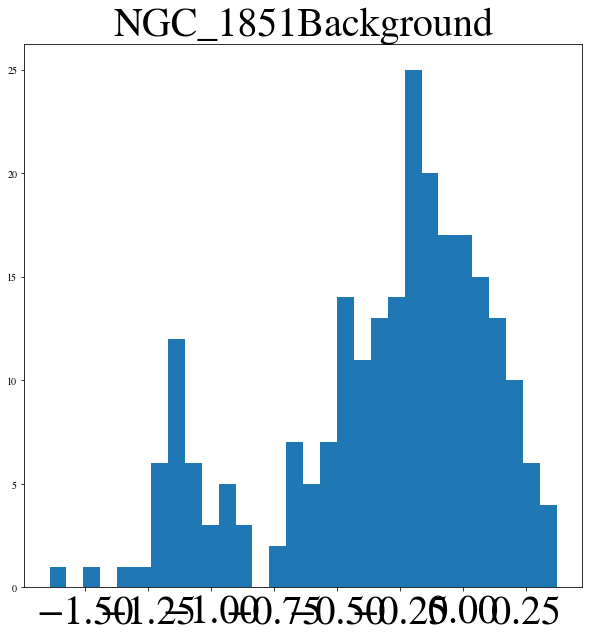

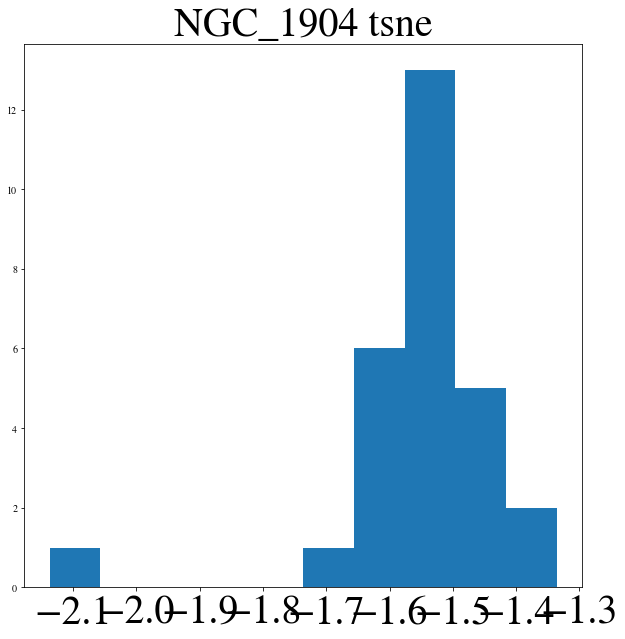

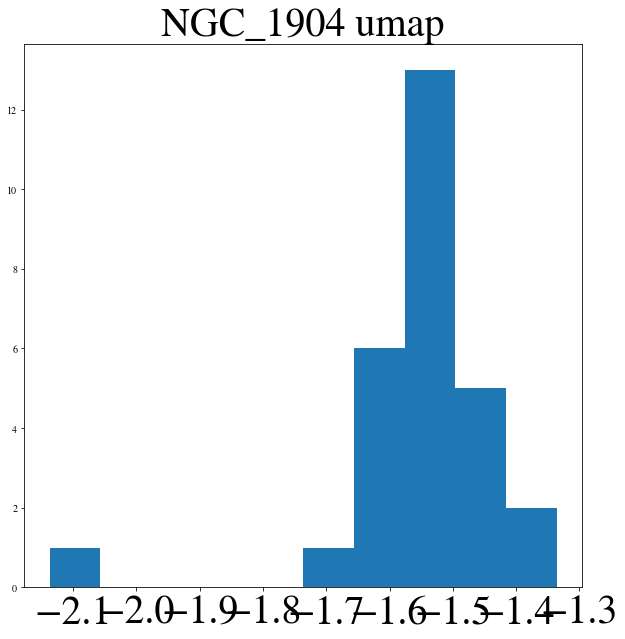

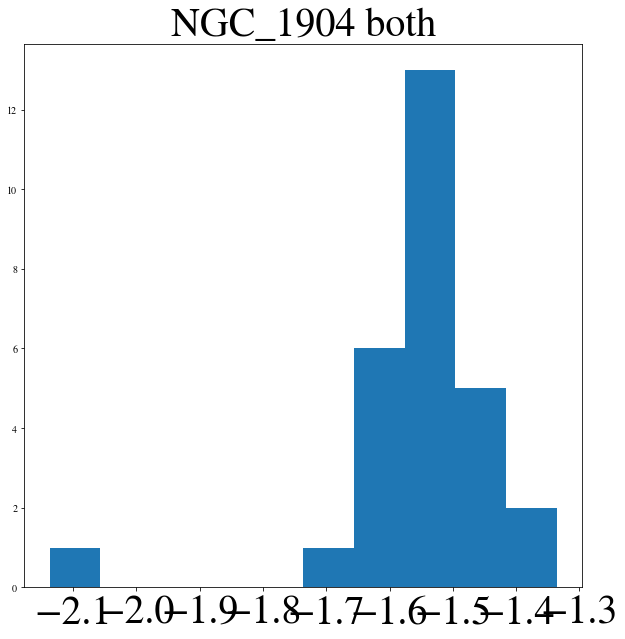

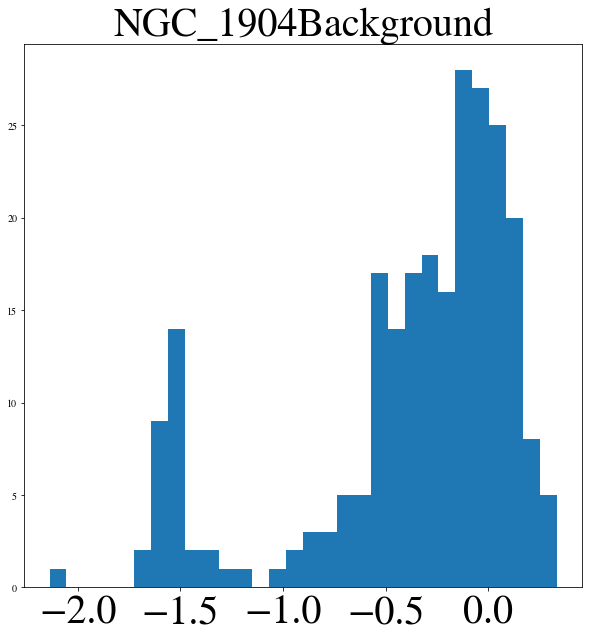

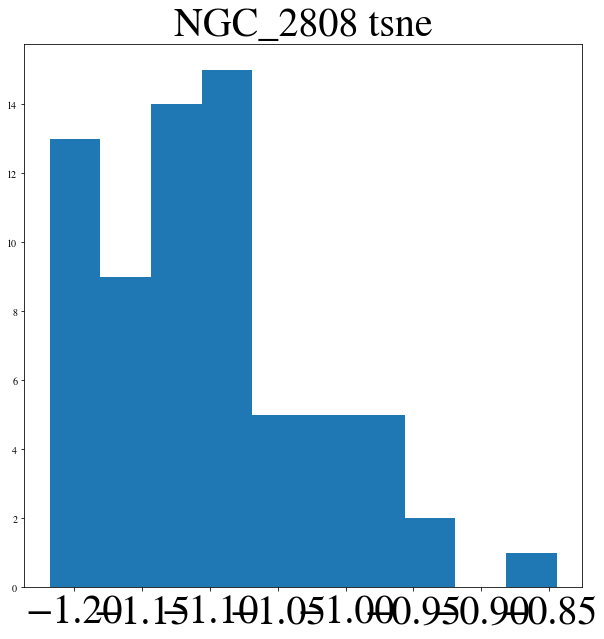

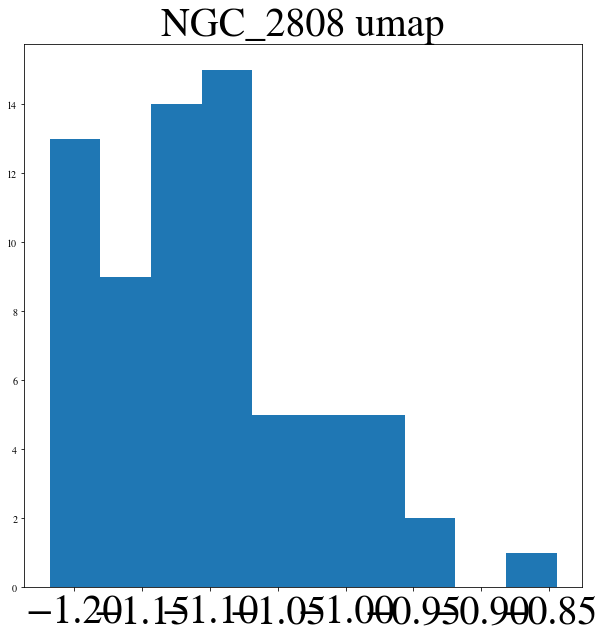

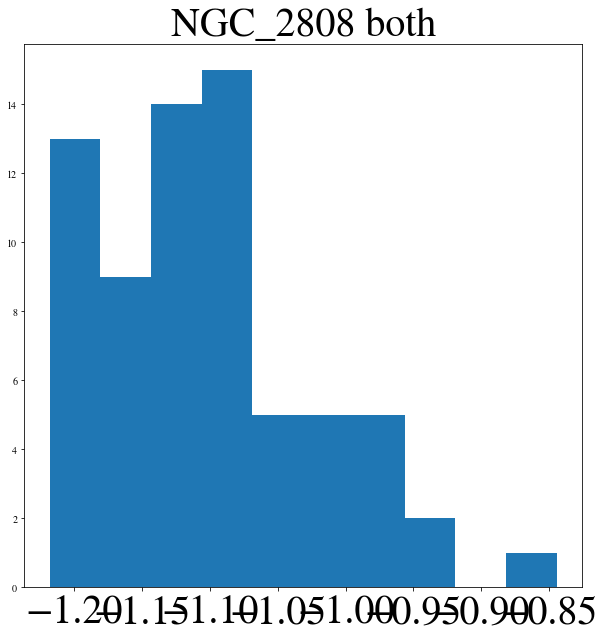

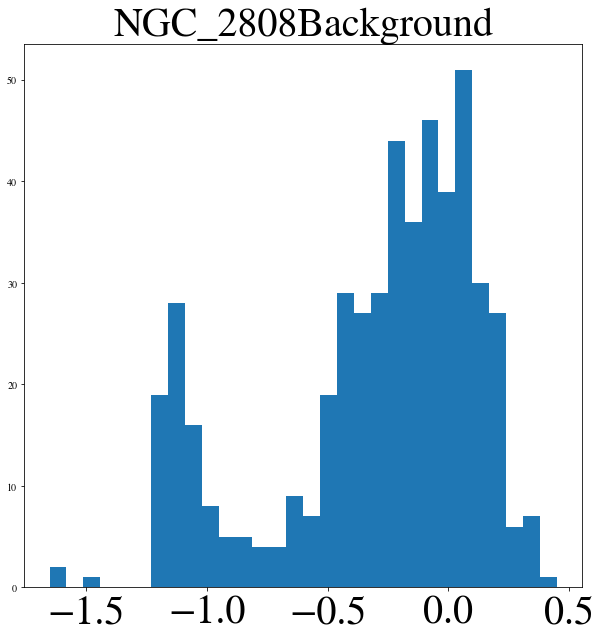

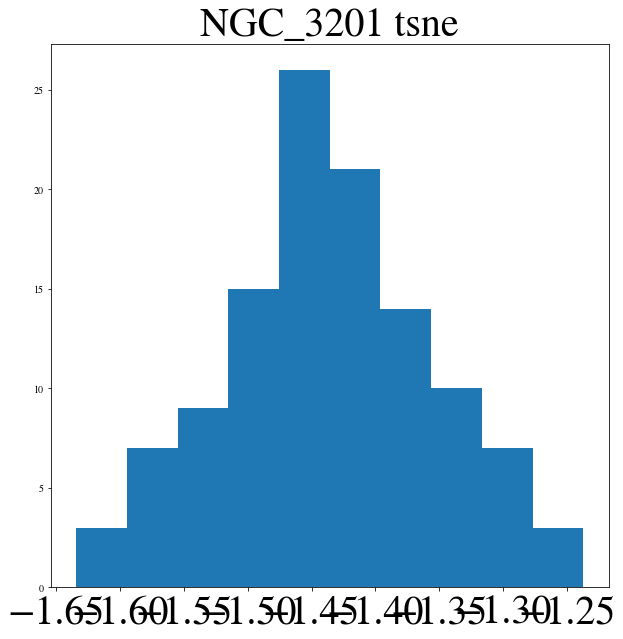

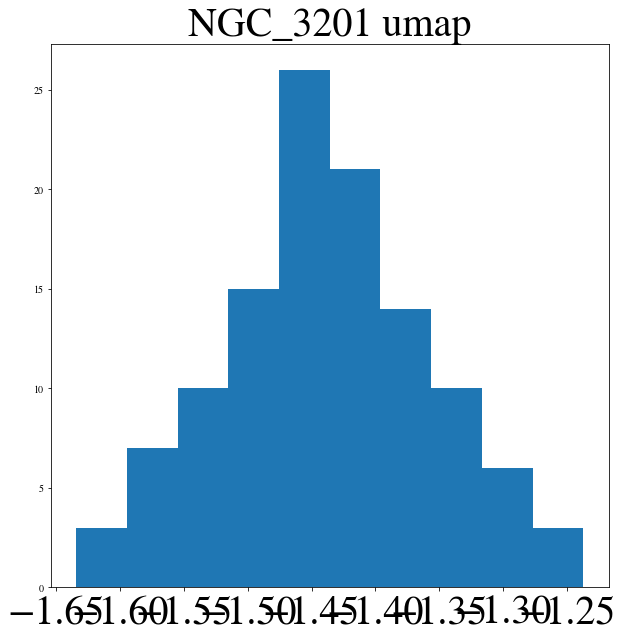

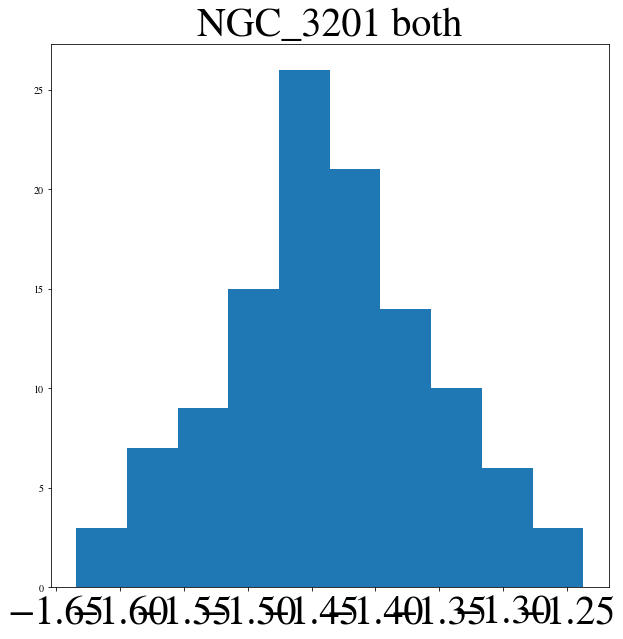

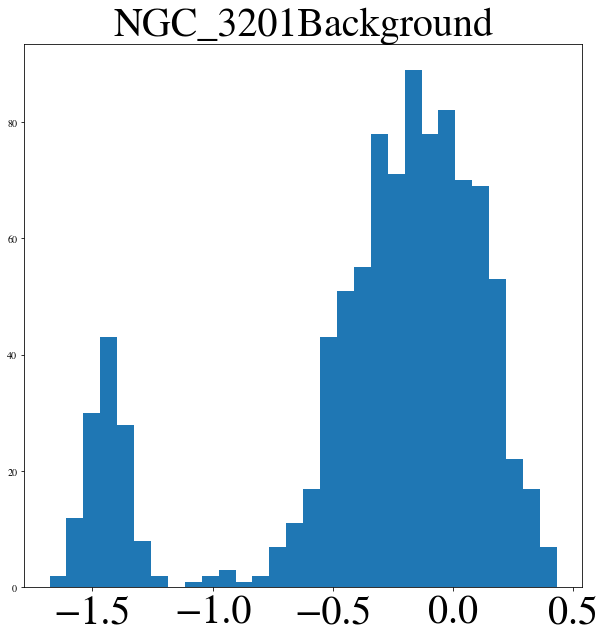

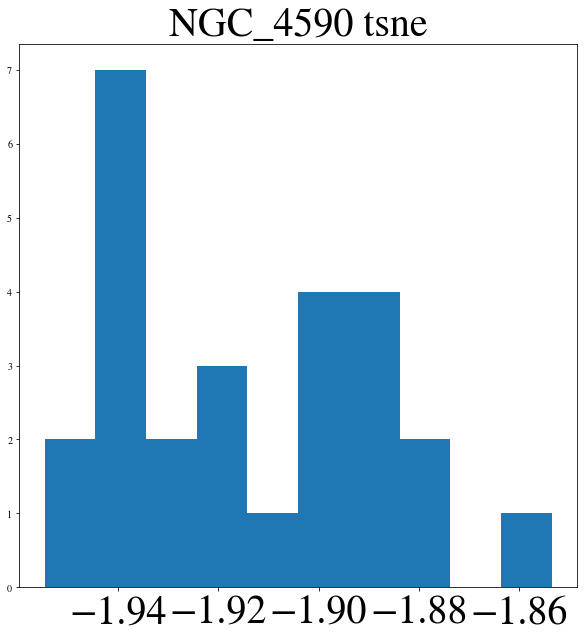

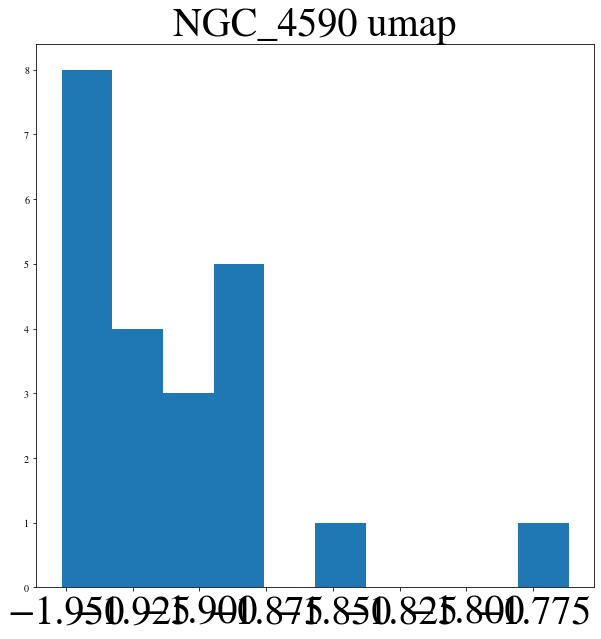

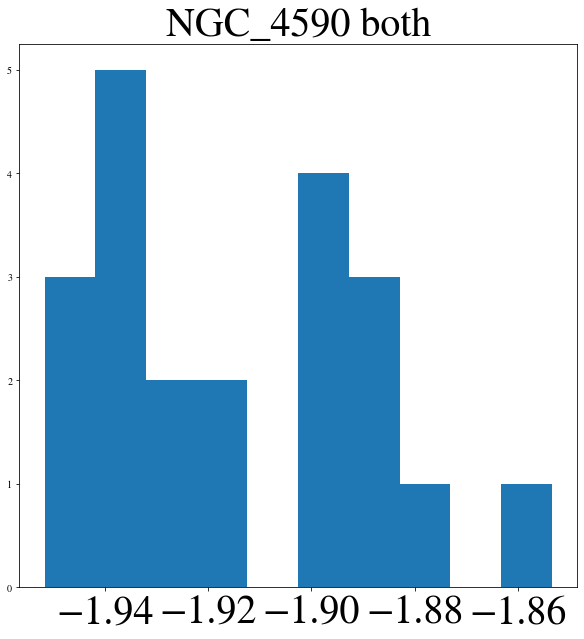

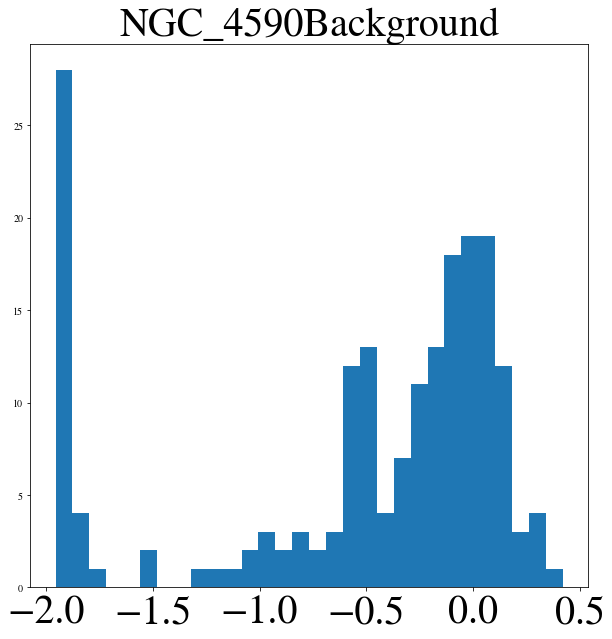

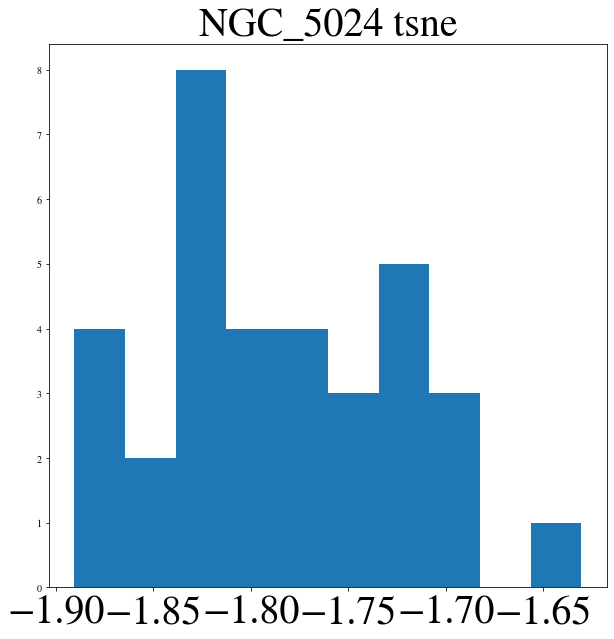

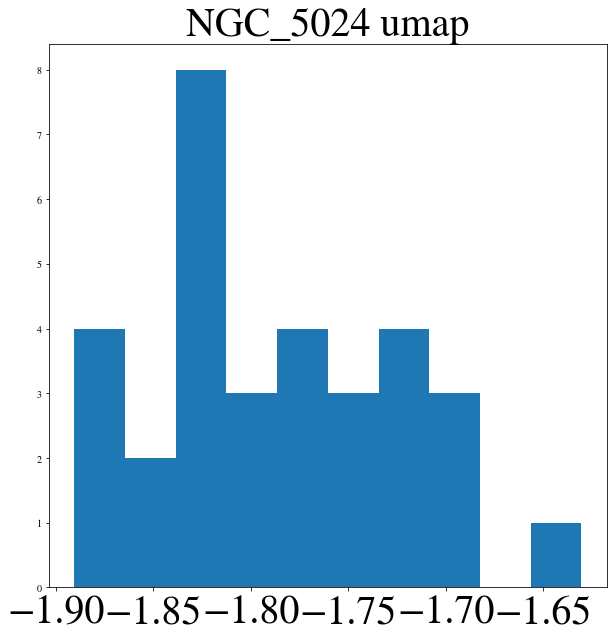

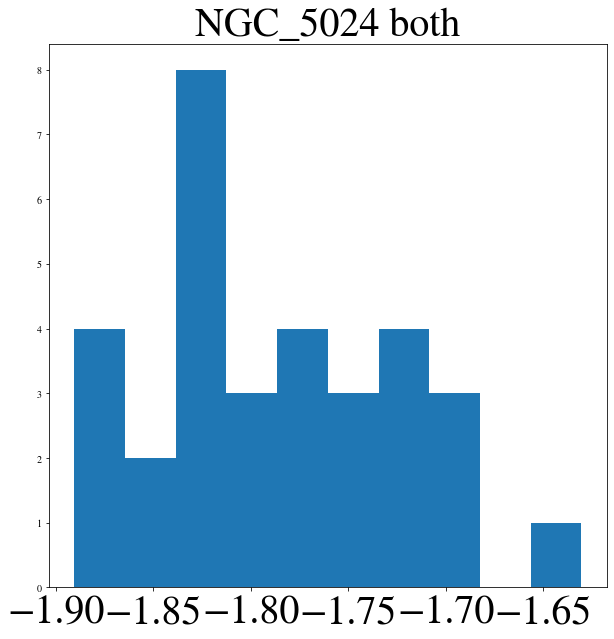

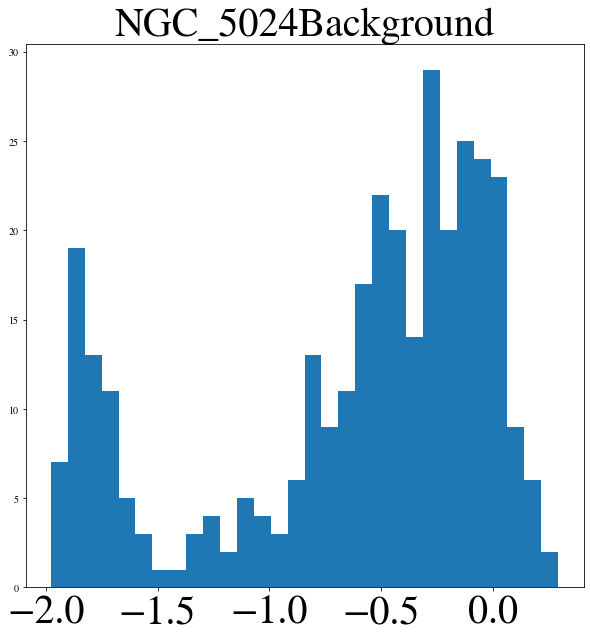

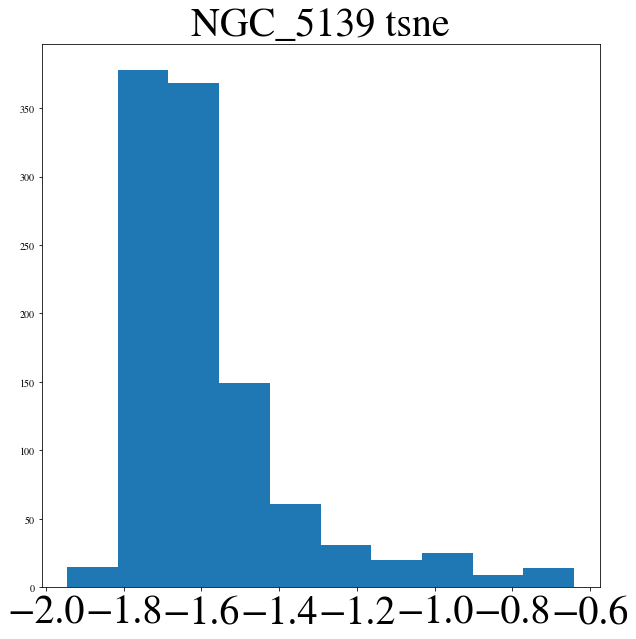

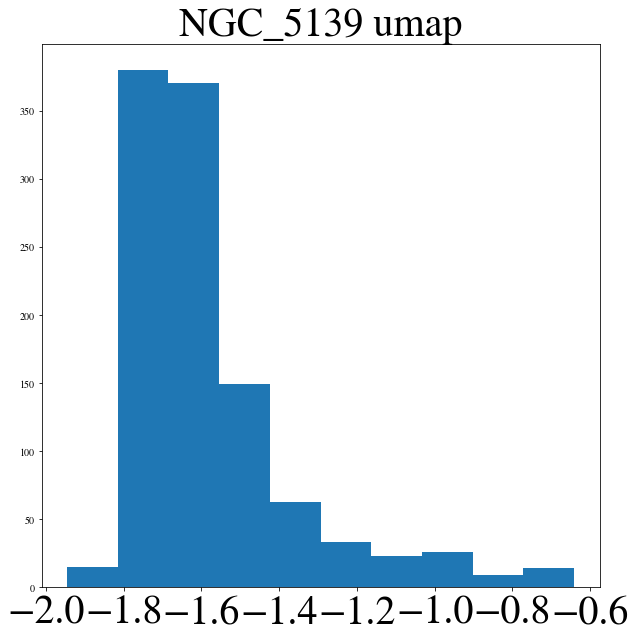

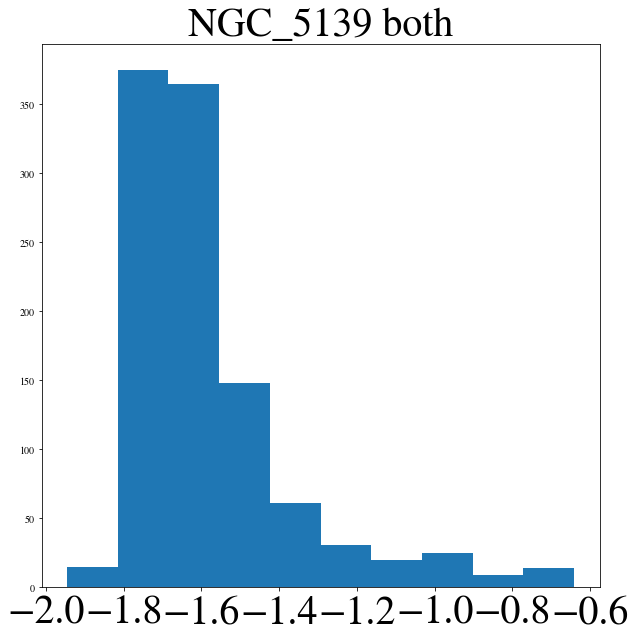

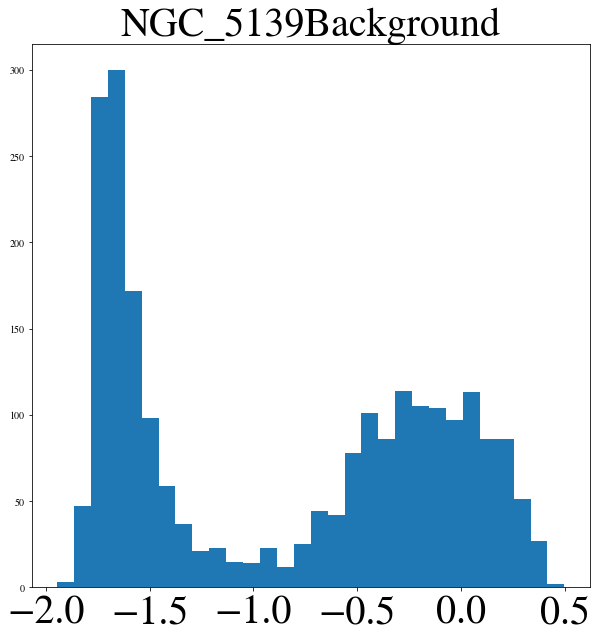

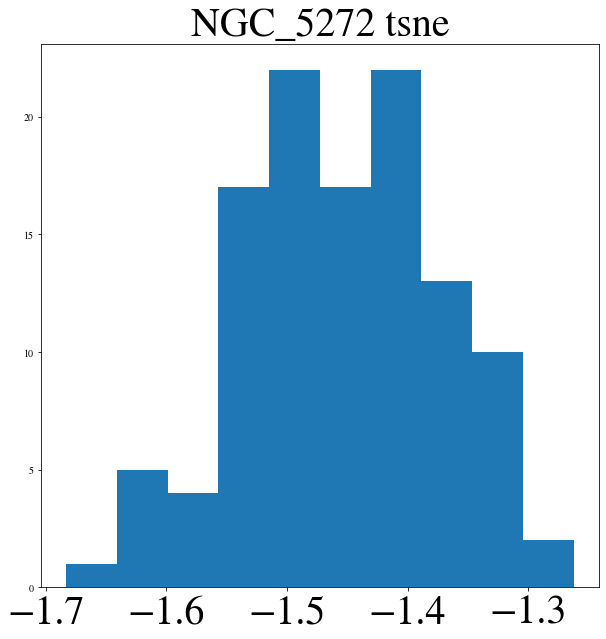

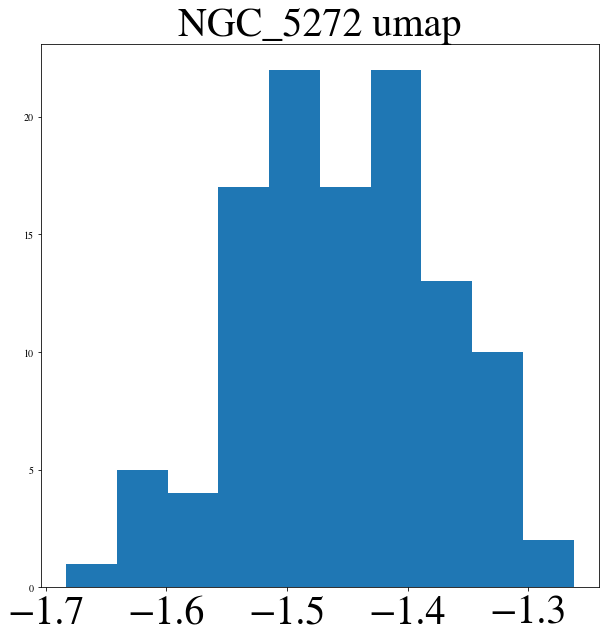

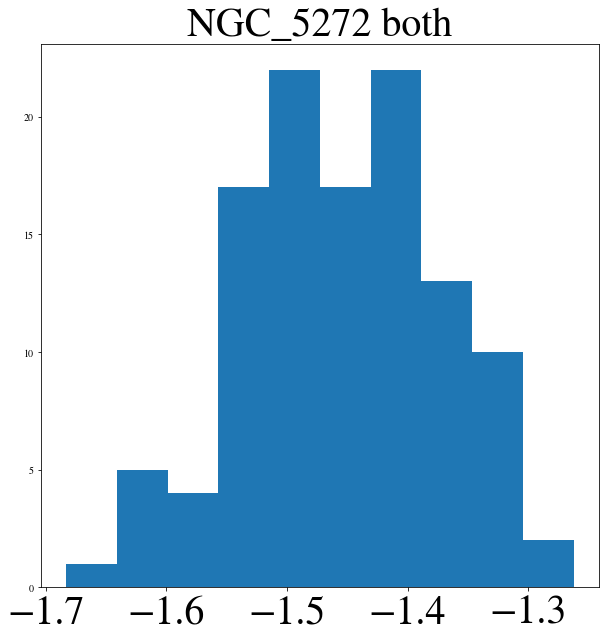

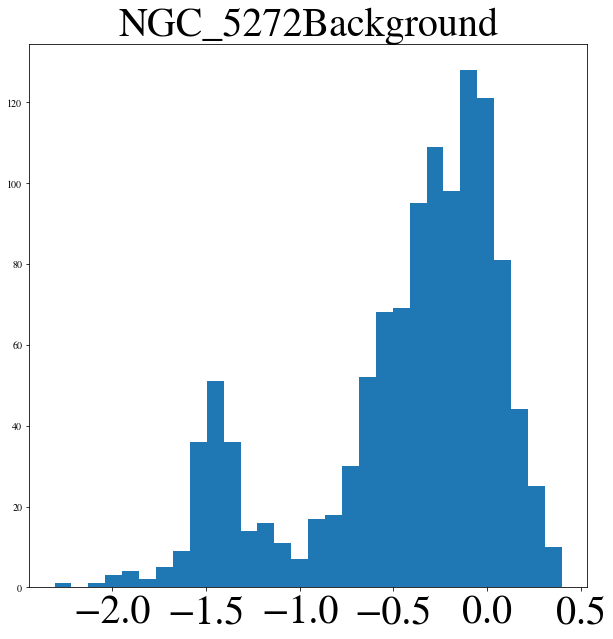

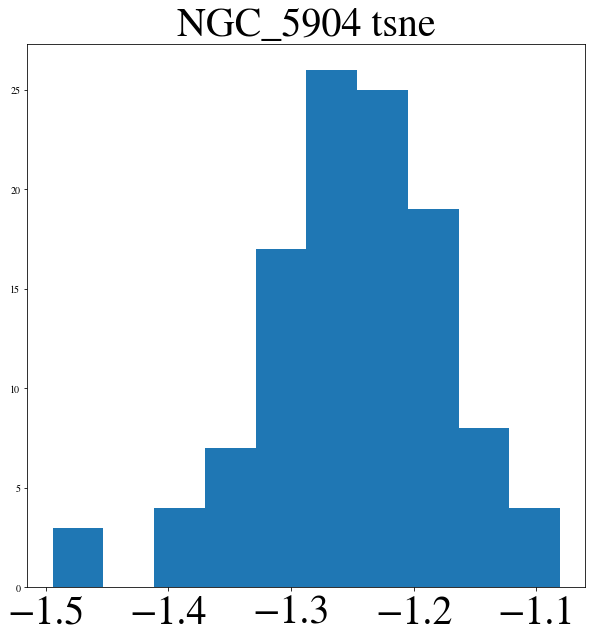

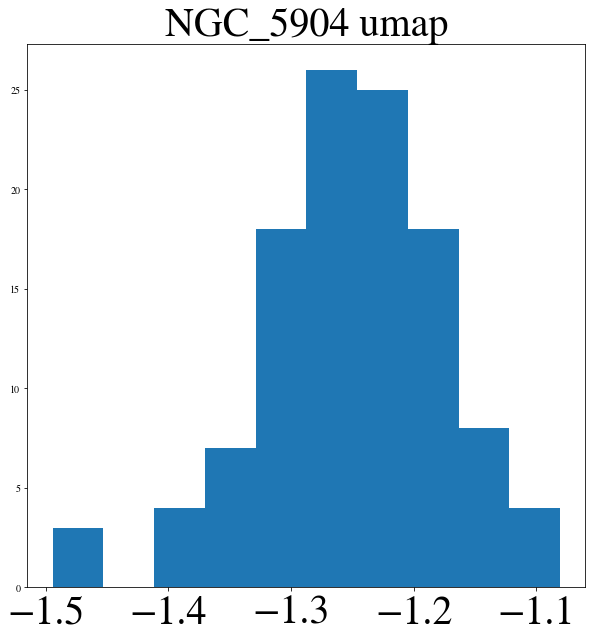

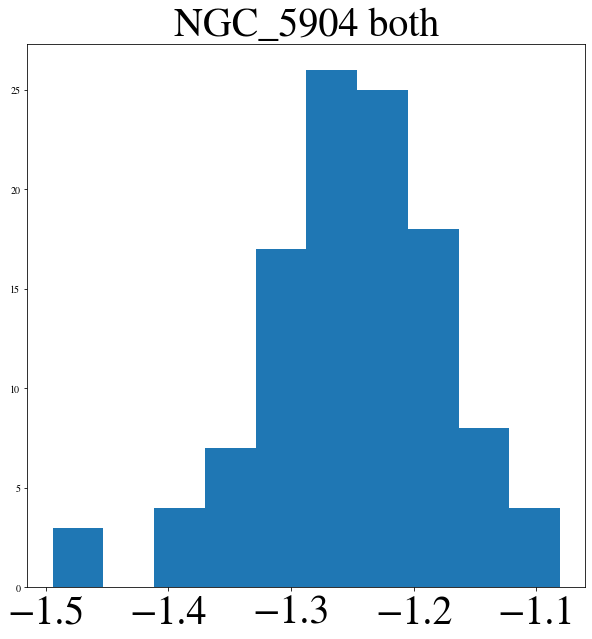

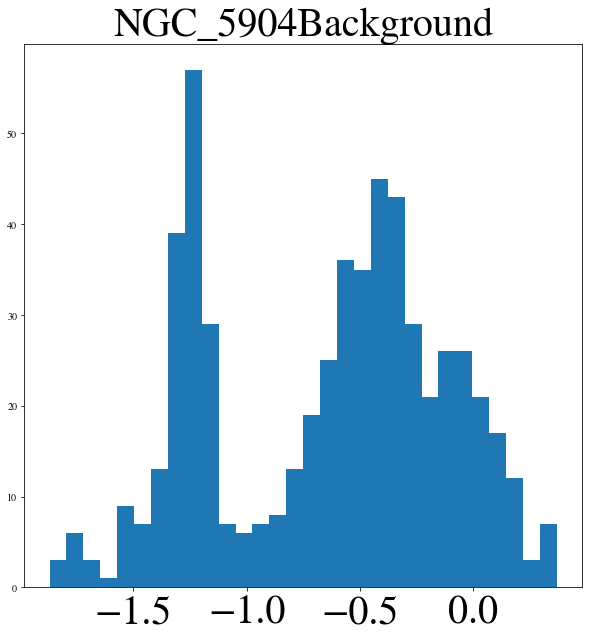

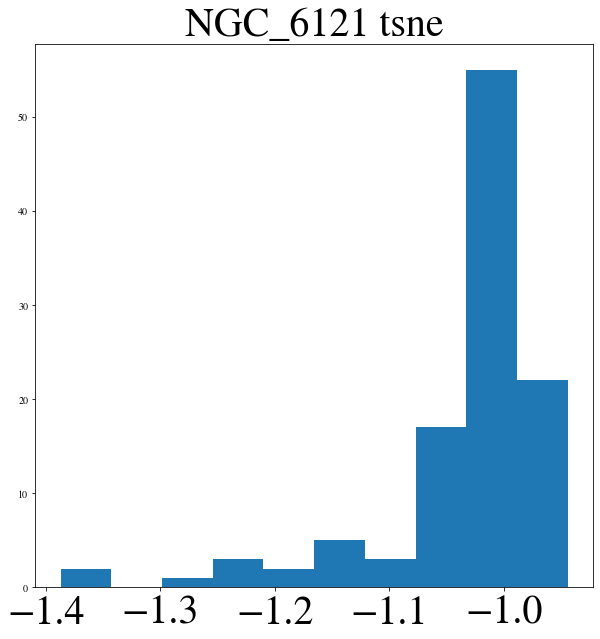

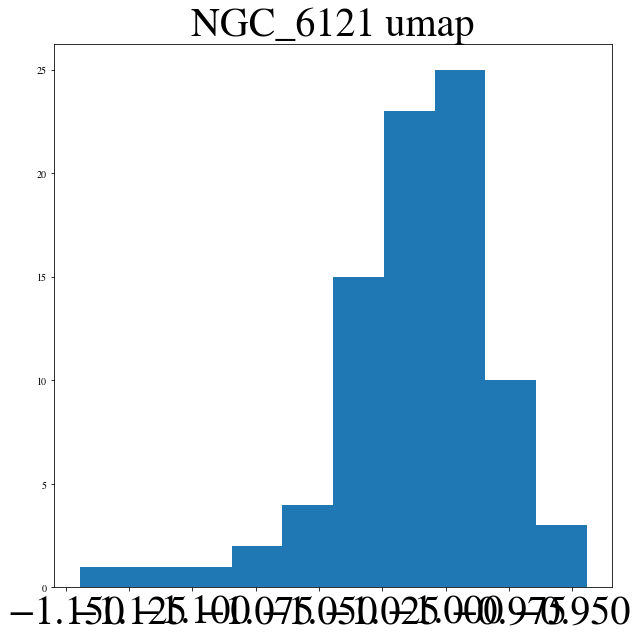

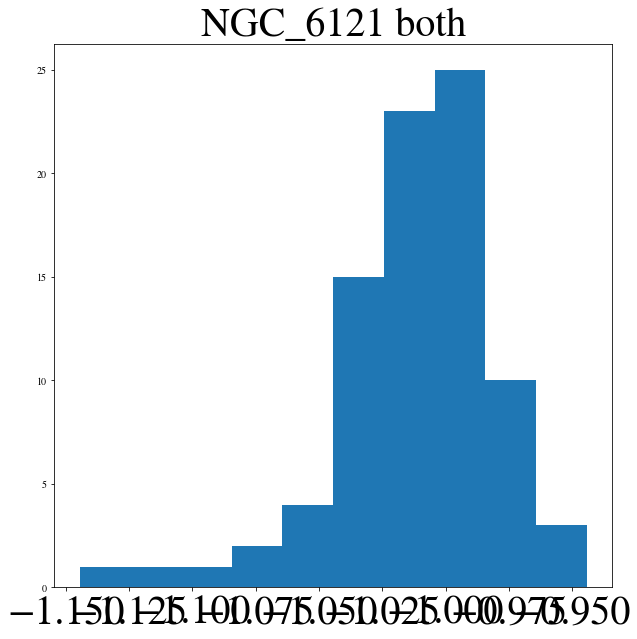

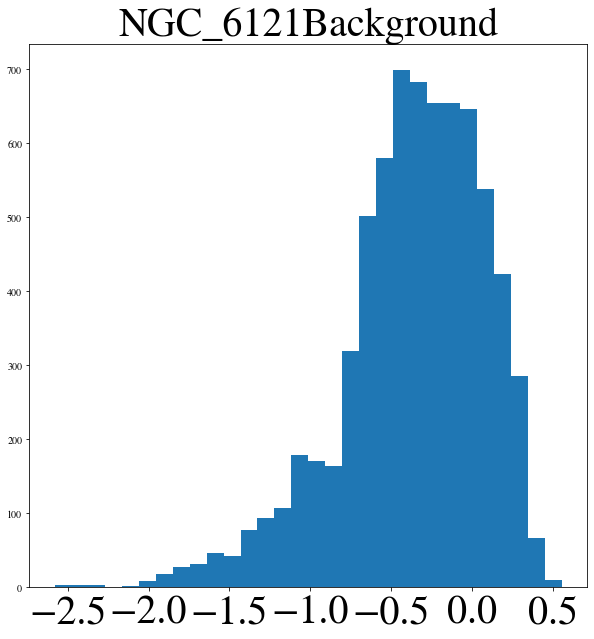

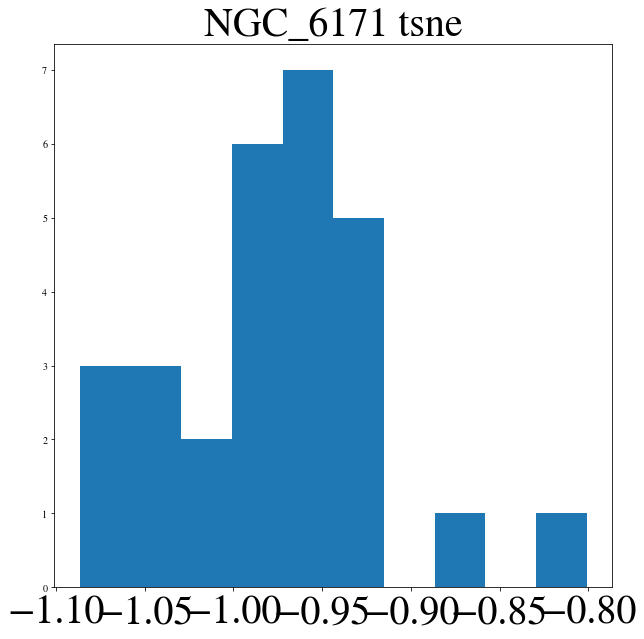

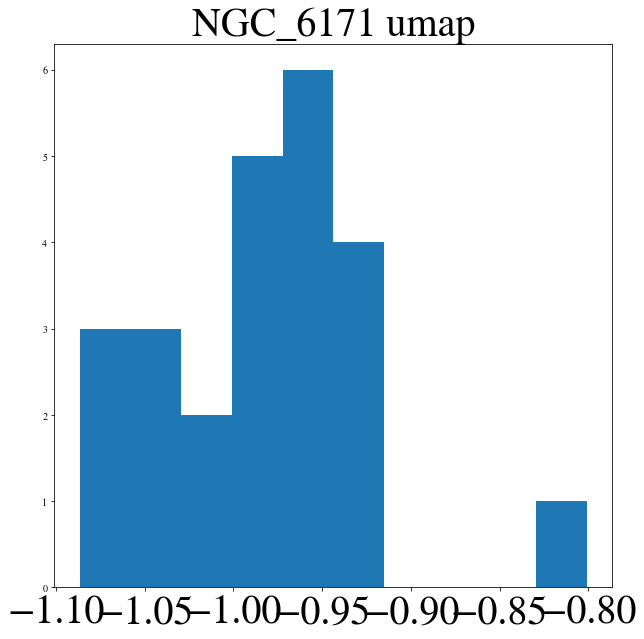

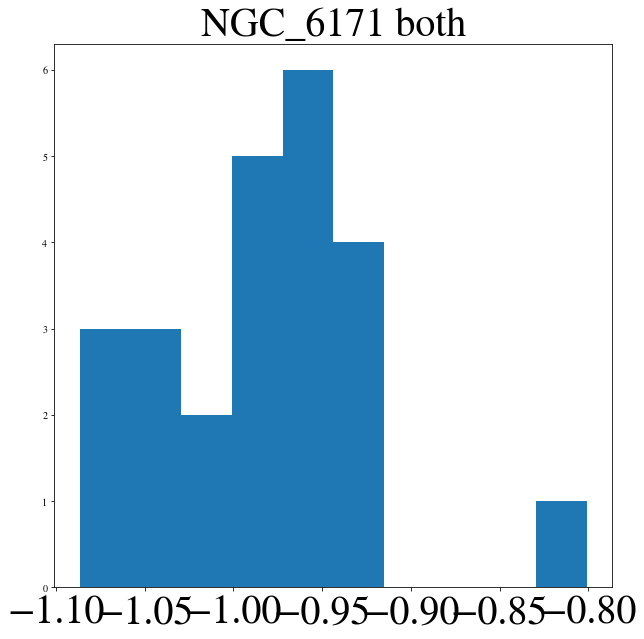

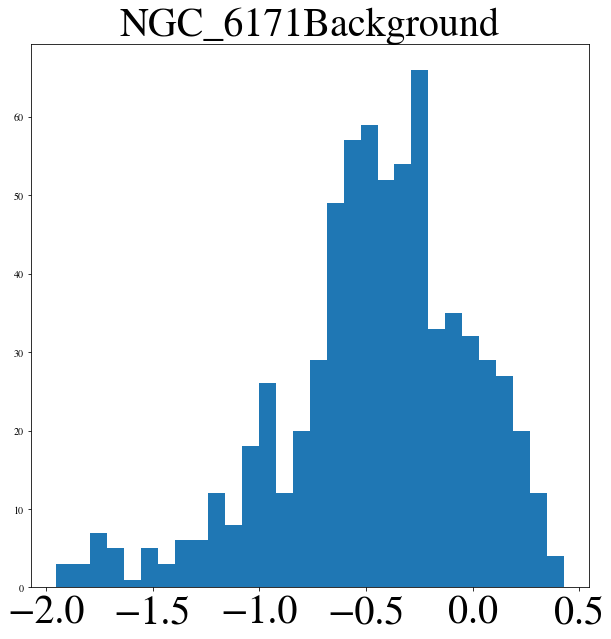

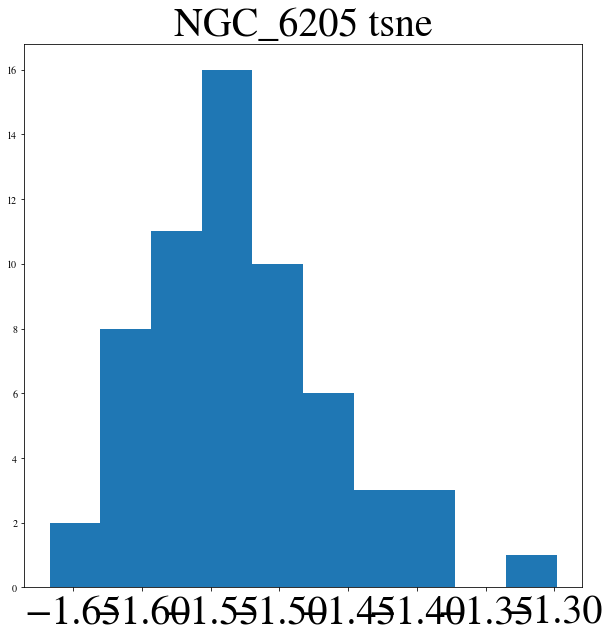

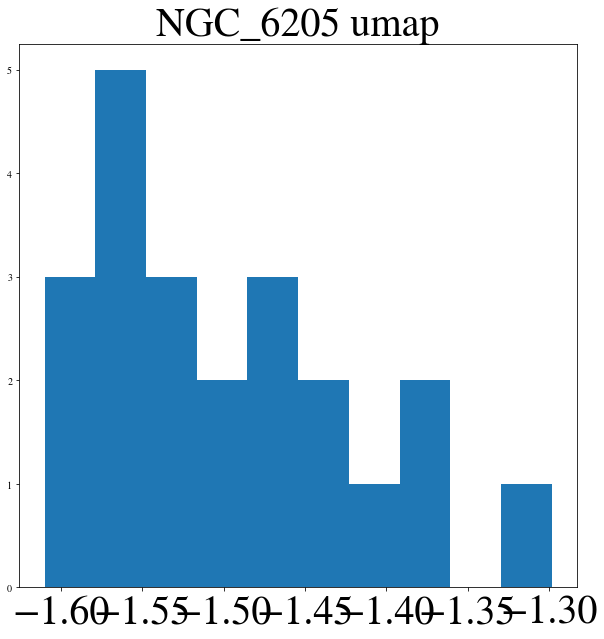

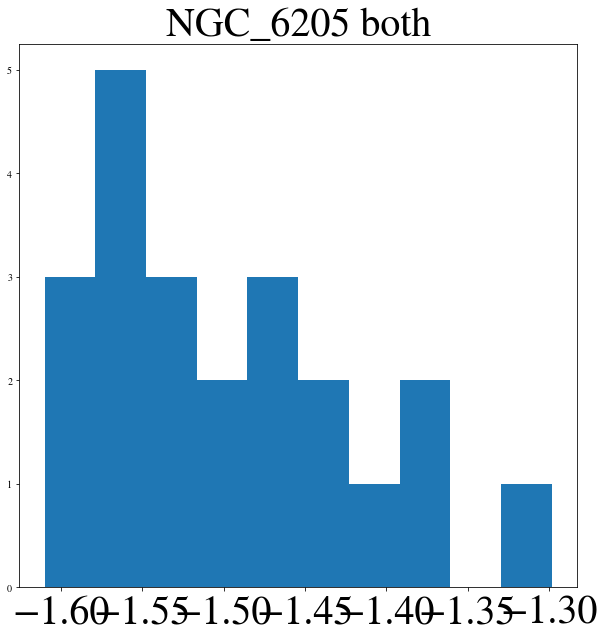

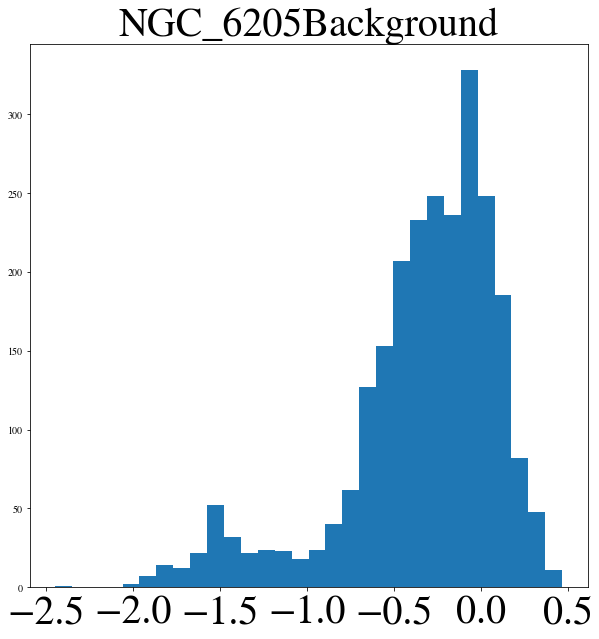

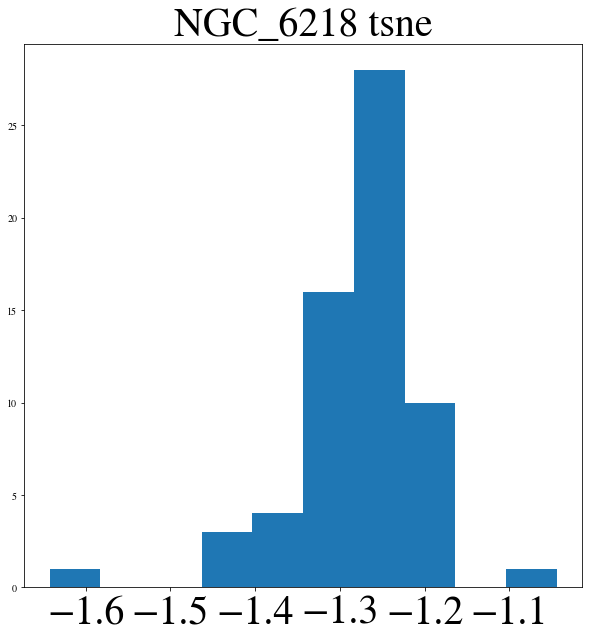

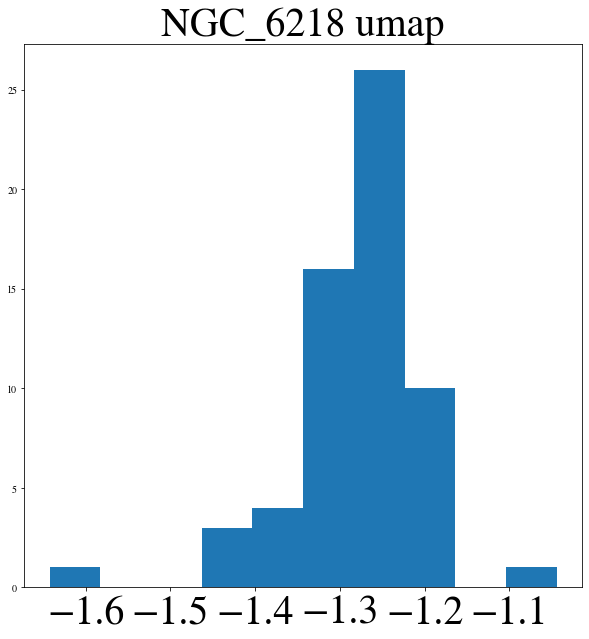

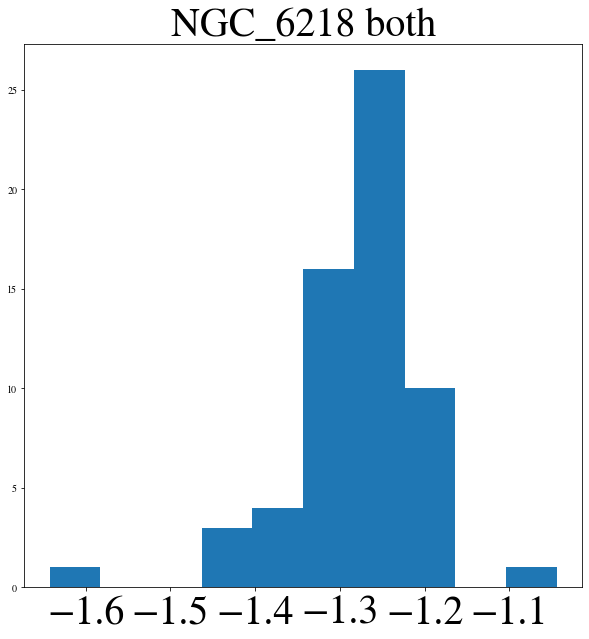

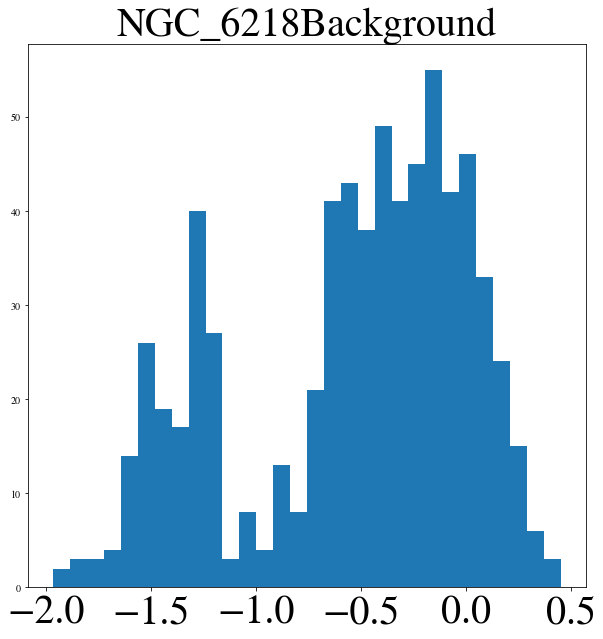

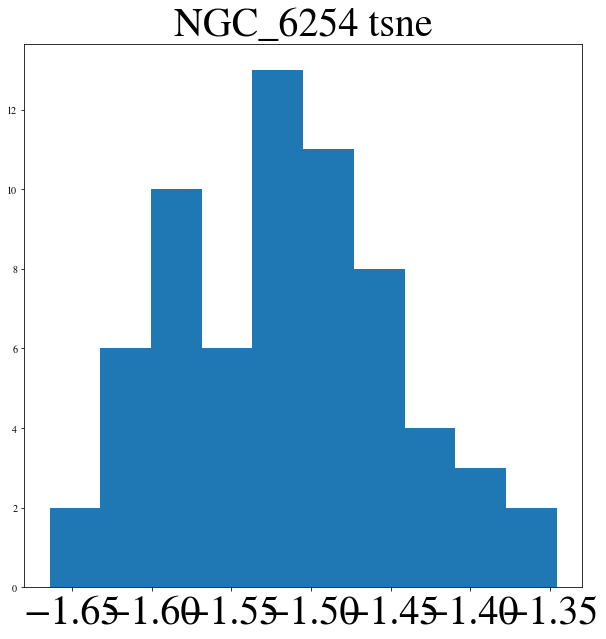

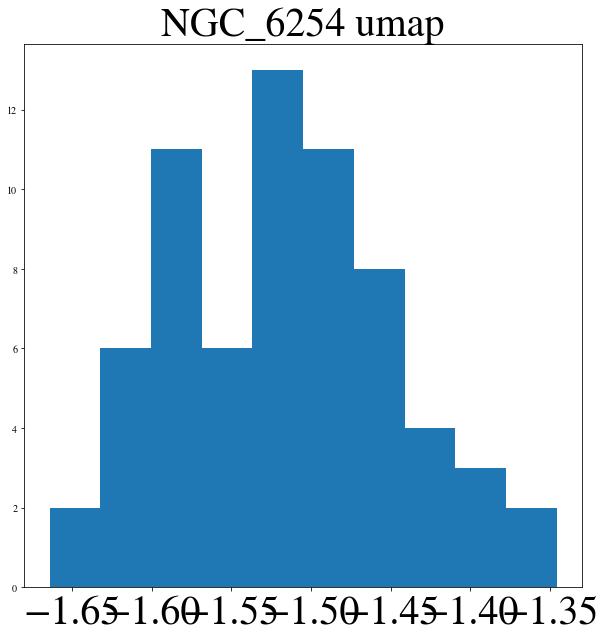

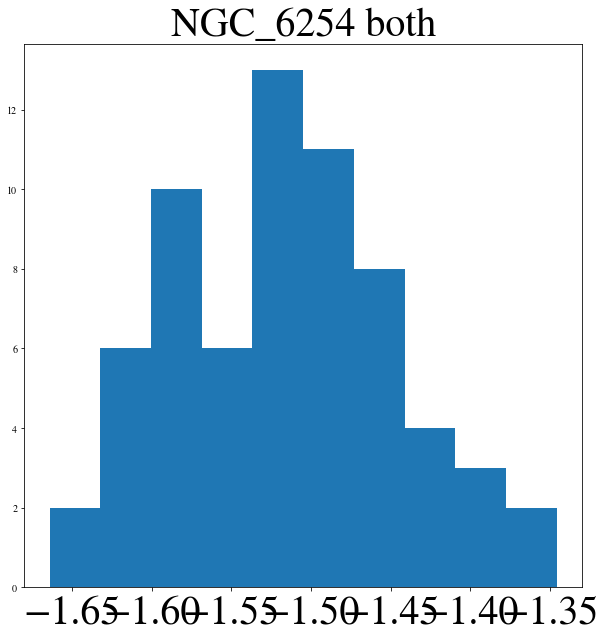

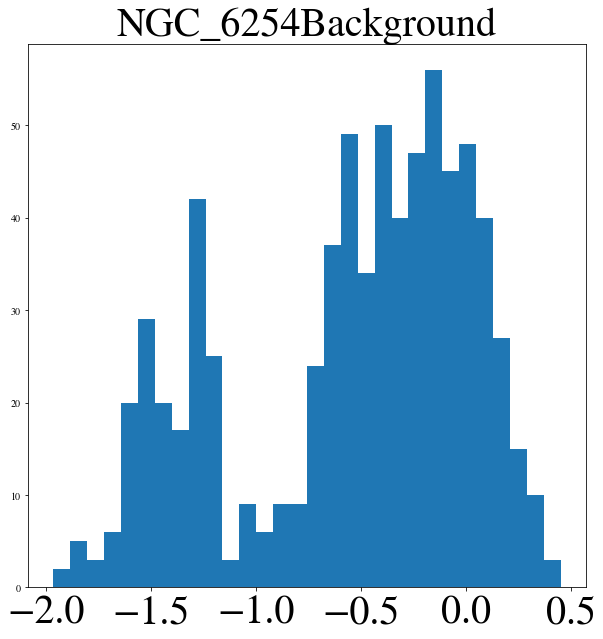

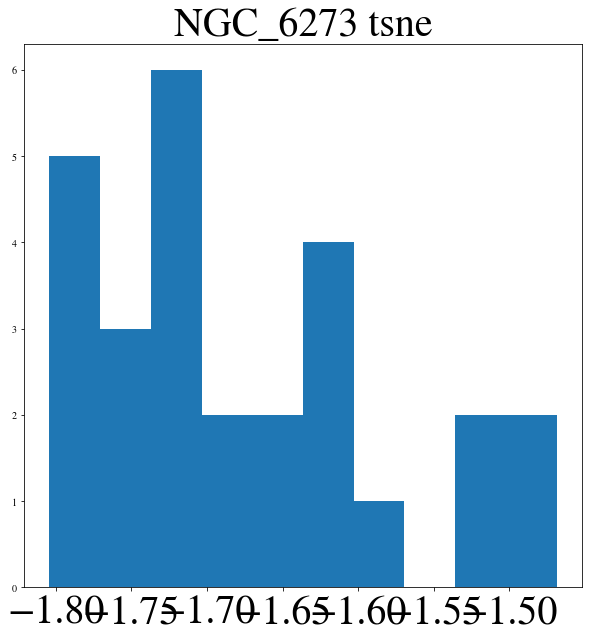

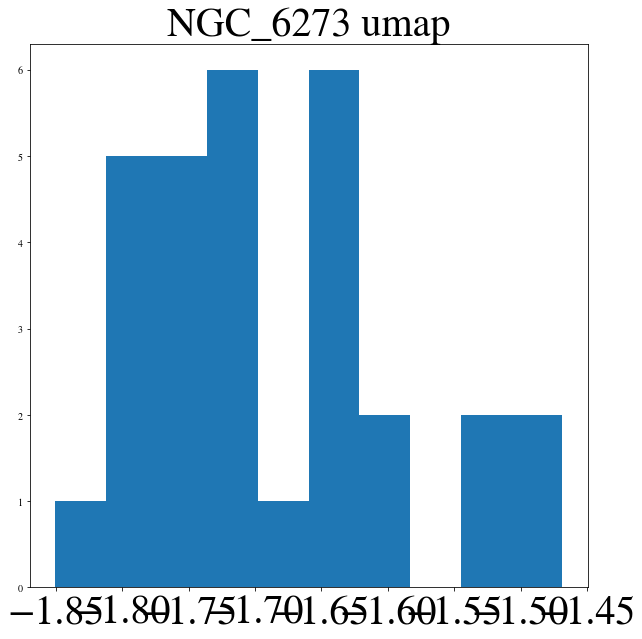

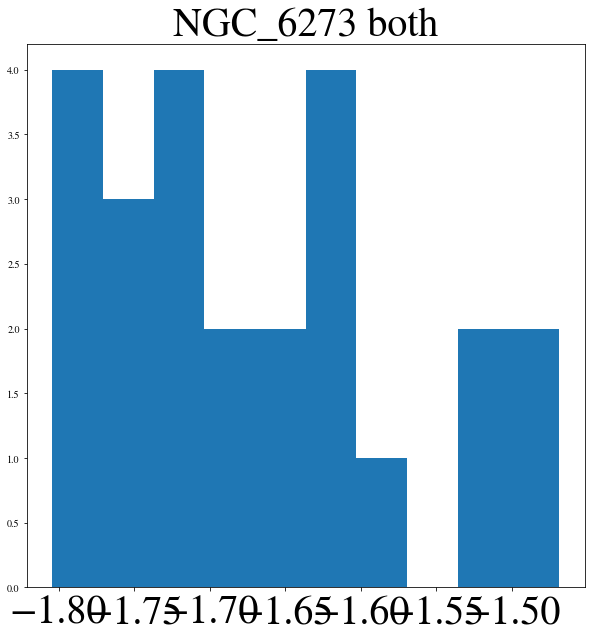

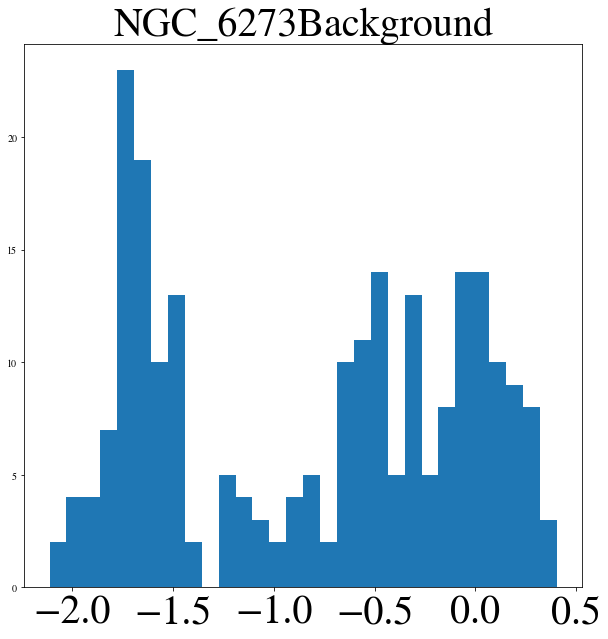

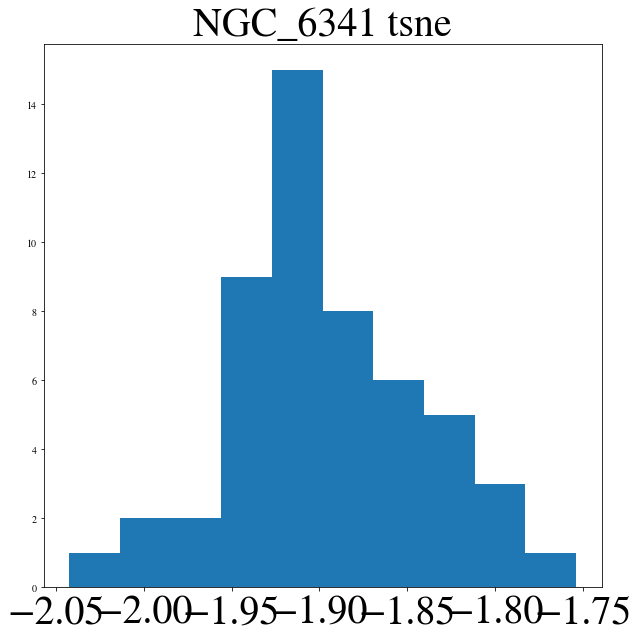

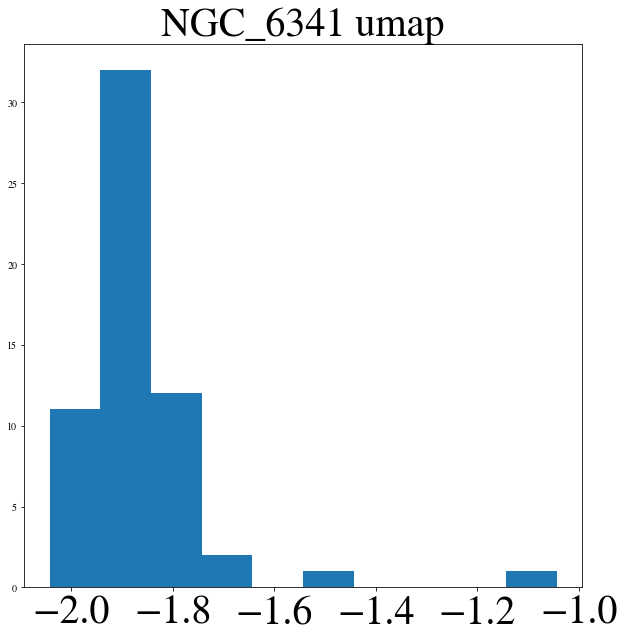

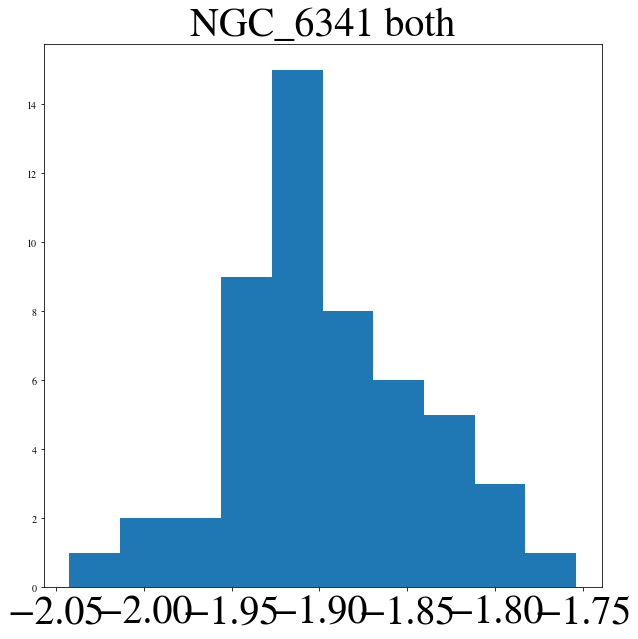

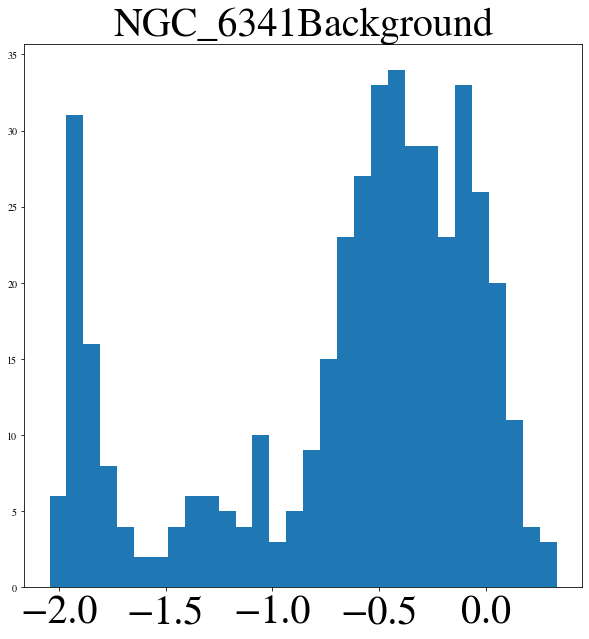

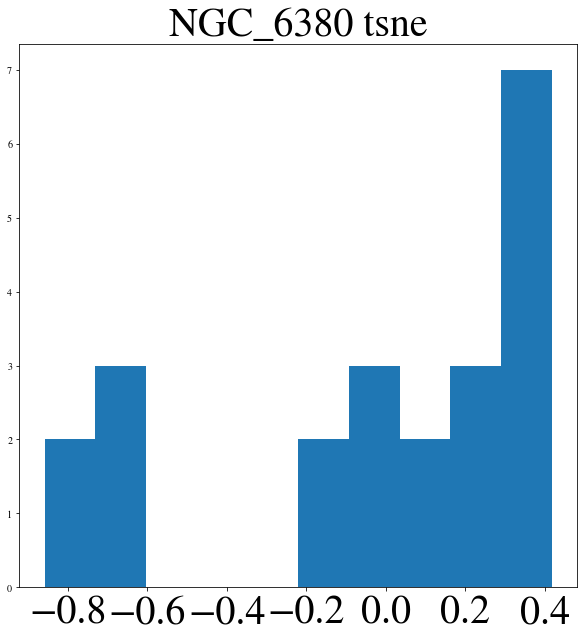

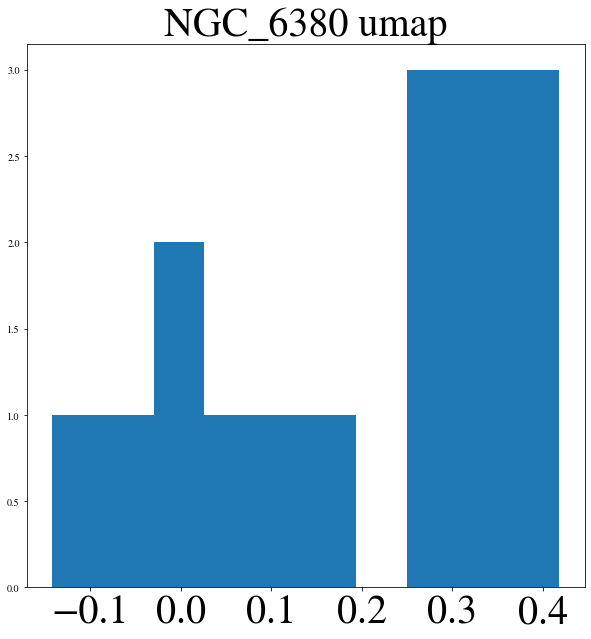

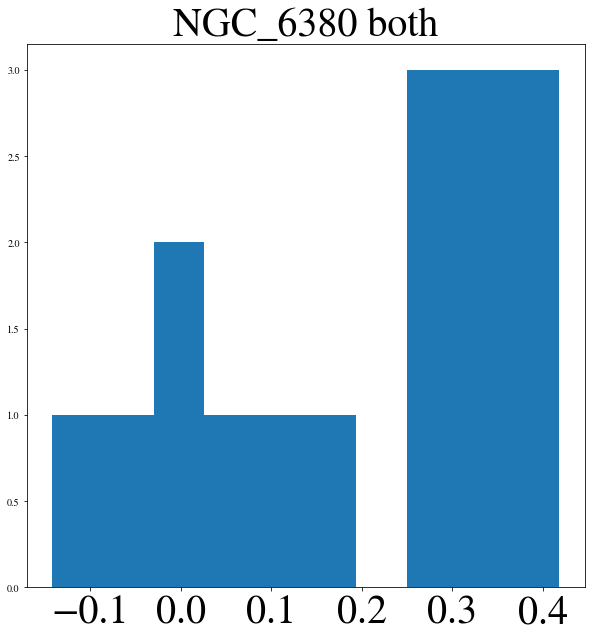

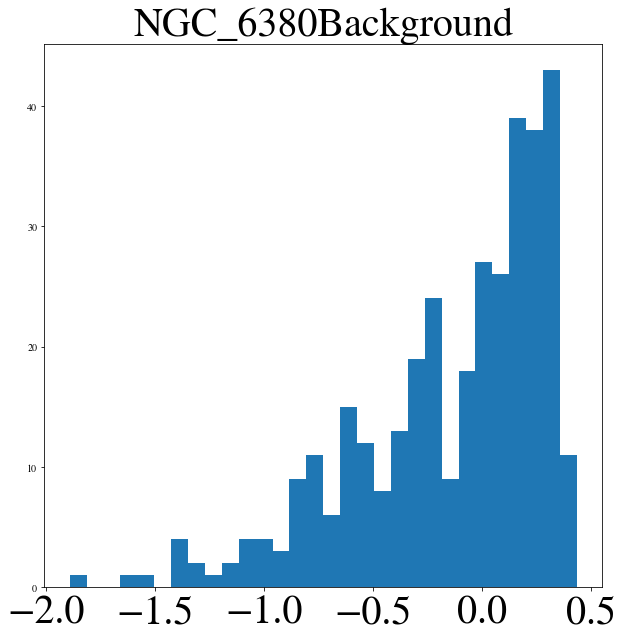

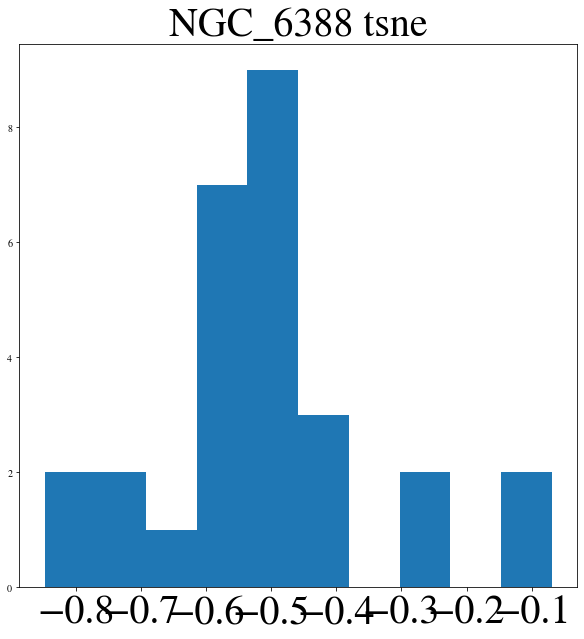

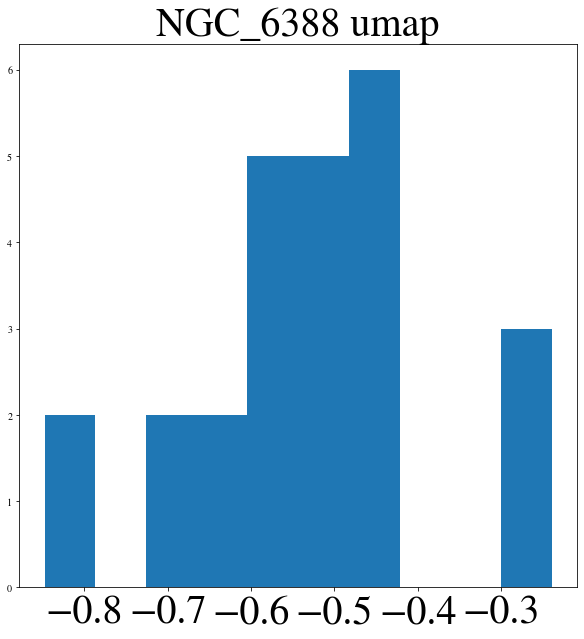

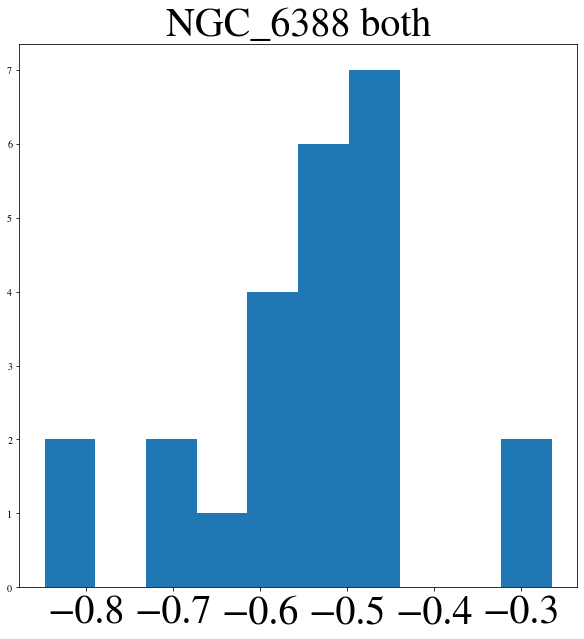

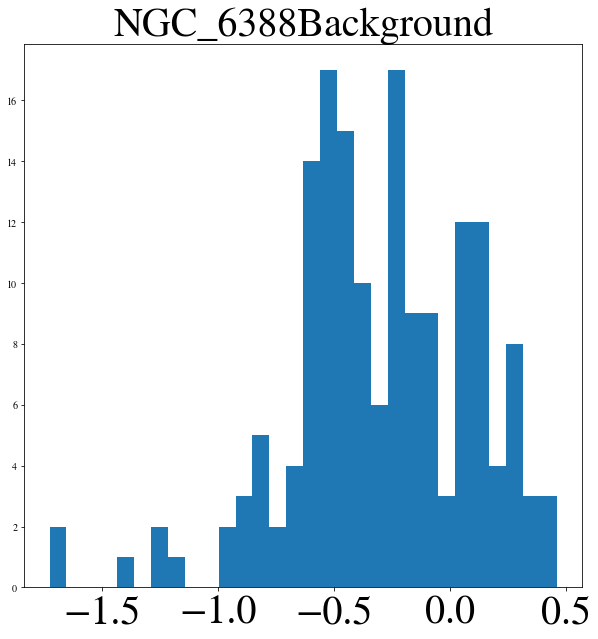

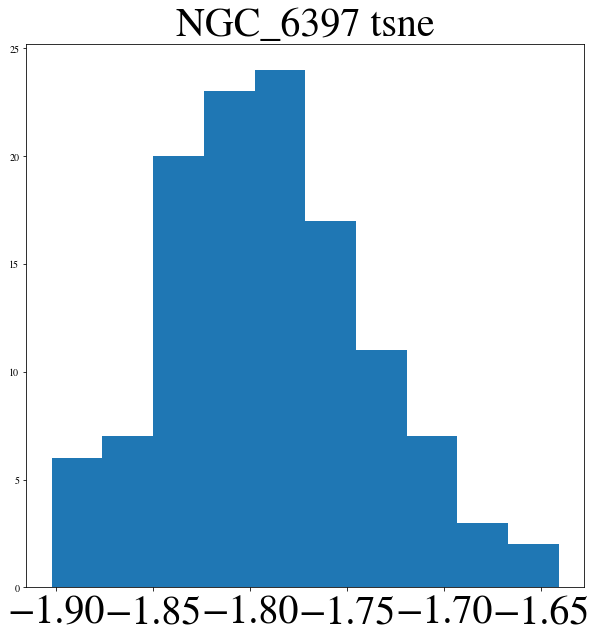

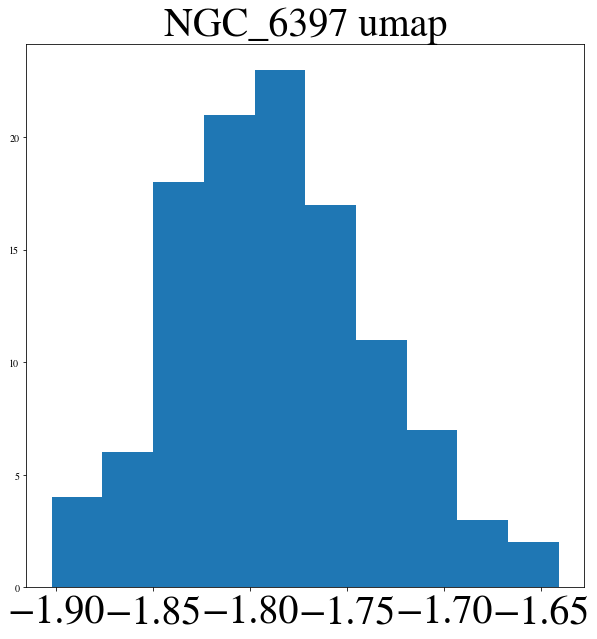

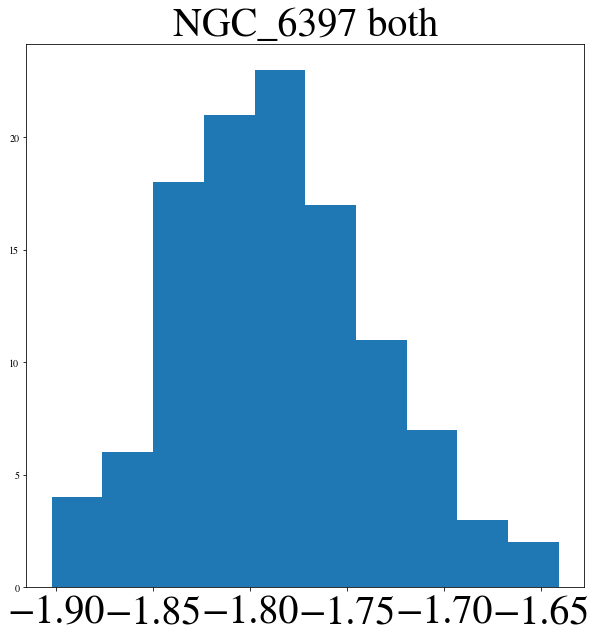

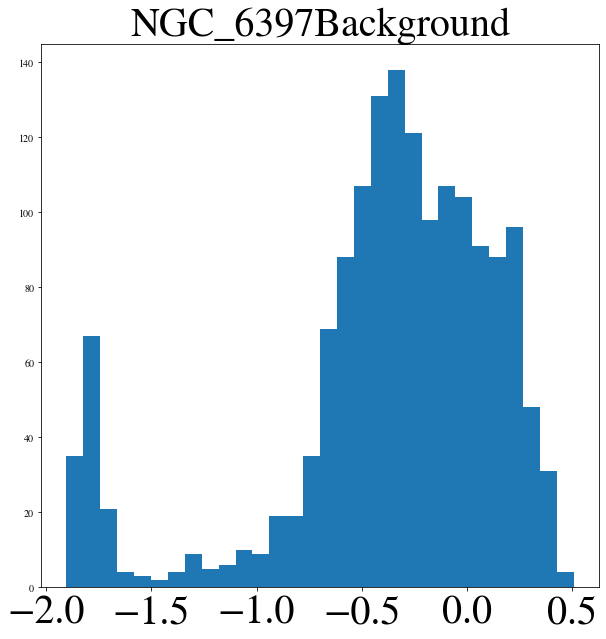

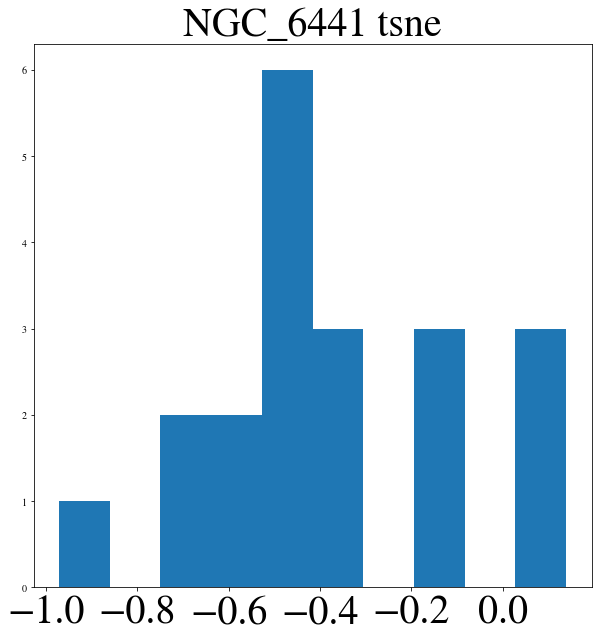

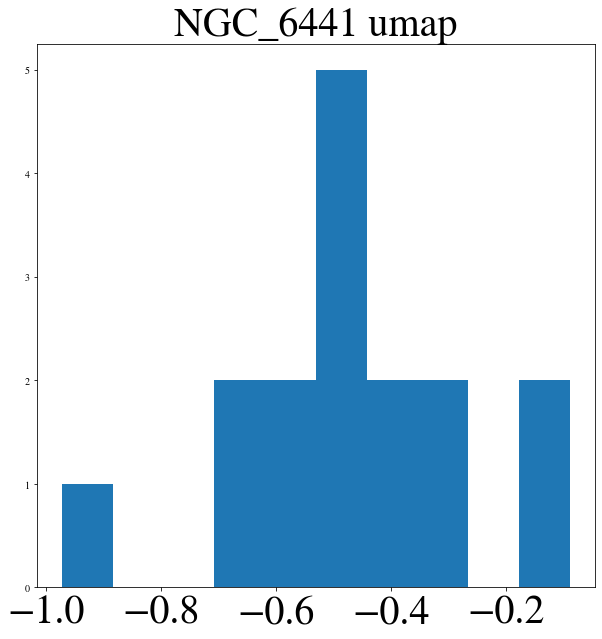

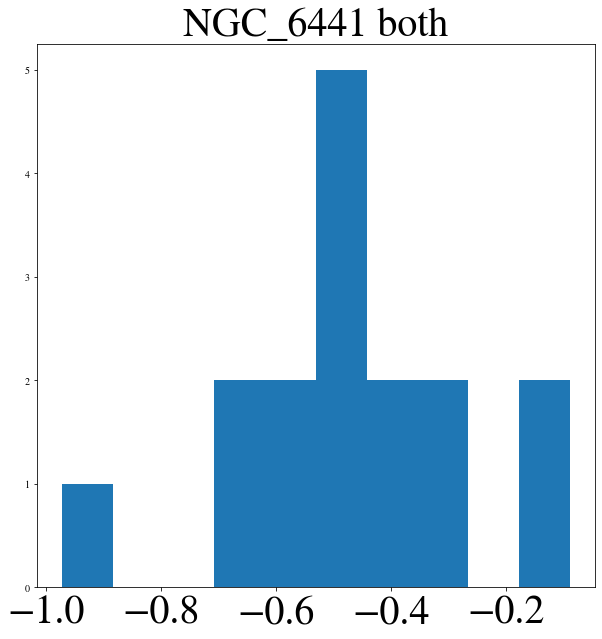

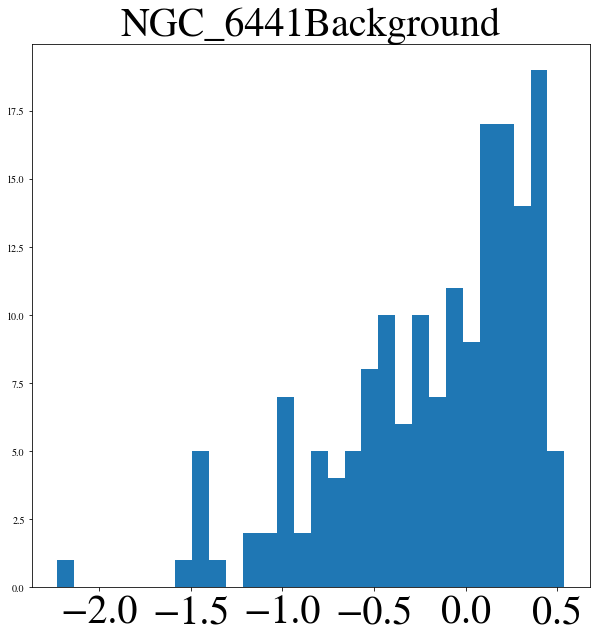

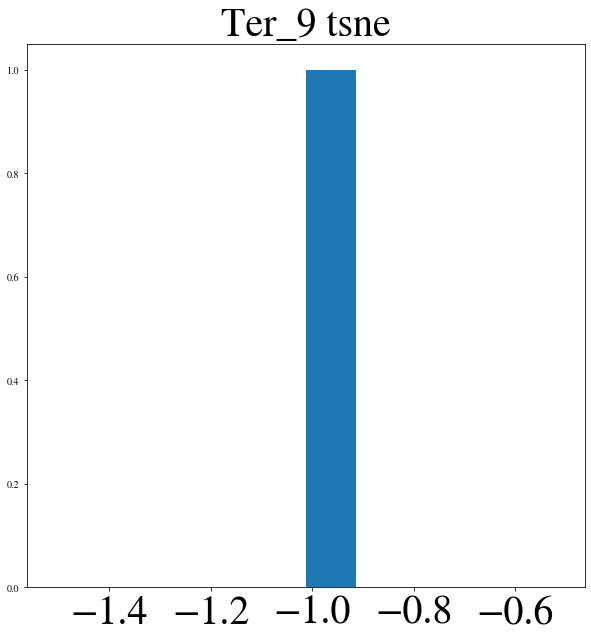

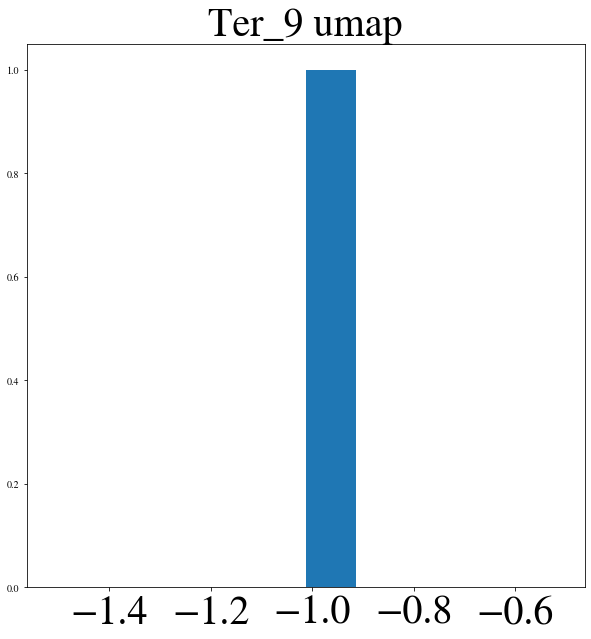

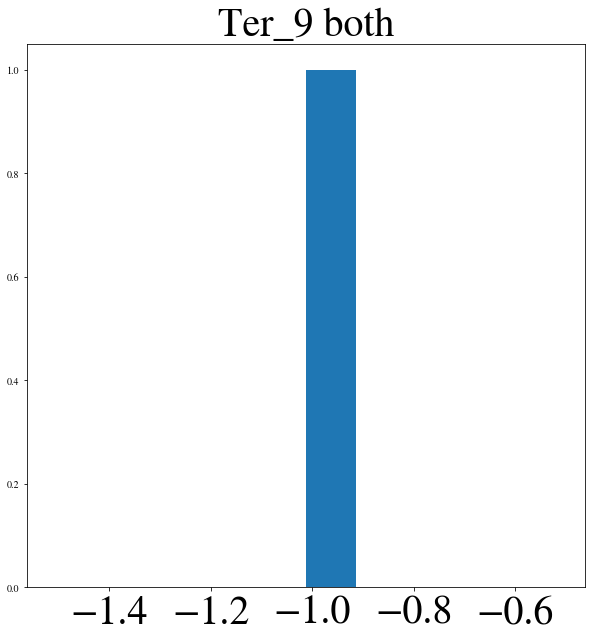

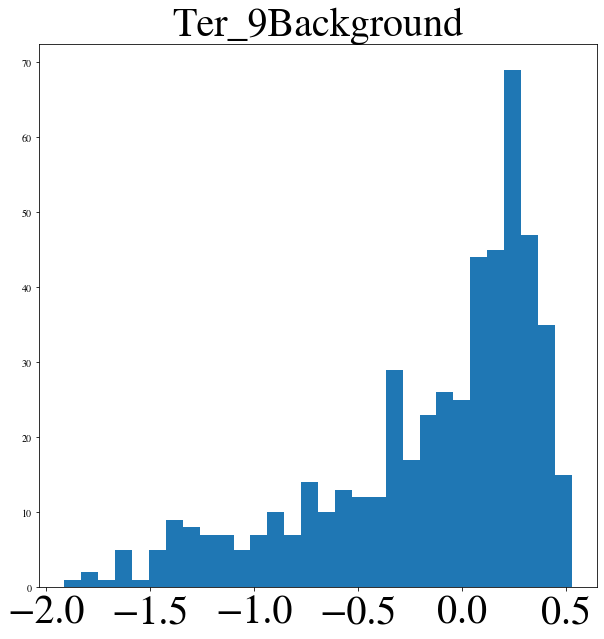

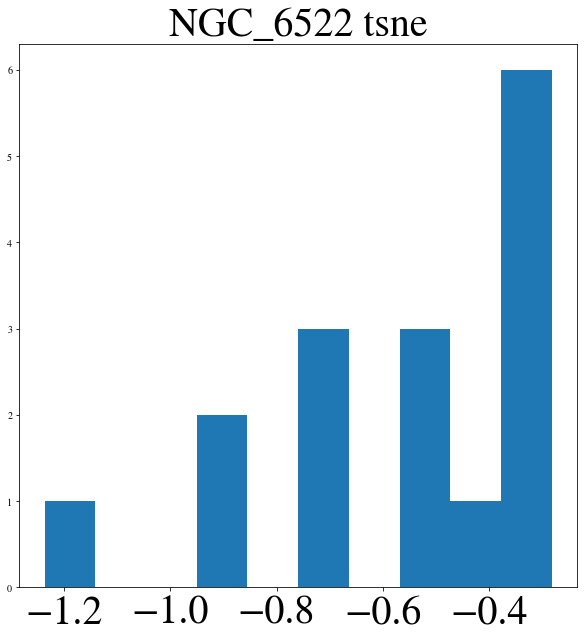

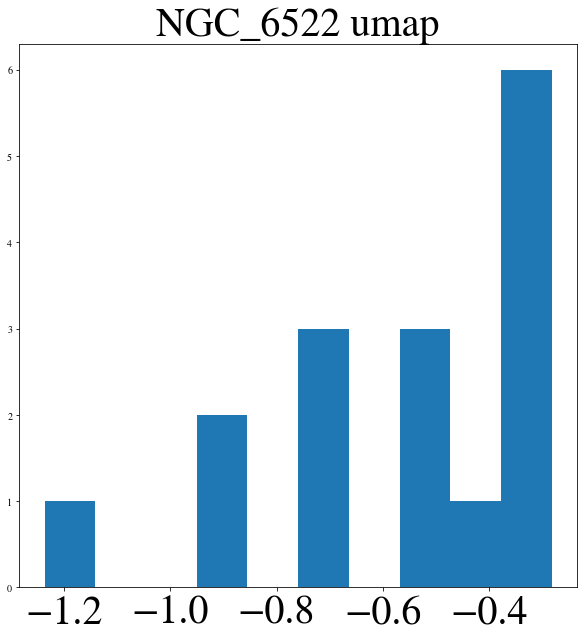

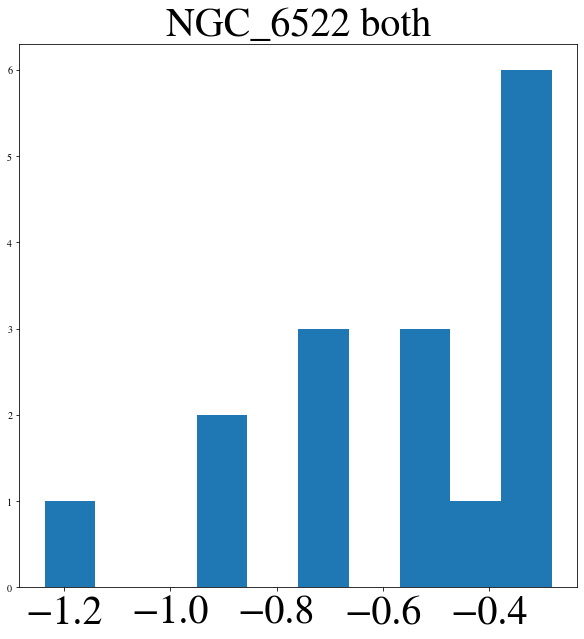

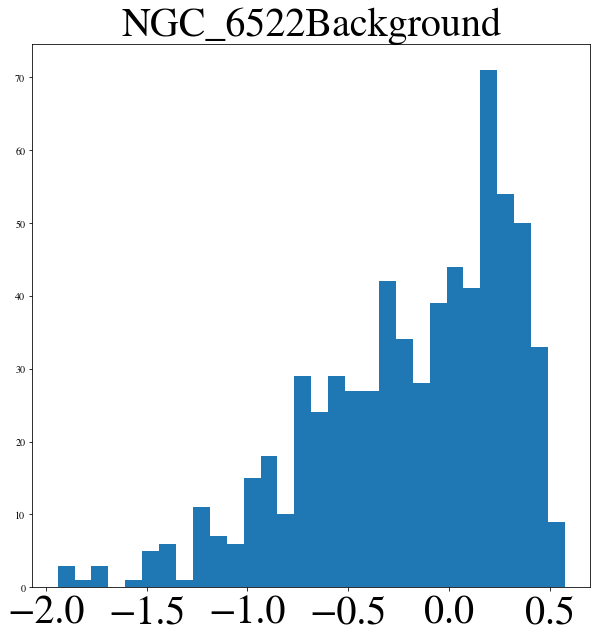

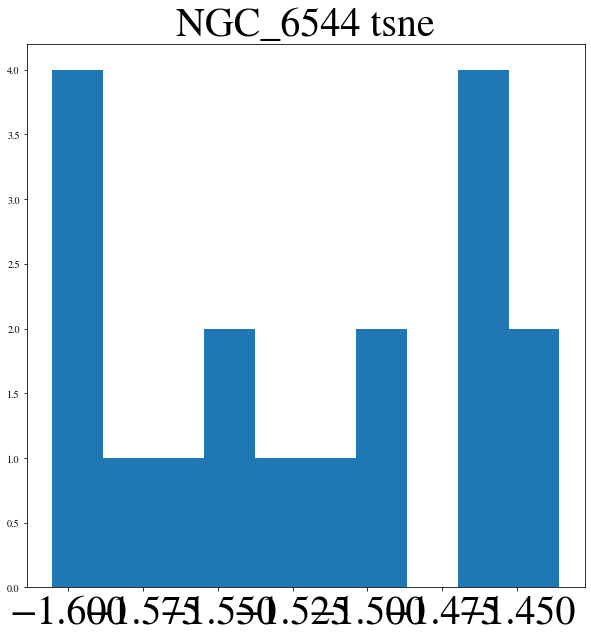

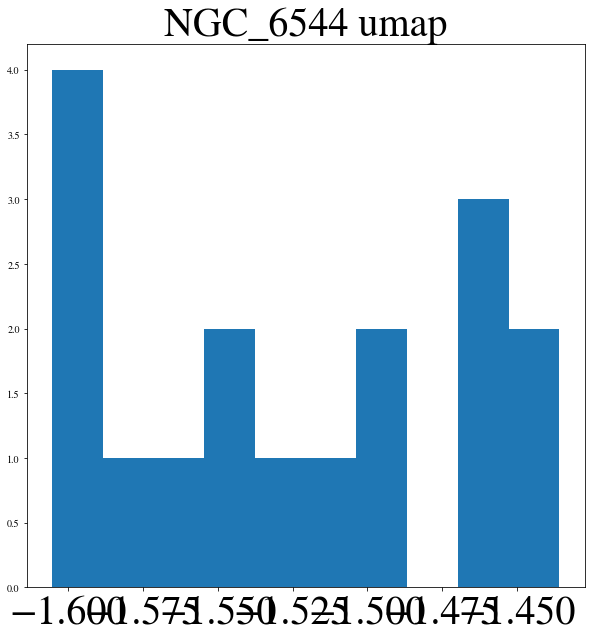

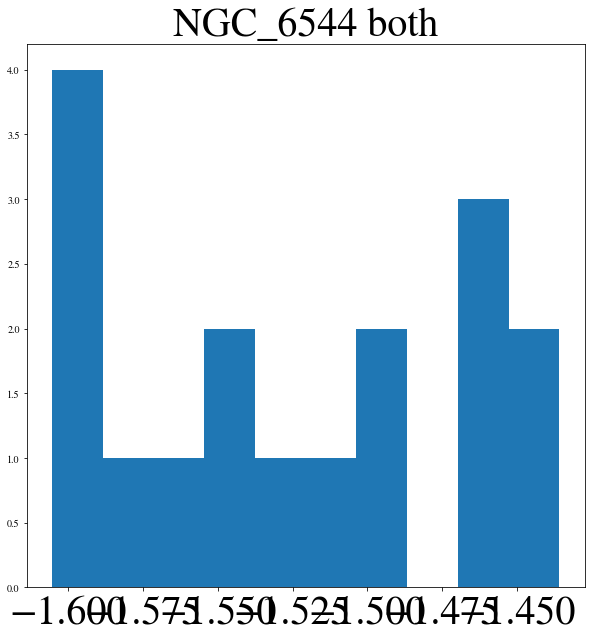

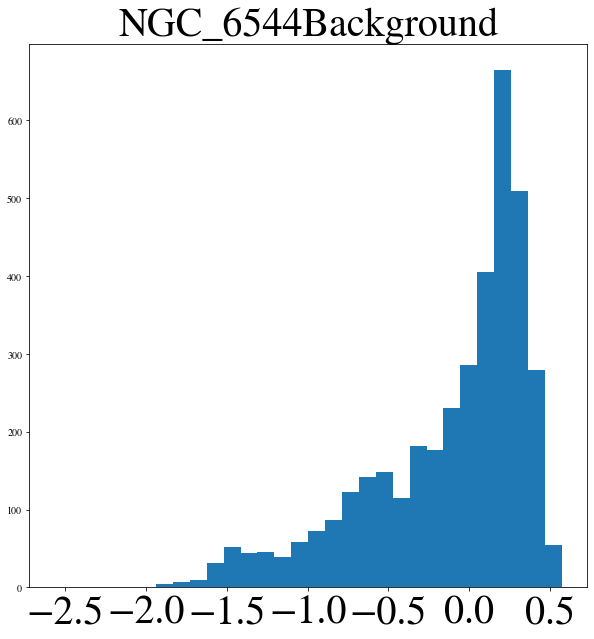

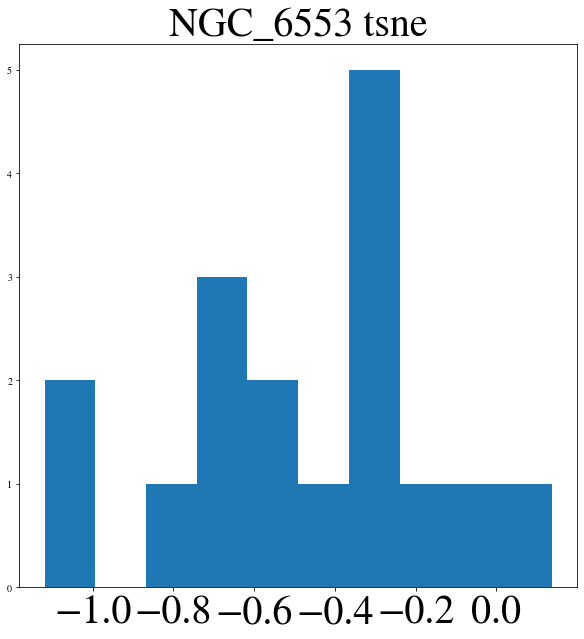

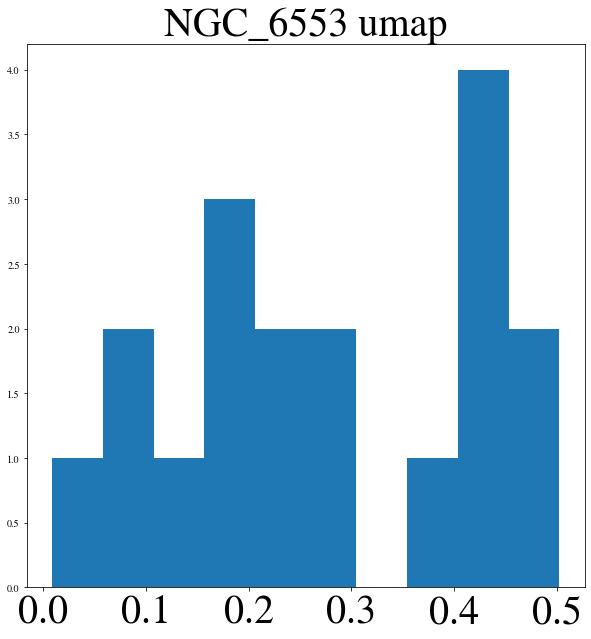

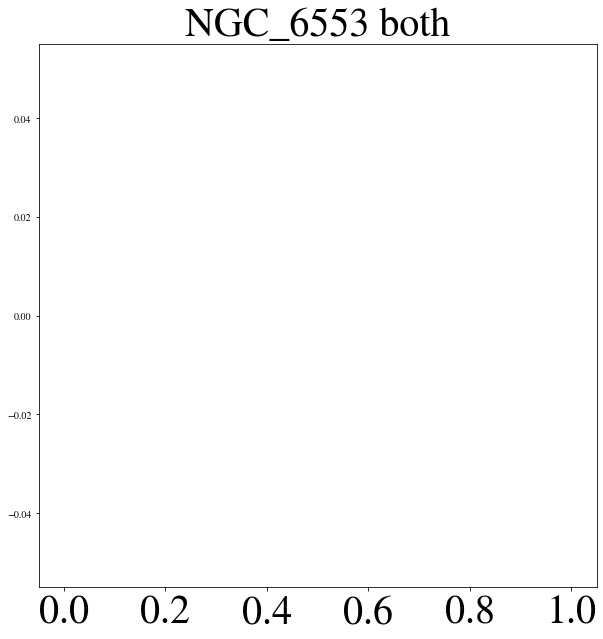

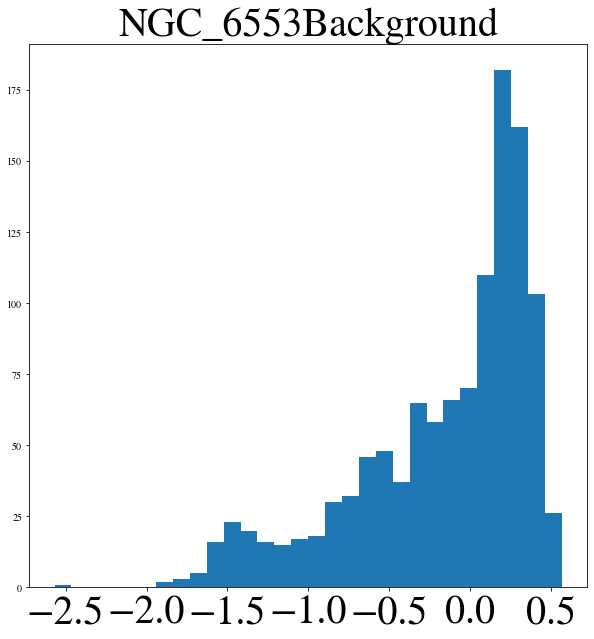

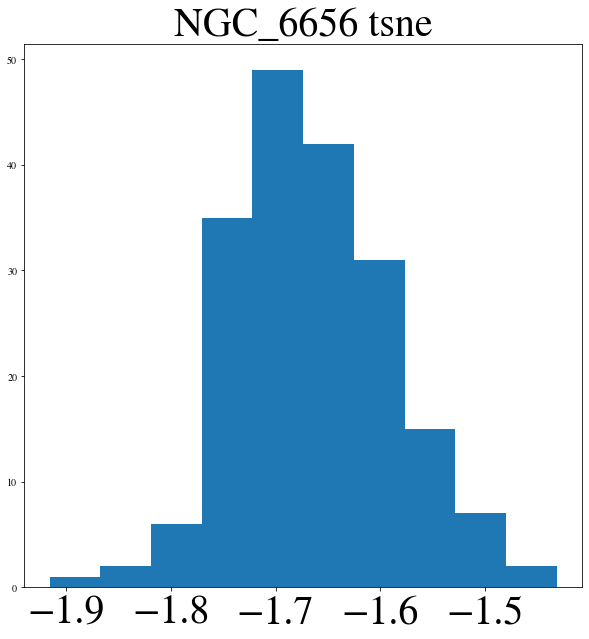

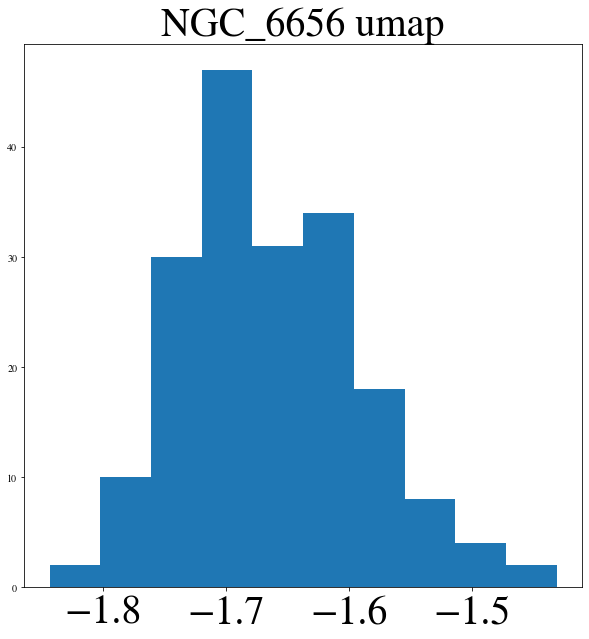

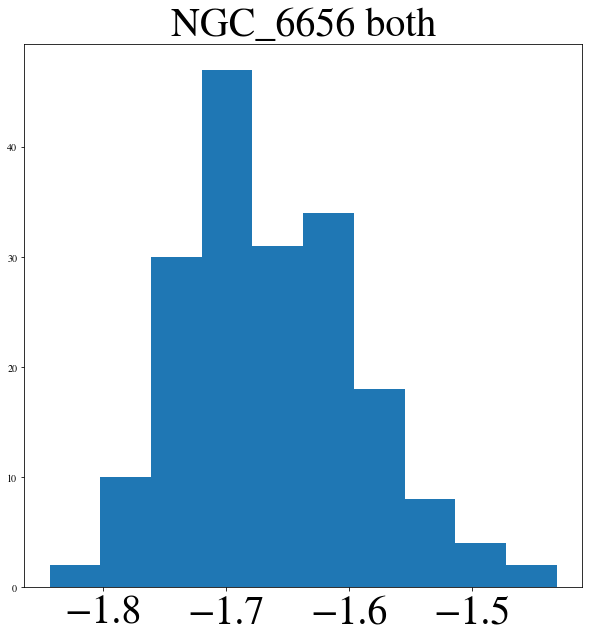

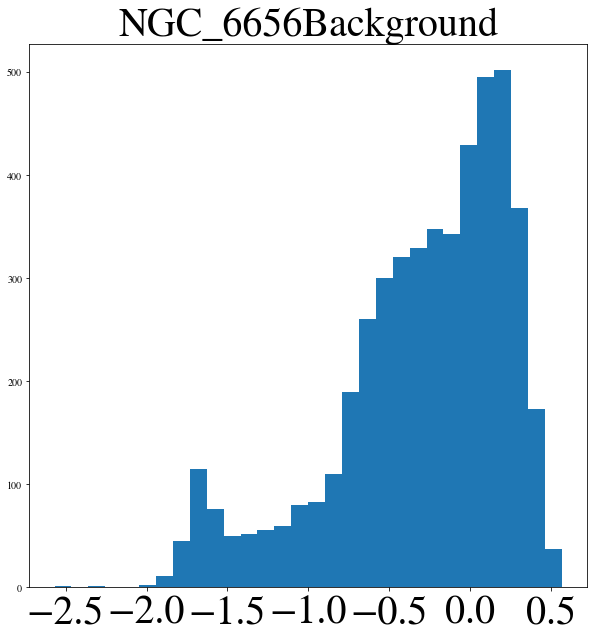

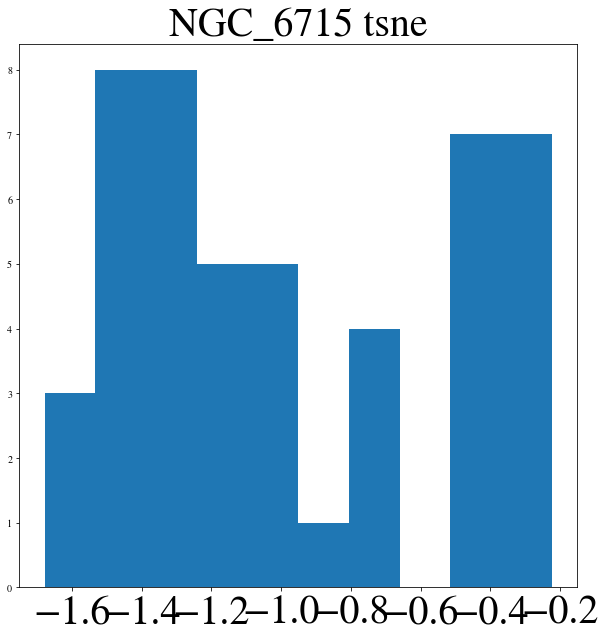

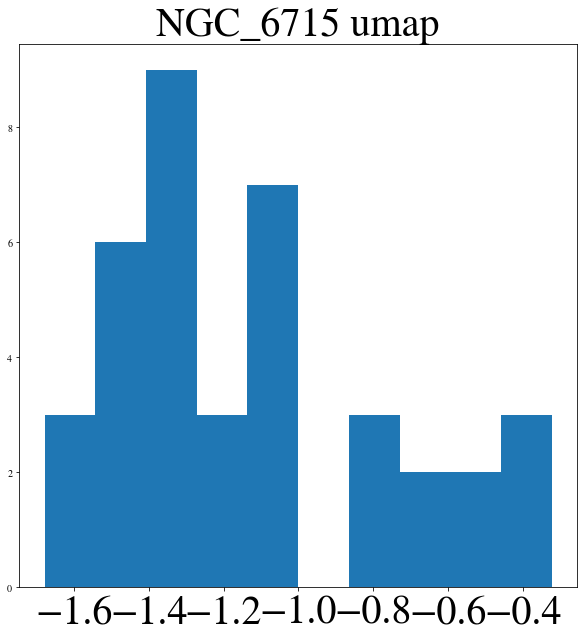

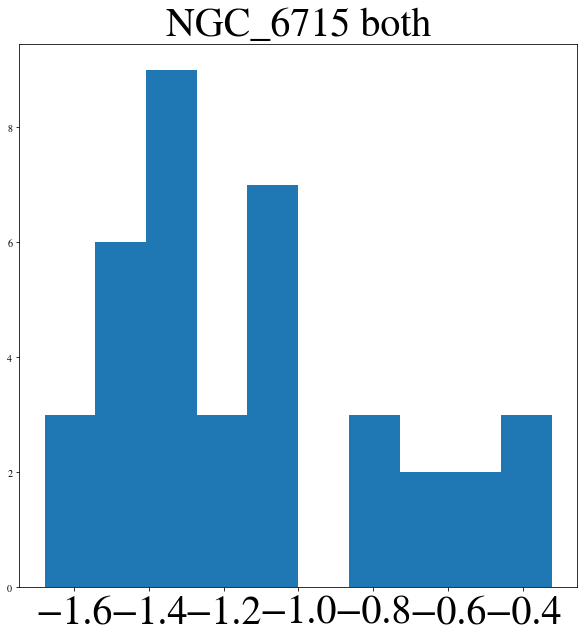

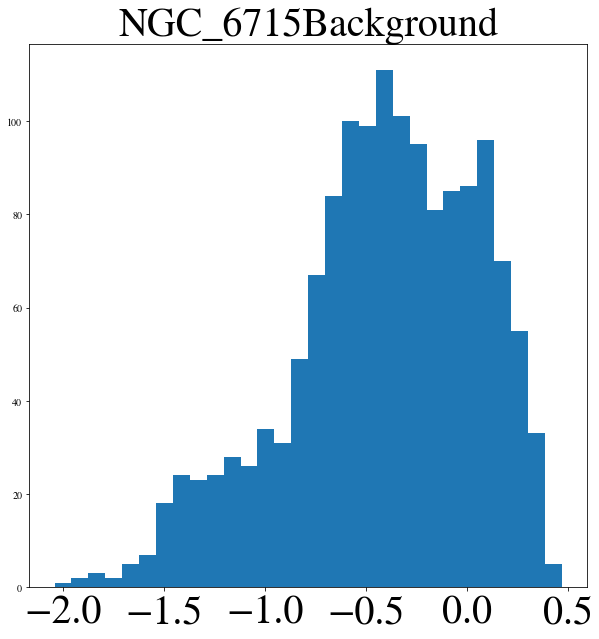

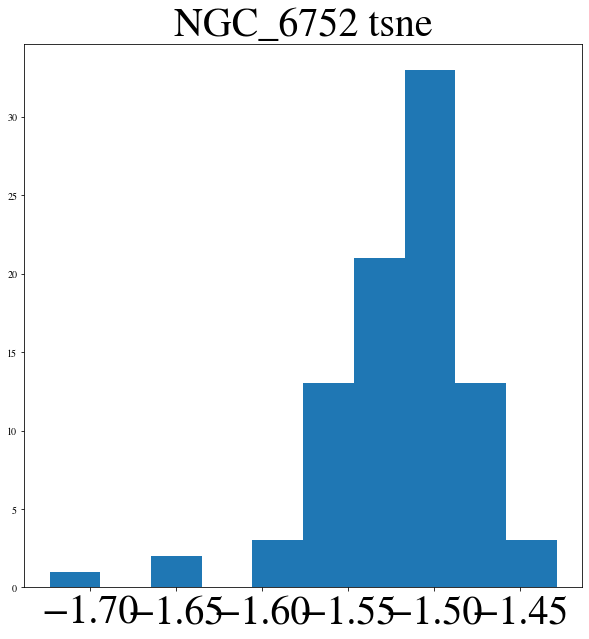

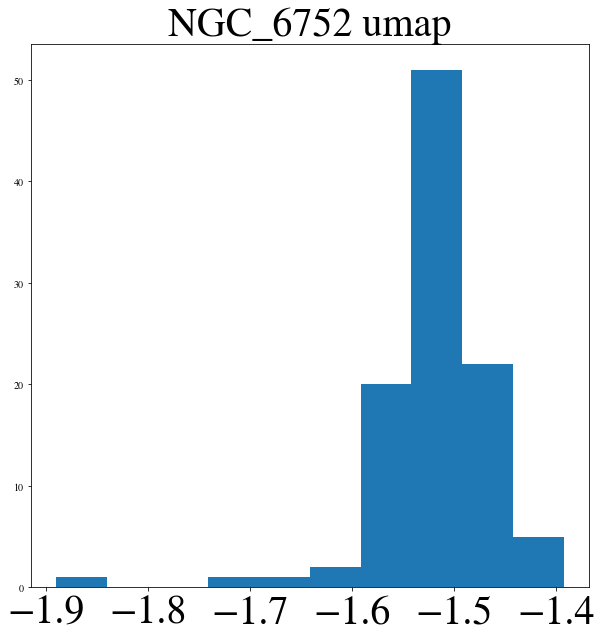

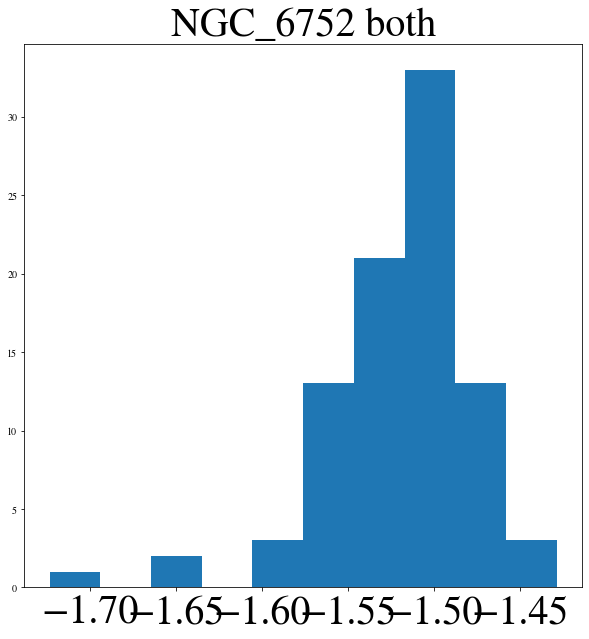

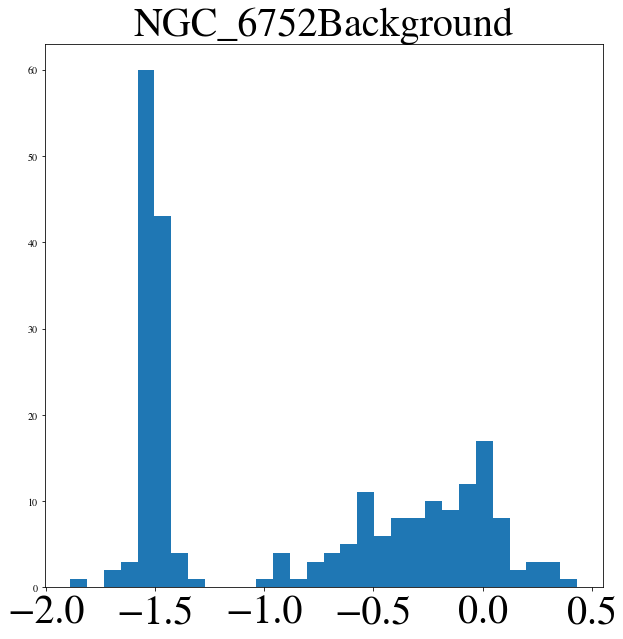

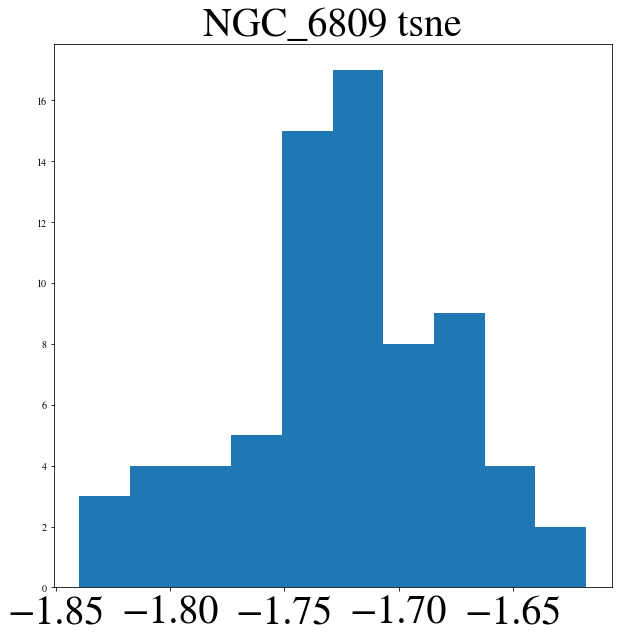

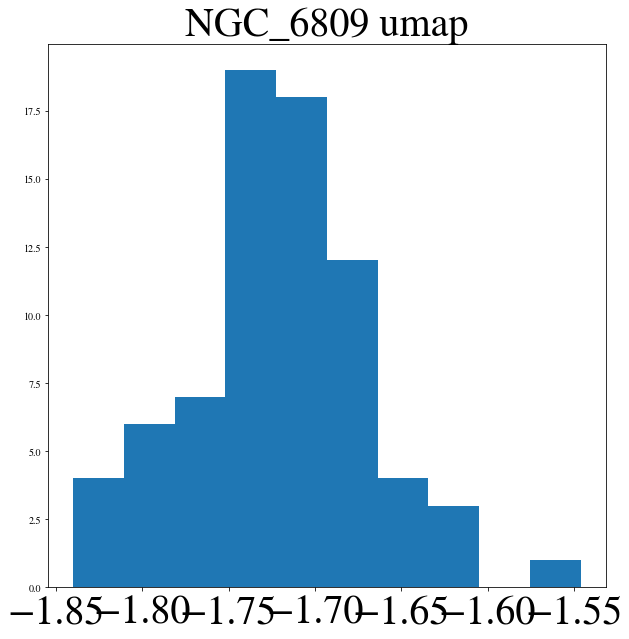

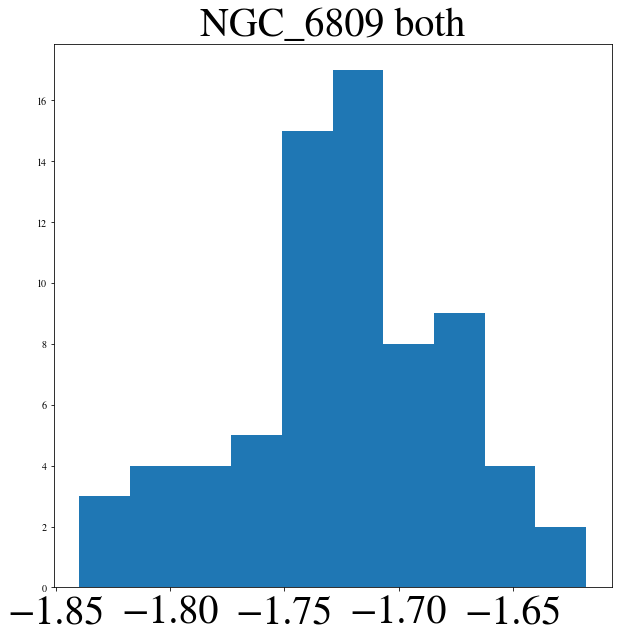

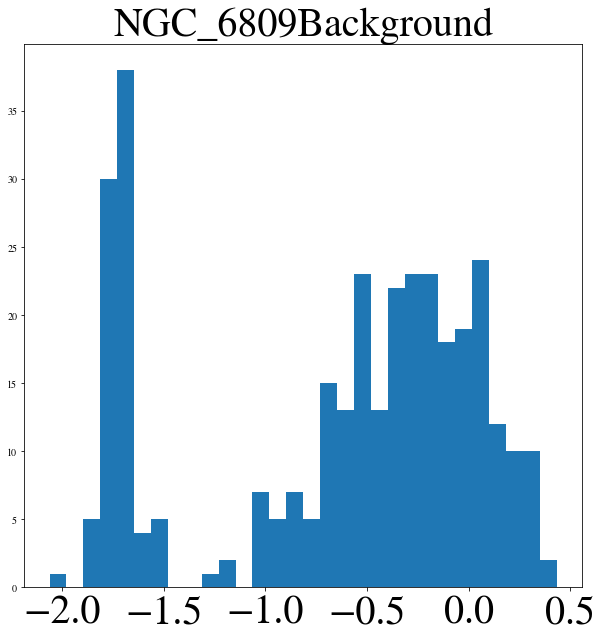

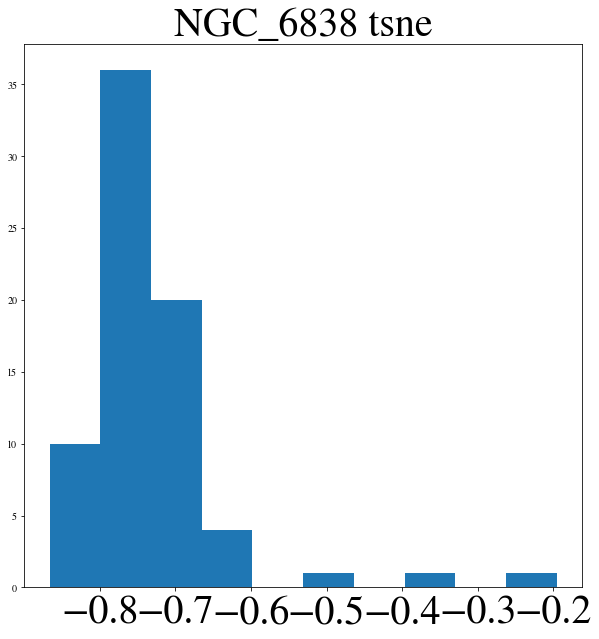

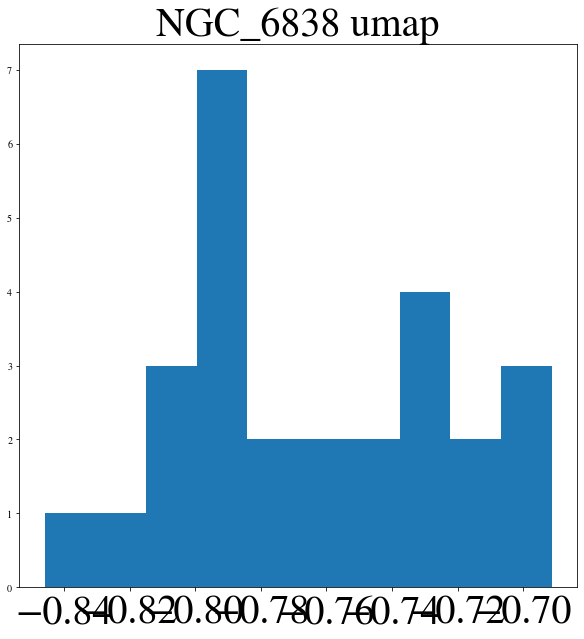

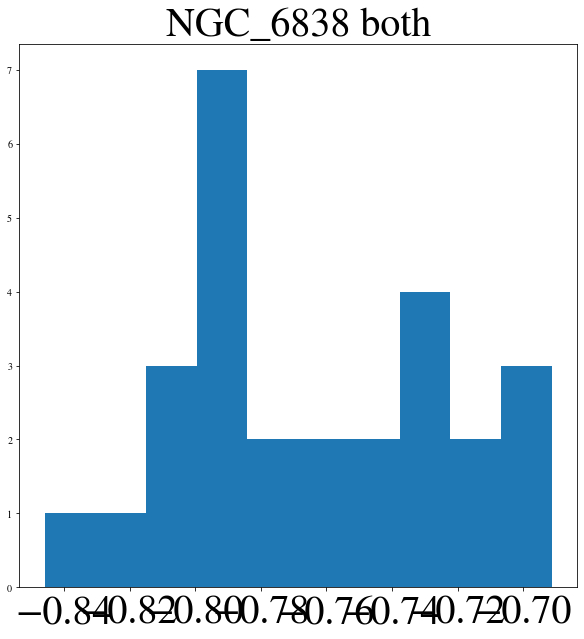

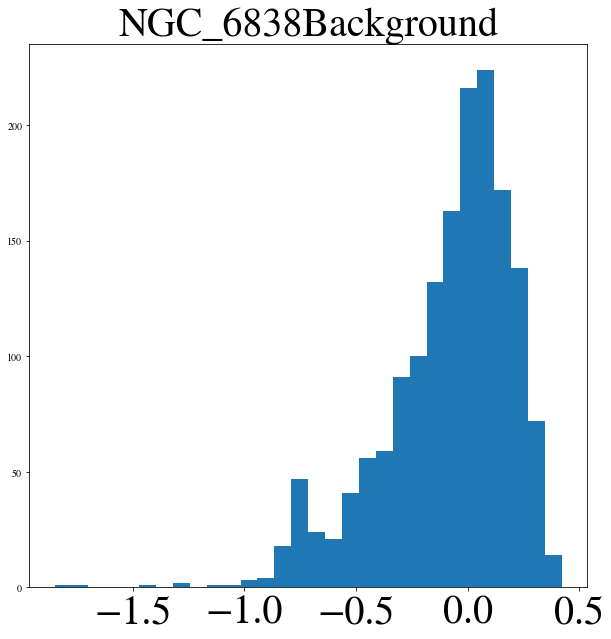

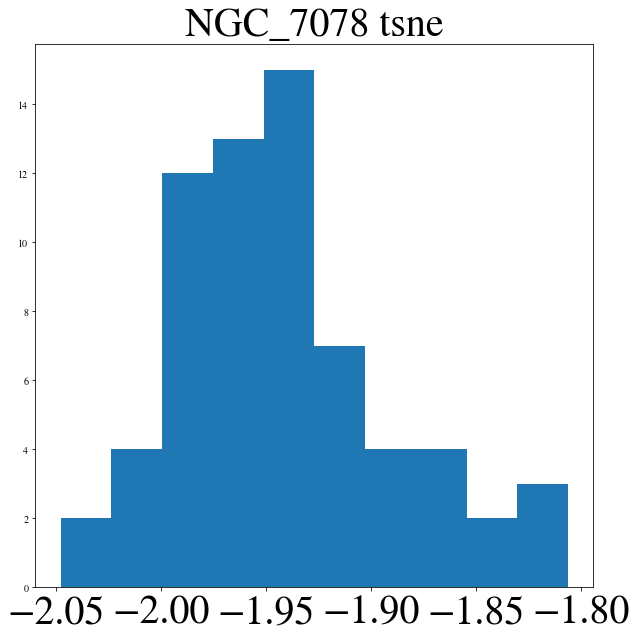

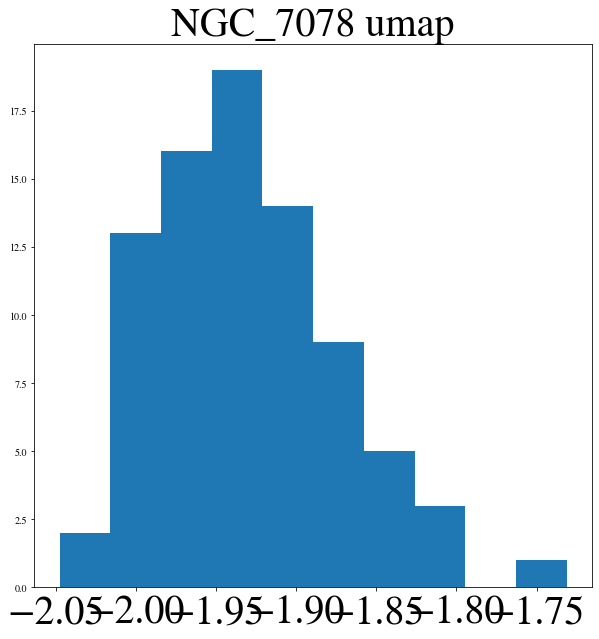

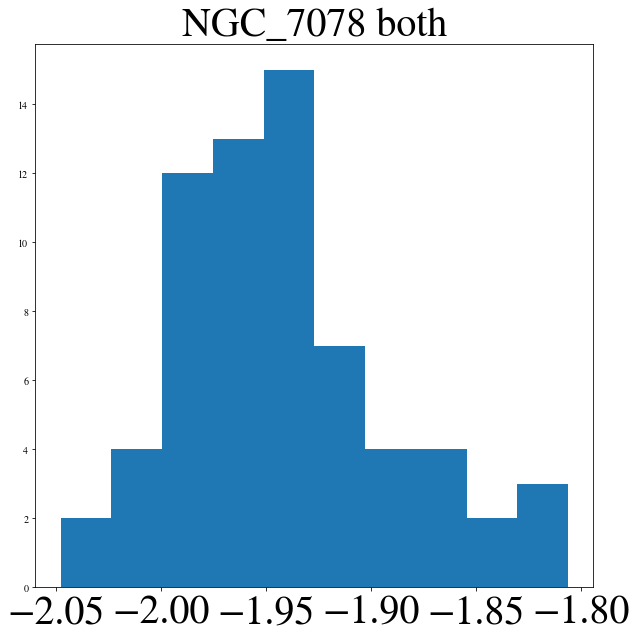

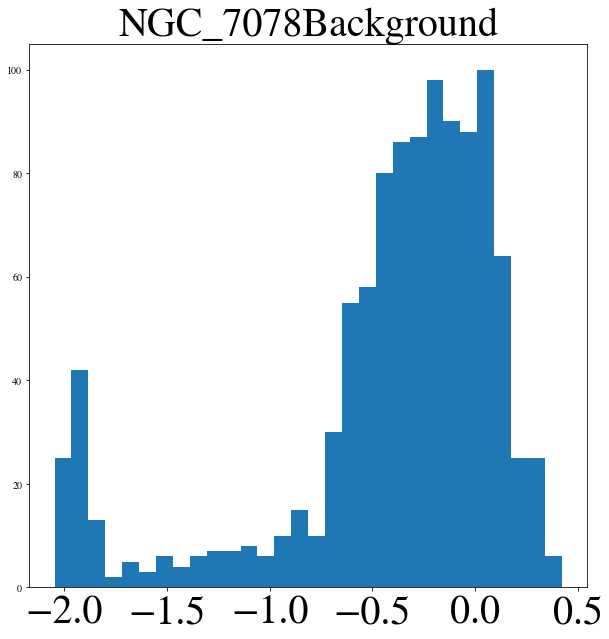

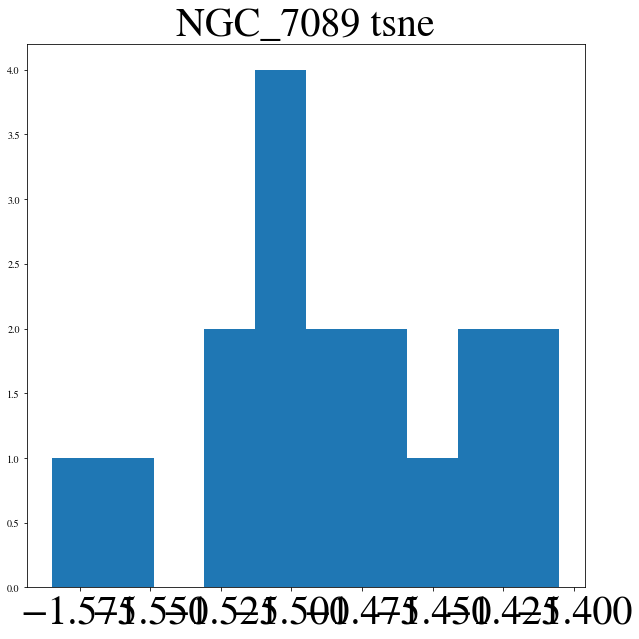

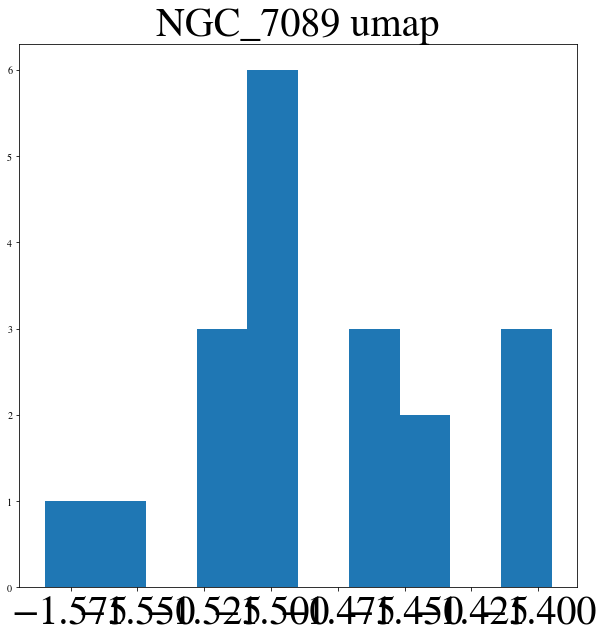

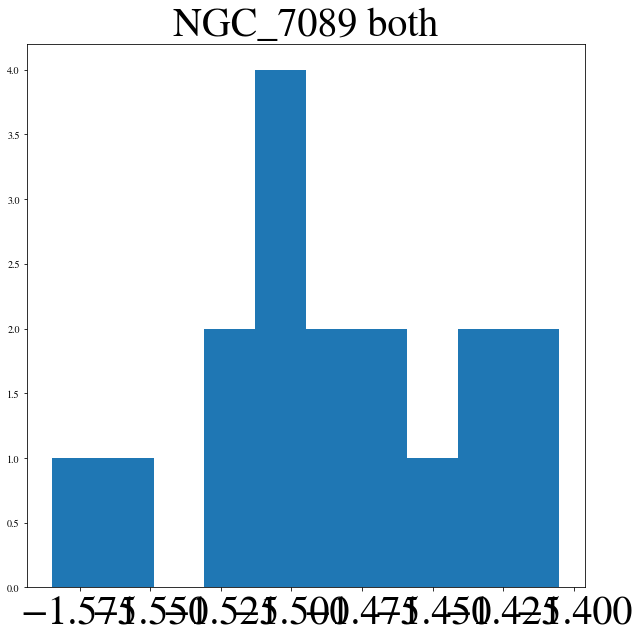

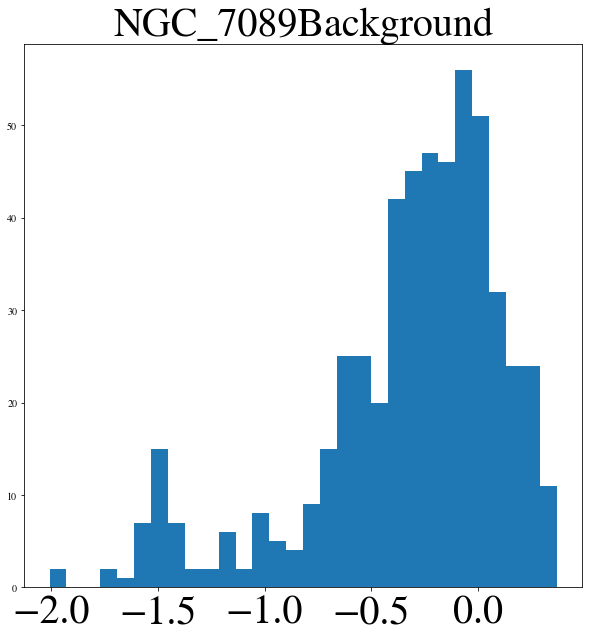

In [130]:
for i in tqdm(GC_name_list):        
    plt_fe(GC_ctrl_stars_Fe_tsne[i], 10, i, 'tsne')
    plt_fe(GC_ctrl_stars_Fe_umap[i], 10, i, 'umap')
    plt_fe(GC_ctrl_stars_Fe_both[i], 10, i, 'both')
    
    plt_bg(GC_stars_Fe[i], 30, i)

In [60]:
for i in tqdm(GC_name_list):
    plot_overlay(i, GC_stars_Fe[i], GC_ctrl_stars_Fe_tsne[i], GC_ctrl_stars_Fe_umap[i], bin_size = 0.2)

### red chi2 test

In [95]:
results_dict = {}

In [140]:
for i, k in tqdm(enumerate(GC_ctrl_stars_Fe_both)):
    # i is index, k is GC name, used as key for both Fe dictionaries
    # Fe values: GC_ctrl_stars_Fe_both
    # Fe_err values: GC_ctrl_stars_Fe_err_both
    
    print('\nRunning: ' + k)
    
    Fe_both = GC_ctrl_stars_Fe_both[k]
    Fe_err_both = GC_ctrl_stars_Fe_err_both[k]
    
    def mod_chi2_both(theta, x = Fe_both, x_err = Fe_err_both):
        mu, sigma_int = theta
        
        x_err = np.exp(x_err)
        top = (x - mu) ** 2
        bot = x_err**2 + sigma_int**2
        ln = np.log(bot)
        return np.sum(top / bot + ln)
    
    mu_0, sigma_0 = np.mean(Fe_both), np.mean(Fe_err_both)
    
    results = minimize(mod_chi2_both, [mu_0, sigma_0])
    
    print(results)
    
    results_dict[k] = results


Running: NGC_104
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 20.83295026402869
        x: [-7.364e-01  1.692e-08]
      nit: 4
      jac: [ 2.384e-07  5.960e-06]
 hess_inv: [[ 4.992e-03 -1.131e-07]
            [-1.131e-07  5.002e-03]]
     nfev: 21
     njev: 7

Running: NGC_288
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 11.36769757813724
        x: [-1.278e+00 -7.807e-09]
      nit: 5
      jac: [ 1.192e-07  0.000e+00]
 hess_inv: [[ 2.967e-02  2.284e-07]
            [ 2.284e-07  2.975e-02]]
     nfev: 24
     njev: 8

Running: NGC_362
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 14.199412496314073
        x: [-1.155e+00 -1.729e-09]
      nit: 5
      jac: [ 1.192e-07  3.576e-07]
 hess_inv: [[ 2.427e-02 -4.250e-08]
            [-4.250e-08  2.433e-02]]
     nfev: 24
     njev: 8

Running: NGC_1851
  message: Optimization terminated successfully.
  succe

In [142]:
hess_inv_dict = {}

In [143]:
for key in results_dict:
    if results_dict[key]['success']:
        hess_inv_dict[key] = np.sqrt(np.diag(results_dict[key]['hess_inv']))
    else:
        hess_inv_dict[key] = np.NAN

In [145]:
with open('red_chi2/results_dict.pkl', 'wb') as f:
    pickle.dump(results_dict, f)
    
with open('red_chi2/hess_inv.pkl', 'wb') as f:
    pickle.dump(hess_inv_dict, f)

In [ ]:
with open('red_chi2/results_dict.pkl', 'rb') as f:
    results_dict = pickle.load(f)
    
with open('red_chi2/hess_inv.pkl', 'rb') as f:
    hess_inv_dict = pickle.load(f)

In [287]:
metallicities_lit = pd.read_excel('metallicities_lit.xlsx')

In [288]:
cluster_name = metallicities_lit.loc[:,'Cluster Name']
lit_avg = metallicities_lit.loc[:,'Lit avg']
paper_avg = metallicities_lit.loc[:,'paper avg']
paper_std = metallicities_lit.loc[:,'paper std']
paper_err = metallicities_lit.loc[:,'paper err']

In [193]:
mean_arr = np.empty(len(results_dict), dtype=float)
sigma_sys_arr = np.empty(len(results_dict), dtype=float)
sigma_int_arr = np.empty(len(results_dict), dtype=float)

for i, k in enumerate(results_dict):
    mean_arr[i] = results_dict[k]['x'][0]
    sigma_sys_arr[i] = results_dict[k]['x'][1]
    
    if k == 'NGC_6553':
        sigma_int_arr[i] = np.nan
    else:
        sigma_xx = hess_inv_dict[k][0]
        sigma_yy = hess_inv_dict[k][1]
        sigma_int = np.sqrt(sigma_xx**2 + sigma_yy**2)

        sigma_int_arr[i] = sigma_int

In [250]:
sigma_tot_arr = np.empty(len(results_dict), dtype=float)
for i in range(len(sigma_sys_arr)):
    sigma_tot_arr[i] = np.sqrt(sigma_sys_arr[i]**2 + sigma_int_arr[i]**2)

In [316]:
bad_GCs = ['NGC_362', 'NGC_6171', 'NGC_6380', 'NGC_6388', 'NGC_6441', 'Ter9', 'NGC_6522', 'NGC_6553', 'NGC_6715']


paper_avg_good = np.empty(len(results_dict), dtype=float)
paper_std_good = np.empty(len(results_dict), dtype=float)
paper_err_good = np.empty(len(results_dict), dtype=float)
mean_arr_good = np.empty(len(results_dict), dtype=float)
sigma_sys_arr_good = np.empty(len(results_dict), dtype=float)
sigma_int_arr_good = np.empty(len(results_dict), dtype=float)

for i,k in enumerate(results_dict):
    if k not in bad_GCs:
        mean_arr_good[i] = results_dict[k]['x'][0]
        sigma_sys_arr_good[i] = results_dict[k]['x'][1]
    
        sigma_xx = hess_inv_dict[k][0]
        sigma_yy = hess_inv_dict[k][1]
        sigma_int = np.sqrt(sigma_xx**2 + sigma_yy**2)

        sigma_int_arr_good[i] = sigma_int
        
        paper_avg_good[i] = paper_avg[i]
        paper_std_good[i] = paper_std[i]
        paper_err_good[i] = paper_err[i]
    else:
        #print('bad gc', k)
        mean_arr_good[i] = np.nan
        sigma_sys_arr_good[i] = np.nan
        sigma_int_arr_good[i] = np.nan
        paper_avg_good[i] = np.nan
        paper_std_good[i] = np.nan
        paper_err_good[i] = np.nan

In [317]:
sigma_tot_arr_good = np.empty(len(results_dict), dtype=float)
for i in range(len(sigma_sys_arr_good)):
    sigma_tot_arr_good[i] = np.sqrt(sigma_sys_arr_good[i]**2 + sigma_int_arr_good[i]**2)

<ipython-input-318-1d229555ca87>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(paper_avg, fontsize=20)
<ipython-input-318-1d229555ca87>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(mean_arr, fontsize=20)


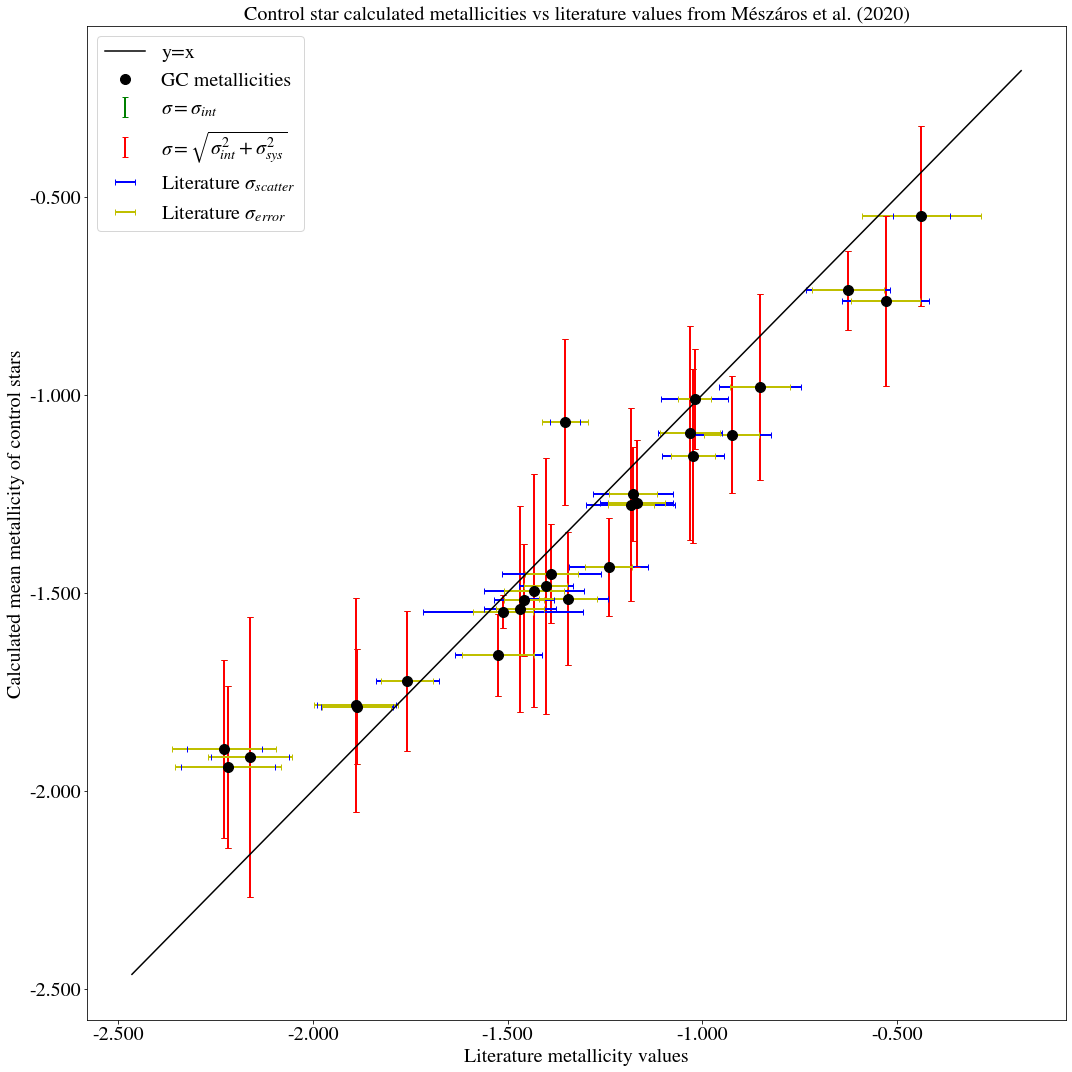

In [318]:
fig, ax = plt.subplots(1, figsize=(15,15))
ax.errorbar(paper_avg, mean_arr, color='k', marker='o', linestyle='none', markersize='10', elinewidth=3, label=r'GC metallicities')
ax.errorbar(paper_avg, mean_arr, yerr = sigma_int_arr, color='g', marker='o', linestyle='none', markersize='0', elinewidth=2, capsize=3, label=r'$\sigma=\sigma_{int}$')
ax.errorbar(paper_avg, mean_arr, yerr = sigma_tot_arr, color='r', marker='o', linestyle='none', markersize='0', elinewidth=2, capsize=3, label=r'$\sigma=\sqrt{\sigma_{int}^2+\sigma_{sys}^2}$')
ax.errorbar(paper_avg, mean_arr, xerr = paper_std, color='b', marker='o', linestyle='none', markersize='0', elinewidth=2, capsize=3, label=r'Literature $\sigma_{scatter}$')
ax.errorbar(paper_avg, mean_arr, xerr = paper_err, color='y', marker='o', linestyle='none', markersize='0', elinewidth=2, capsize=3, label=r'Literature $\sigma_{error}$')


ax.set_title('Control star calculated metallicities vs literature values from Mészáros et al. (2020)', fontsize=20)
ax.set_xlabel('Literature metallicity values', fontsize=20)
ax.set_ylabel('Calculated mean metallicity of control stars', fontsize=20)
ax.set_xticklabels(paper_avg, fontsize=20)
ax.set_yticklabels(mean_arr, fontsize=20)
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.plot(lims, lims, 'k', label='y=x')
ax.legend(fontsize=20, loc='best')
plt.tight_layout()
plt.savefig('metallicity_comp.png', dpi=200)
plt.show()


<ipython-input-319-ae09ec956c0c>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(paper_avg, fontsize=20)
<ipython-input-319-ae09ec956c0c>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(mean_arr, fontsize=20)


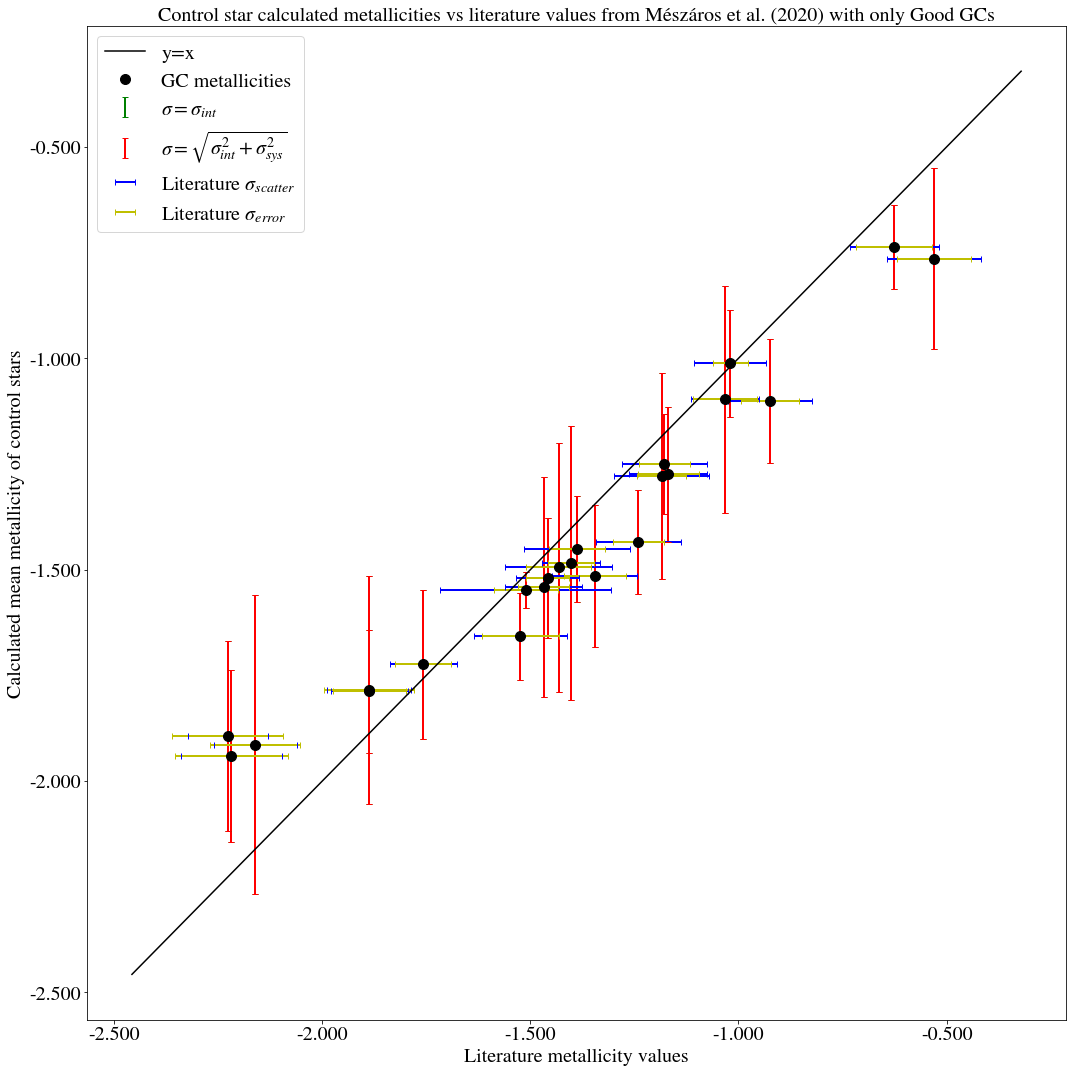

In [319]:
fig, ax = plt.subplots(1, figsize=(15,15))
ax.errorbar(paper_avg_good, mean_arr_good, color='k', marker='o', linestyle='none', markersize='10', elinewidth=3, label=r'GC metallicities')
ax.errorbar(paper_avg_good, mean_arr_good, yerr = sigma_int_arr_good, color='g', marker='o', linestyle='none', markersize='0', elinewidth=2, capsize=3, label=r'$\sigma=\sigma_{int}$')
ax.errorbar(paper_avg_good, mean_arr_good, yerr = sigma_tot_arr_good, color='r', marker='o', linestyle='none', markersize='0', elinewidth=2, capsize=3, label=r'$\sigma=\sqrt{\sigma_{int}^2+\sigma_{sys}^2}$')
ax.errorbar(paper_avg_good, mean_arr_good, xerr = paper_std_good, color='b', marker='o', linestyle='none', markersize='0', elinewidth=2, capsize=3, label=r'Literature $\sigma_{scatter}$')
ax.errorbar(paper_avg_good, mean_arr_good, xerr = paper_err_good, color='y', marker='o', linestyle='none', markersize='0', elinewidth=2, capsize=3, label=r'Literature $\sigma_{error}$')


ax.set_title('Control star calculated metallicities vs literature values from Mészáros et al. (2020) with only Good GCs', fontsize=20)
ax.set_xlabel('Literature metallicity values', fontsize=20)
ax.set_ylabel('Calculated mean metallicity of control stars', fontsize=20)
ax.set_xticklabels(paper_avg, fontsize=20)
ax.set_yticklabels(mean_arr, fontsize=20)
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.plot(lims, lims, 'k', label='y=x')
ax.legend(fontsize=20, loc='best')
plt.tight_layout()
plt.savefig('metallicity_comp_good_GCs.png', dpi=200)
plt.show()


## including et stars

In [321]:
with open('GCs_20RHMRT_5RT/final_et_stars.pkl', 'rb') as f:
    final_et = pickle.load(f)
    
with open('GCs_20RHMRT_5RT/final_tsne_et_stars.pkl', 'rb') as f:
    final_tsne = pickle.load(f)
    
with open('GCs_20RHMRT_5RT/final_umap_et_stars.pkl', 'rb') as f:
    final_umap = pickle.load(f)

In [322]:
GC_et_stars_Fe_tsne = {}
GC_et_stars_Fe_err_tsne = {}
GC_et_stars_Fe_umap = {}
GC_et_stars_Fe_err_umap = {}
GC_et_stars_Fe_both = {}
GC_et_stars_Fe_err_both = {}

In [329]:
for i, k in enumerate(GC_stars_Fe):
    GC_et_stars_Fe_tsne[k] = GC_stars_Fe[k][final_tsne[i]]
    GC_et_stars_Fe_umap[k] = GC_stars_Fe[k][final_umap[i]]
    GC_et_stars_Fe_both[k] = GC_stars_Fe[k][final_et[i]]
    
for i, k in enumerate(GC_stars_Fe_err):
    GC_et_stars_Fe_err_tsne[k] = GC_stars_Fe_err[k][final_tsne[i]]
    GC_et_stars_Fe_err_umap[k] = GC_stars_Fe_err[k][final_umap[i]]
    GC_et_stars_Fe_err_both[k] = GC_stars_Fe_err[k][final_et[i]]

In [351]:
def plot_overlay_et(name, bg, both, et, bin_size): 
    fig = plt.figure(figsize=(10,10))
    both_pack = [both, et]
    plt.hist(bg, bins=np.arange(min(bg), max(bg), bin_size), color='white', edgecolor='black', stacked='False', label='Background')
    plt.hist(both_pack, bins=np.arange(min(bg), max(bg), bin_size), color=['red', 'blue'], alpha=.5, stacked='True', label=['Controls', 'ETs'])
    plt.xticks(fontsize=20)
    plt.legend(loc='best')
    plt.title(name, fontsize=40)
    plt.savefig('GCs_metallicity/' + name + '_overlay_et_both.png')
    plt.close()

In [352]:
for i in tqdm(GC_name_list):
    plot_overlay_et(i, GC_stars_Fe[i], GC_ctrl_stars_Fe_both[i], GC_et_stars_Fe_both[i], bin_size = 0.2)

In [346]:
def plot_overlay_et(name, bg, tsne, umap, et, tsne_et, umap_et, bin_size): 
    fig = plt.figure(figsize=(10,10))
    tsne_pack = [tsne, tsne_et]
    umap_pack = [umap, umap_et]
    plt.hist(bg, bins=np.arange(min(bg), max(bg), bin_size), color='white', edgecolor='black', stacked='False', label='Background')
    plt.hist(tsne_pack, bins=np.arange(min(bg), max(bg), bin_size), color=['red', 'pink'], alpha=.3, stacked='True', label='t-SNE controls')
    plt.hist(umap_pack, bins=np.arange(min(bg), max(bg), bin_size), color=['blue', 'cyan'], alpha=.3, stacked='True', label='UMAP controls')
    plt.hist(et, bins=np.arange(min(bg), max(bg), bin_size), color='green', alpha=.3, stacked='True', label='Final ET stars')
    #plt.hist(tsne_et, bins=np.arange(min(bg), max(bg), bin_size), color='pink', alpha=.3, stacked='True', label='tSNE ET stars')
    #plt.hist(umap_et, bins=np.arange(min(bg), max(bg), bin_size), color='cyan', alpha=.3, stacked='True', label='UMAP ET stars')
    plt.xticks(fontsize=20)
    plt.legend(loc='best')
    plt.title(name, fontsize=40)
    plt.savefig('GCs_metallicity/' + name + '_overlay_et.png')
    plt.close()

In [347]:
for i in tqdm(GC_name_list):
    plot_overlay_et(i, GC_stars_Fe[i], GC_ctrl_stars_Fe_tsne[i], GC_ctrl_stars_Fe_umap[i], GC_et_stars_Fe_both[i], GC_et_stars_Fe_tsne[i], GC_et_stars_Fe_umap[i], bin_size = 0.2)